In [1]:

import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)


In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!pip install ipython-autotime

#%load_ext autotime

In [4]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [5]:
#!pip install opencv-python==4.4.0.44
#!pip install opencv-contrib-python==4.4.0.44

In [6]:

class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()
  


In [7]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers




In [8]:
tqdm = partial(tqdm, position=0, leave=True)


In [9]:

files_all=[]
for file in os.listdir("/content/drive/My Drive/tech-park-imgs"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/My Drive/tech-park-imgs/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:int(len(files_all)/2)+1]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[int(len(files_all)/2):]:
  right_files_path.append(folder_path + file)


In [10]:
print(len(files_all))

113


In [11]:
from multiprocessing import Pool

In [12]:
#pool = Pool(4)

#images_left_bgr = pool.map(get_images, left_files_path)

In [13]:
import multiprocessing
print(multiprocessing.cpu_count())

4


In [14]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)



100%|██████████| 57/57 [01:21<00:00,  1.43s/it]


In [15]:
Dataset = 'Tech_Park'

In [16]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 2.95182466506958 [s] ... size 836.347658 MB


In [17]:
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 4.206910848617554 [s] ... size 1115.129528 MB


In [18]:
del images_left_bgr,images_right_bgr

In [19]:


#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
#  right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)


In [20]:
from timeit import default_timer as timer


In [21]:
time_all = []

In [22]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_briefstar = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []

###**BRISK**

In [23]:
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [00:55<00:00,  1.04it/s]


In [24]:

for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))



100%|██████████| 113/113 [00:00<00:00, 294565.79it/s]


In [25]:
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)
      

In [26]:
all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)      

In [27]:
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [28]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [29]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [30]:
del Fdb, all_feat_brisk_left, all_feat_brisk_right

###**ORB**

In [31]:
orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [00:13<00:00,  4.35it/s]


In [32]:


for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))



100%|██████████| 113/113 [00:00<00:00, 109686.73it/s]


In [33]:
all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)
      

In [34]:
all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)      

In [35]:
del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [36]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [37]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [38]:
del Fdb, all_feat_orb_left, all_feat_orb_right

###**KAZE**

In [39]:
start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [04:52<00:00,  5.13s/it]


In [40]:


for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))



100%|██████████| 113/113 [00:00<00:00, 58687.02it/s]


In [41]:
all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)
      

In [42]:
all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)      

In [43]:
del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [44]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [45]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [46]:
del Fdb, all_feat_kaze_left, all_feat_kaze_right

###**AKAZE**

In [47]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [48]:
start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [00:46<00:00,  1.24it/s]


In [49]:


for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))



100%|██████████| 113/113 [00:00<00:00, 114041.47it/s]


In [50]:
all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)
      

In [51]:
all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)      

In [52]:
del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [53]:
import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [54]:
import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [55]:
del Fdb, all_feat_akaze_left, all_feat_akaze_right

###**STAR + BRIEF**

In [56]:
start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [00:10<00:00,  5.35it/s]


In [57]:


for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_briefstar.append(len(j))



100%|██████████| 113/113 [00:00<00:00, 205888.95it/s]


In [58]:
all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)
      

In [59]:
all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)      

In [60]:
del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [61]:
import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [62]:
import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [63]:
del Fdb, all_feat_star_left, all_feat_star_right

###**BRISK + FREAK**

In [64]:
start = timer()

Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


In [65]:


for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))



100%|██████████| 113/113 [00:00<00:00, 334478.72it/s]


In [66]:
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)
      

In [67]:
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)      

In [68]:
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [69]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [70]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [71]:
del Fdb, all_feat_freak_left, all_feat_freak_right

###**MSER + SIFT**

In [72]:
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [03:18<00:00,  3.49s/it]


In [73]:


for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))



100%|██████████| 113/113 [00:00<00:00, 319592.95it/s]


In [74]:
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)
      

In [75]:
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)      

In [76]:
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [77]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [78]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [79]:
del Fdb, all_feat_mser_left, all_feat_mser_right

###**AGAST + SIFT**

In [80]:
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [02:41<00:00,  2.83s/it]


In [81]:

for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))



100%|██████████| 113/113 [00:00<00:00, 172787.59it/s]


In [82]:
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)
      

In [83]:
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)      

In [84]:
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [85]:
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [86]:
del Fdb, all_feat_agast_left

In [87]:
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [88]:
del Fdb, all_feat_agast_right

###**FAST + SIFT**

In [89]:
start = timer()


fast = cv2.FastFeatureDetector_create(threshold=40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [02:22<00:00,  2.50s/it]


In [90]:

for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))



100%|██████████| 113/113 [00:00<00:00, 266118.11it/s]


In [91]:
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)
      

In [92]:
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)      

In [93]:
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [94]:
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [95]:
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [96]:
del Fdb, all_feat_fast_left, all_feat_fast_right

###**GFTT + SIFT**

In [97]:
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [00:13<00:00,  4.18it/s]


In [98]:


for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))



100%|██████████| 113/113 [00:00<00:00, 97421.66it/s]


In [99]:
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)
      

In [100]:
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)      

In [101]:
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [102]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [103]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [104]:
del Fdb, all_feat_gftt_left, all_feat_gftt_right

###**DAISY + SIFT**

In [105]:
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [01:13<00:00,  1.29s/it]


In [106]:


for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))


100%|██████████| 113/113 [00:00<00:00, 319592.95it/s]


In [107]:
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)
      

In [108]:
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)      

In [109]:
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [110]:
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [111]:
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [112]:
del Fdb, all_feat_daisy_left, all_feat_daisy_right

###**SURF + SIFT**

In [113]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)
'''

"\nstart = timer()\n\nsurf = cv2.xfeatures2d.SURF_create(upright=1)\nsift = cv2.xfeatures2d.SIFT_create()\n\nkeypoints_all_left_surfsift = []\ndescriptors_all_left_surfsift = []\npoints_all_left_surfsift=[]\n\nkeypoints_all_right_surfsift = []\ndescriptors_all_right_surfsift = []\npoints_all_right_surfsift=[]\n\nfor cnt in tqdm(range(len(left_files_path))):\n  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')\n  imgs = f['data'][cnt]\n  f.close()     \n  kpt = surf.detect(imgs,None)\n  kpt,descrip =  sift.compute(imgs, kpt)\n  keypoints_all_left_surfsift.append(kpt)\n  descriptors_all_left_surfsift.append(descrip)\n  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))\n\nfor cnt in tqdm(range(len(right_files_path))):\n  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')\n  imgs = f['data'][cnt+len(left_files_path)]\n  f.close()  \n  kpt = surf.detect(imgs,None)\n  kpt,descrip =  sift.compute(imgs, kpt)\n  keypoints_all_right_surfsift.appen

In [114]:

'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))
'''


'\nfor j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):\n  num_kps_surfsift.append(len(j))\n'

In [115]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)
'''

'\nall_feat_surfsift_left = []\nfor cnt,kpt_all in enumerate(keypoints_all_left_surfsift):\n  all_feat_surfsift_left_each = []\n  for cnt_each, kpt in enumerate(kpt_all):\n    desc = descriptors_all_left_surfsift[cnt][cnt_each]\n    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, \n        kpt.class_id, desc)\n    all_feat_surfsift_left_each.append(temp)\n  all_feat_surfsift_left.append(all_feat_surfsift_left_each)\n'

In [116]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)      
'''

'\nall_feat_surfsift_right = []\nfor cnt,kpt_all in enumerate(keypoints_all_right_surfsift):\n  all_feat_surfsift_right_each = []\n  for cnt_each, kpt in enumerate(kpt_all):\n    desc = descriptors_all_right_surfsift[cnt][cnt_each]\n    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, \n        kpt.class_id, desc)\n    all_feat_surfsift_right_each.append(temp)\n  all_feat_surfsift_right.append(all_feat_surfsift_right_each)      \n'

In [117]:
#del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [118]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()
'''

"\nimport pickle\nFdb = open('all_feat_surfsift_left.dat', 'wb')\npickle.dump(all_feat_surfsift_left,Fdb,-1)\nFdb.close()\n"

In [119]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()
'''

"\nimport pickle\nFdb = open('all_feat_surfsift_right.dat', 'wb')\npickle.dump(all_feat_surfsift_right,Fdb,-1)\nFdb.close()\n"

In [120]:
#del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

###**SIFT**

In [121]:
print(len(left_files_path))

57


In [122]:
print(len(right_files_path))

57


In [123]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [124]:
#del f

In [125]:
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [01:45<00:00,  1.86s/it]


In [126]:
for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))



100%|██████████| 113/113 [00:00<00:00, 217710.77it/s]


In [127]:
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)
      

In [128]:
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)      

In [129]:
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [130]:
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [131]:
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [132]:
del Fdb, all_feat_sift_left, all_feat_sift_right

In [133]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

###**SURF**

In [134]:
start = timer()

surf  = cv2.xfeatures2d.SURF_create(upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [01:00<00:00,  1.06s/it]


In [135]:


for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))


100%|██████████| 113/113 [00:00<00:00, 252238.61it/s]


In [136]:
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)
      

In [137]:
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)      

In [138]:
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [139]:
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [140]:
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [141]:
del Fdb, all_feat_surf_left, all_feat_surf_right

###**ROOTSIFT**

In [142]:
class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [143]:
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [01:51<00:00,  1.95s/it]


In [144]:

for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))



100%|██████████| 113/113 [00:00<00:00, 217112.39it/s]


In [145]:
all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)
      

In [146]:
all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)      

In [147]:
del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [148]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [149]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [150]:
del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

###**SuperPoint**

In [151]:
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

Cloning into 'SuperPointPretrainedNetwork'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.


In [152]:
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [153]:
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [154]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [155]:
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

Loading pre-trained network.
Successfully loaded pre-trained network.


In [306]:
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

  0%|          | 0/57 [00:00<?, ?it/s]

number of pts selected : 53156


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
  2%|▏         | 1/57 [00:00<00:28,  1.99it/s]

number of pts selected : 44533


  4%|▎         | 2/57 [00:00<00:26,  2.10it/s]

number of pts selected : 50442


  5%|▌         | 3/57 [00:01<00:25,  2.11it/s]

number of pts selected : 58182


  7%|▋         | 4/57 [00:01<00:25,  2.07it/s]

number of pts selected : 48703


  9%|▉         | 5/57 [00:02<00:24,  2.08it/s]

number of pts selected : 40556


 12%|█▏        | 7/57 [00:03<00:22,  2.25it/s]

number of pts selected : 32157


 14%|█▍        | 8/57 [00:03<00:20,  2.44it/s]

number of pts selected : 18203


 16%|█▌        | 9/57 [00:03<00:18,  2.63it/s]

number of pts selected : 13283


 18%|█▊        | 10/57 [00:04<00:16,  2.81it/s]

number of pts selected : 11503


 19%|█▉        | 11/57 [00:04<00:15,  2.90it/s]

number of pts selected : 12916


 21%|██        | 12/57 [00:04<00:15,  2.86it/s]

number of pts selected : 23829


 23%|██▎       | 13/57 [00:05<00:15,  2.75it/s]

number of pts selected : 33534


 25%|██▍       | 14/57 [00:05<00:15,  2.74it/s]

number of pts selected : 27146
number of pts selected : 41211


 28%|██▊       | 16/57 [00:06<00:15,  2.60it/s]

number of pts selected : 34026


 30%|██▉       | 17/57 [00:06<00:14,  2.72it/s]

number of pts selected : 17769


 32%|███▏      | 18/57 [00:07<00:13,  2.91it/s]

number of pts selected : 6995


 33%|███▎      | 19/57 [00:07<00:12,  3.05it/s]

number of pts selected : 7853


 35%|███▌      | 20/57 [00:07<00:11,  3.16it/s]

number of pts selected : 8426


 37%|███▋      | 21/57 [00:07<00:11,  3.12it/s]

number of pts selected : 17512


 39%|███▊      | 22/57 [00:08<00:12,  2.90it/s]

number of pts selected : 34345
number of pts selected : 37795


 40%|████      | 23/57 [00:08<00:12,  2.71it/s]

number of pts selected : 51322


 42%|████▏     | 24/57 [00:09<00:13,  2.49it/s]

number of pts selected : 56246


 46%|████▌     | 26/57 [00:10<00:12,  2.41it/s]

number of pts selected : 31655


 47%|████▋     | 27/57 [00:10<00:12,  2.40it/s]

number of pts selected : 39576
number of pts selected : 48224


 51%|█████     | 29/57 [00:11<00:11,  2.35it/s]

number of pts selected : 38538
number of pts selected : 37527


 54%|█████▍    | 31/57 [00:12<00:10,  2.37it/s]

number of pts selected : 37295


 56%|█████▌    | 32/57 [00:12<00:10,  2.43it/s]

number of pts selected : 32743


 58%|█████▊    | 33/57 [00:13<00:09,  2.45it/s]

number of pts selected : 33362
number of pts selected : 44329


 60%|█████▉    | 34/57 [00:13<00:09,  2.41it/s]

number of pts selected : 58951


 61%|██████▏   | 35/57 [00:13<00:09,  2.26it/s]

number of pts selected : 41461


 65%|██████▍   | 37/57 [00:14<00:08,  2.36it/s]

number of pts selected : 32179


 67%|██████▋   | 38/57 [00:15<00:07,  2.43it/s]

number of pts selected : 30304


 68%|██████▊   | 39/57 [00:15<00:07,  2.54it/s]

number of pts selected : 23040


 70%|███████   | 40/57 [00:15<00:06,  2.75it/s]

number of pts selected : 8771


 72%|███████▏  | 41/57 [00:16<00:05,  2.95it/s]

number of pts selected : 8158


 74%|███████▎  | 42/57 [00:16<00:04,  3.12it/s]

number of pts selected : 7996


 75%|███████▌  | 43/57 [00:16<00:04,  2.97it/s]

number of pts selected : 30803
number of pts selected : 46036


 79%|███████▉  | 45/57 [00:17<00:04,  2.63it/s]

number of pts selected : 34416


 81%|████████  | 46/57 [00:17<00:04,  2.65it/s]

number of pts selected : 27412


 82%|████████▏ | 47/57 [00:18<00:03,  2.79it/s]

number of pts selected : 12040


 84%|████████▍ | 48/57 [00:18<00:03,  2.94it/s]

number of pts selected : 11423


 86%|████████▌ | 49/57 [00:18<00:02,  3.03it/s]

number of pts selected : 12788


 88%|████████▊ | 50/57 [00:19<00:02,  2.89it/s]

number of pts selected : 31665


 89%|████████▉ | 51/57 [00:19<00:02,  2.81it/s]

number of pts selected : 30334


 91%|█████████ | 52/57 [00:19<00:01,  2.85it/s]

number of pts selected : 20990


 93%|█████████▎| 53/57 [00:20<00:01,  2.80it/s]

number of pts selected : 26874


 95%|█████████▍| 54/57 [00:20<00:01,  2.72it/s]

number of pts selected : 33568


 96%|█████████▋| 55/57 [00:21<00:00,  2.74it/s]

number of pts selected : 26425


 98%|█████████▊| 56/57 [00:21<00:00,  2.77it/s]

number of pts selected : 23656


  0%|          | 0/57 [00:00<?, ?it/s]

number of pts selected : 20133
number of pts selected : 53156


  2%|▏         | 1/57 [00:00<00:21,  2.57it/s]

number of pts selected : 44533


  4%|▎         | 2/57 [00:00<00:20,  2.64it/s]

number of pts selected : 50442


  5%|▌         | 3/57 [00:01<00:20,  2.66it/s]

number of pts selected : 58182


  7%|▋         | 4/57 [00:01<00:20,  2.59it/s]

number of pts selected : 48703


  9%|▉         | 5/57 [00:01<00:19,  2.64it/s]

number of pts selected : 40556


 12%|█▏        | 7/57 [00:02<00:17,  2.92it/s]

number of pts selected : 32157


 14%|█▍        | 8/57 [00:02<00:15,  3.24it/s]

number of pts selected : 18203


 16%|█▌        | 9/57 [00:02<00:13,  3.56it/s]

number of pts selected : 13283


 18%|█▊        | 10/57 [00:03<00:12,  3.82it/s]

number of pts selected : 11503


 19%|█▉        | 11/57 [00:03<00:11,  4.04it/s]

number of pts selected : 12916


 21%|██        | 12/57 [00:03<00:11,  3.96it/s]

number of pts selected : 23829


 23%|██▎       | 13/57 [00:03<00:11,  3.76it/s]

number of pts selected : 33534


 25%|██▍       | 14/57 [00:04<00:11,  3.74it/s]

number of pts selected : 27146
number of pts selected : 41211


 28%|██▊       | 16/57 [00:04<00:11,  3.45it/s]

number of pts selected : 34026


 30%|██▉       | 17/57 [00:05<00:10,  3.67it/s]

number of pts selected : 17769


 32%|███▏      | 18/57 [00:05<00:09,  4.05it/s]

number of pts selected : 6995
number of pts selected : 7853


 35%|███▌      | 20/57 [00:05<00:08,  4.56it/s]

number of pts selected : 8426
number of pts selected : 17512


 39%|███▊      | 22/57 [00:06<00:08,  4.07it/s]

number of pts selected : 34345


 40%|████      | 23/57 [00:06<00:09,  3.75it/s]

number of pts selected : 37795
number of pts selected : 51322


 42%|████▏     | 24/57 [00:06<00:09,  3.33it/s]

number of pts selected : 56246


 46%|████▌     | 26/57 [00:07<00:09,  3.14it/s]

number of pts selected : 31655
number of pts selected : 39576


 47%|████▋     | 27/57 [00:07<00:09,  3.14it/s]

number of pts selected : 48224


 51%|█████     | 29/57 [00:08<00:09,  3.06it/s]

number of pts selected : 38538


 53%|█████▎    | 30/57 [00:08<00:08,  3.09it/s]

number of pts selected : 37527


 54%|█████▍    | 31/57 [00:09<00:08,  3.12it/s]

number of pts selected : 37295


 56%|█████▌    | 32/57 [00:09<00:07,  3.20it/s]

number of pts selected : 32743


 58%|█████▊    | 33/57 [00:09<00:07,  3.25it/s]

number of pts selected : 33362
number of pts selected : 44329


 60%|█████▉    | 34/57 [00:10<00:07,  3.16it/s]

number of pts selected : 58951


 61%|██████▏   | 35/57 [00:10<00:07,  2.90it/s]

number of pts selected : 41461


 65%|██████▍   | 37/57 [00:11<00:06,  3.12it/s]

number of pts selected : 32179


 67%|██████▋   | 38/57 [00:11<00:05,  3.21it/s]

number of pts selected : 30304


 68%|██████▊   | 39/57 [00:11<00:05,  3.41it/s]

number of pts selected : 23040


 70%|███████   | 40/57 [00:11<00:04,  3.82it/s]

number of pts selected : 8771
number of pts selected : 8158


 74%|███████▎  | 42/57 [00:12<00:03,  4.48it/s]

number of pts selected : 7996
number of pts selected : 30803


 75%|███████▌  | 43/57 [00:12<00:03,  4.14it/s]

number of pts selected : 46036


 79%|███████▉  | 45/57 [00:13<00:03,  3.55it/s]

number of pts selected : 34416


 81%|████████  | 46/57 [00:13<00:03,  3.60it/s]

number of pts selected : 27412


 82%|████████▏ | 47/57 [00:13<00:02,  3.88it/s]

number of pts selected : 12040


 84%|████████▍ | 48/57 [00:13<00:02,  4.14it/s]

number of pts selected : 11423


 86%|████████▌ | 49/57 [00:14<00:01,  4.33it/s]

number of pts selected : 12788


 88%|████████▊ | 50/57 [00:14<00:01,  4.03it/s]

number of pts selected : 31665


 89%|████████▉ | 51/57 [00:14<00:01,  3.87it/s]

number of pts selected : 30334


 91%|█████████ | 52/57 [00:14<00:01,  3.95it/s]

number of pts selected : 20990


 93%|█████████▎| 53/57 [00:15<00:01,  3.92it/s]

number of pts selected : 26874


 95%|█████████▍| 54/57 [00:15<00:00,  3.71it/s]

number of pts selected : 33568


 96%|█████████▋| 55/57 [00:15<00:00,  3.74it/s]

number of pts selected : 26425


 98%|█████████▊| 56/57 [00:15<00:00,  3.75it/s]

number of pts selected : 23656


100%|██████████| 57/57 [00:16<00:00,  3.52it/s]

number of pts selected : 20133


In [157]:


for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

100%|██████████| 113/113 [00:00<00:00, 123974.98it/s]


In [158]:
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)
      

In [159]:
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)      

In [307]:
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [161]:
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [162]:
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [163]:
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

### **Total Matches,Robust Matches and Homography Computation**

In [164]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [165]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [166]:

def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [ ]:

def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]


In [167]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [168]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [169]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:35,  1.58it/s]


Number of matches 6461
Number of matches After Lowe's Ratio 48
Number of Robust matches 8


Number of matches After Lowe's Ratio New 445
Number of Robust matches New 20




  4%|▎         | 2/57 [00:01<00:31,  1.74it/s]


Number of matches 9922
Number of matches After Lowe's Ratio 46
Number of Robust matches 19


Number of matches After Lowe's Ratio New 394
Number of Robust matches New 64




  5%|▌         | 3/57 [00:01<00:32,  1.65it/s]


Number of matches 23366
Number of matches After Lowe's Ratio 111
Number of Robust matches 28




  7%|▋         | 4/57 [00:03<00:42,  1.24it/s]


Number of matches 11327
Number of matches After Lowe's Ratio 23
Number of Robust matches 6


Number of matches After Lowe's Ratio New 564
Number of Robust matches New 13




  9%|▉         | 5/57 [00:03<00:37,  1.40it/s]


Number of matches 8708
Number of matches After Lowe's Ratio 73
Number of Robust matches 40




 11%|█         | 6/57 [00:04<00:35,  1.44it/s]


Number of matches 24608
Number of matches After Lowe's Ratio 103
Number of Robust matches 43




 12%|█▏        | 7/57 [00:08<01:25,  1.71s/it]


Number of matches 79639
Number of matches After Lowe's Ratio 408
Number of Robust matches 283




 14%|█▍        | 8/57 [00:18<03:32,  4.33s/it]


Number of matches 103038
Number of matches After Lowe's Ratio 921
Number of Robust matches 480




 16%|█▌        | 9/57 [00:31<05:34,  6.96s/it]


Number of matches 112780
Number of matches After Lowe's Ratio 548
Number of Robust matches 290




 18%|█▊        | 10/57 [00:44<06:41,  8.55s/it]


Number of matches 103737
Number of matches After Lowe's Ratio 634
Number of Robust matches 268




 19%|█▉        | 11/57 [00:52<06:28,  8.44s/it]


Number of matches 66328
Number of matches After Lowe's Ratio 206
Number of Robust matches 130




 21%|██        | 12/57 [01:00<06:11,  8.25s/it]


Number of matches 62527
Number of matches After Lowe's Ratio 622
Number of Robust matches 414




 23%|██▎       | 13/57 [01:07<05:54,  8.05s/it]


Number of matches 62088
Number of matches After Lowe's Ratio 354
Number of Robust matches 267




 25%|██▍       | 14/57 [01:11<04:48,  6.70s/it]


Number of matches 10921
Number of matches After Lowe's Ratio 25
Number of Robust matches 11


Number of matches After Lowe's Ratio New 384
Number of Robust matches New 37




 26%|██▋       | 15/57 [01:12<03:27,  4.94s/it]


Number of matches 25005
Number of matches After Lowe's Ratio 77
Number of Robust matches 24


Number of matches After Lowe's Ratio New 944
Number of Robust matches New 13




 28%|██▊       | 16/57 [01:15<02:58,  4.35s/it]


Number of matches 49702
Number of matches After Lowe's Ratio 117
Number of Robust matches 75




 30%|██▉       | 17/57 [01:24<03:50,  5.76s/it]


Number of matches 87310
Number of matches After Lowe's Ratio 137
Number of Robust matches 109




 32%|███▏      | 18/57 [01:34<04:36,  7.08s/it]


Number of matches 95529
Number of matches After Lowe's Ratio 281
Number of Robust matches 166




 33%|███▎      | 19/57 [01:43<04:57,  7.83s/it]


Number of matches 94927
Number of matches After Lowe's Ratio 628
Number of Robust matches 438




 35%|███▌      | 20/57 [01:50<04:40,  7.58s/it]


Number of matches 49463
Number of matches After Lowe's Ratio 249
Number of Robust matches 121




 37%|███▋      | 21/57 [01:53<03:41,  6.17s/it]


Number of matches 12750
Number of matches After Lowe's Ratio 100
Number of Robust matches 68




 39%|███▊      | 22/57 [01:54<02:36,  4.48s/it]


Number of matches 8664
Number of matches After Lowe's Ratio 92
Number of Robust matches 46




 40%|████      | 23/57 [01:55<01:55,  3.41s/it]


Number of matches 13304
Number of matches After Lowe's Ratio 22
Number of Robust matches 10


Number of matches After Lowe's Ratio New 533
Number of Robust matches New 8




 42%|████▏     | 24/57 [01:55<01:25,  2.60s/it]


Number of matches 18916
Number of matches After Lowe's Ratio 95
Number of Robust matches 37




 44%|████▍     | 25/57 [01:57<01:16,  2.40s/it]


Number of matches 55022
Number of matches After Lowe's Ratio 94
Number of Robust matches 27




 46%|████▌     | 26/57 [02:02<01:40,  3.23s/it]


Number of matches 42520
Number of matches After Lowe's Ratio 173
Number of Robust matches 15


Number of matches After Lowe's Ratio New 2835
Number of Robust matches New 76




 47%|████▋     | 27/57 [02:05<01:27,  2.92s/it]


Number of matches 8481
Number of matches After Lowe's Ratio 20
Number of Robust matches 9


Number of matches After Lowe's Ratio New 354
Number of Robust matches New 10




 49%|████▉     | 28/57 [02:05<01:02,  2.17s/it]


Number of matches 10822
Number of matches After Lowe's Ratio 100
Number of Robust matches 62




 51%|█████     | 29/57 [02:06<00:46,  1.67s/it]


Number of matches 9536
Number of matches After Lowe's Ratio 163
Number of Robust matches 75




 53%|█████▎    | 30/57 [02:06<00:35,  1.31s/it]


Number of matches 10373
Number of matches After Lowe's Ratio 70
Number of Robust matches 31




 54%|█████▍    | 31/57 [02:07<00:28,  1.08s/it]


Number of matches 14687
Number of matches After Lowe's Ratio 85
Number of Robust matches 38




 56%|█████▌    | 32/57 [02:08<00:27,  1.12s/it]


Number of matches 11951
Number of matches After Lowe's Ratio 27
Number of Robust matches 5


Number of matches After Lowe's Ratio New 759
Number of Robust matches New 17




 58%|█████▊    | 33/57 [02:08<00:22,  1.06it/s]


Number of matches 8976
Number of matches After Lowe's Ratio 67
Number of Robust matches 40




 60%|█████▉    | 34/57 [02:09<00:19,  1.21it/s]


Number of matches 17849
Number of matches After Lowe's Ratio 101
Number of Robust matches 44




 61%|██████▏   | 35/57 [02:10<00:19,  1.13it/s]


Number of matches 11156
Number of matches After Lowe's Ratio 105
Number of Robust matches 20


Number of matches After Lowe's Ratio New 742
Number of Robust matches New 46




 63%|██████▎   | 36/57 [02:10<00:16,  1.28it/s]


Number of matches 11651
Number of matches After Lowe's Ratio 59
Number of Robust matches 26




 65%|██████▍   | 37/57 [02:11<00:14,  1.35it/s]


Number of matches 13135
Number of matches After Lowe's Ratio 28
Number of Robust matches 10


Number of matches After Lowe's Ratio New 470
Number of Robust matches New 13




 67%|██████▋   | 38/57 [02:12<00:17,  1.08it/s]


Number of matches 34116
Number of matches After Lowe's Ratio 199
Number of Robust matches 105




 68%|██████▊   | 39/57 [02:16<00:32,  1.79s/it]


Number of matches 46716
Number of matches After Lowe's Ratio 297
Number of Robust matches 221




 70%|███████   | 40/57 [02:21<00:47,  2.77s/it]


Number of matches 41844
Number of matches After Lowe's Ratio 125
Number of Robust matches 75




 72%|███████▏  | 41/57 [02:26<00:55,  3.46s/it]


Number of matches 49246
Number of matches After Lowe's Ratio 197
Number of Robust matches 132




 74%|███████▎  | 42/57 [02:30<00:52,  3.49s/it]


Number of matches 19787
Number of matches After Lowe's Ratio 122
Number of Robust matches 68




 75%|███████▌  | 43/57 [02:31<00:39,  2.80s/it]


Number of matches 14040
Number of matches After Lowe's Ratio 58
Number of Robust matches 40




 77%|███████▋  | 44/57 [02:32<00:30,  2.35s/it]


Number of matches 30716
Number of matches After Lowe's Ratio 101
Number of Robust matches 42




 79%|███████▉  | 45/57 [02:35<00:29,  2.46s/it]


Number of matches 39097
Number of matches After Lowe's Ratio 461
Number of Robust matches 319




 81%|████████  | 46/57 [02:40<00:35,  3.20s/it]


Number of matches 53119
Number of matches After Lowe's Ratio 104
Number of Robust matches 60




 82%|████████▏ | 47/57 [02:47<00:41,  4.19s/it]


Number of matches 59489
Number of matches After Lowe's Ratio 312
Number of Robust matches 196




 84%|████████▍ | 48/57 [02:52<00:41,  4.59s/it]


Number of matches 34604
Number of matches After Lowe's Ratio 812
Number of Robust matches 574




 86%|████████▌ | 49/57 [02:54<00:30,  3.87s/it]


Number of matches 15837
Number of matches After Lowe's Ratio 88
Number of Robust matches 51




 88%|████████▊ | 50/57 [02:55<00:20,  2.95s/it]


Number of matches 16478
Number of matches After Lowe's Ratio 208
Number of Robust matches 89




 89%|████████▉ | 51/57 [02:56<00:14,  2.41s/it]


Number of matches 17596
Number of matches After Lowe's Ratio 91
Number of Robust matches 38




 91%|█████████ | 52/57 [02:57<00:09,  1.95s/it]


Number of matches 11173
Number of matches After Lowe's Ratio 143
Number of Robust matches 53




 93%|█████████▎| 53/57 [02:58<00:06,  1.52s/it]


Number of matches 9037
Number of matches After Lowe's Ratio 95
Number of Robust matches 60




 95%|█████████▍| 54/57 [02:58<00:03,  1.31s/it]


Number of matches 10678
Number of matches After Lowe's Ratio 179
Number of Robust matches 95




 96%|█████████▋| 55/57 [02:59<00:02,  1.07s/it]


Number of matches 10347
Number of matches After Lowe's Ratio 105
Number of Robust matches 63




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 13750
Number of matches After Lowe's Ratio 80
Number of Robust matches 40




  2%|▏         | 1/57 [00:00<00:32,  1.70it/s]


Number of matches 11221
Number of matches After Lowe's Ratio 172
Number of Robust matches 101




  4%|▎         | 2/57 [00:01<00:31,  1.72it/s]


Number of matches 13175
Number of matches After Lowe's Ratio 198
Number of Robust matches 158




  5%|▌         | 3/57 [00:01<00:32,  1.66it/s]


Number of matches 14169
Number of matches After Lowe's Ratio 277
Number of Robust matches 206




  7%|▋         | 4/57 [00:02<00:32,  1.63it/s]


Number of matches 11306
Number of matches After Lowe's Ratio 418
Number of Robust matches 311




  9%|▉         | 5/57 [00:02<00:29,  1.74it/s]


Number of matches 8262
Number of matches After Lowe's Ratio 71
Number of Robust matches 34




 11%|█         | 6/57 [00:03<00:27,  1.87it/s]


Number of matches 6566
Number of matches After Lowe's Ratio 74
Number of Robust matches 23


Number of matches After Lowe's Ratio New 432
Number of Robust matches New 63




 12%|█▏        | 7/57 [00:04<00:31,  1.58it/s]


Number of matches 15404
Number of matches After Lowe's Ratio 84
Number of Robust matches 25




 14%|█▍        | 8/57 [00:05<00:34,  1.43it/s]


Number of matches 14879
Number of matches After Lowe's Ratio 47
Number of Robust matches 12


Number of matches After Lowe's Ratio New 649
Number of Robust matches New 16




 16%|█▌        | 9/57 [00:05<00:33,  1.42it/s]


Number of matches 8717
Number of matches After Lowe's Ratio 21
Number of Robust matches 8


Number of matches After Lowe's Ratio New 357
Number of Robust matches New 23




 18%|█▊        | 10/57 [00:06<00:32,  1.46it/s]


Number of matches 18792
Number of matches After Lowe's Ratio 64
Number of Robust matches 20


Number of matches After Lowe's Ratio New 716
Number of Robust matches New 55




 19%|█▉        | 11/57 [00:07<00:42,  1.09it/s]


Number of matches 24607
Number of matches After Lowe's Ratio 88
Number of Robust matches 51




 21%|██        | 12/57 [00:11<01:14,  1.65s/it]


Number of matches 77831
Number of matches After Lowe's Ratio 177
Number of Robust matches 102




 23%|██▎       | 13/57 [00:20<02:52,  3.92s/it]


Number of matches 76314
Number of matches After Lowe's Ratio 518
Number of Robust matches 412




 25%|██▍       | 14/57 [00:32<04:30,  6.29s/it]


Number of matches 110776
Number of matches After Lowe's Ratio 354
Number of Robust matches 245




 26%|██▋       | 15/57 [00:40<04:54,  7.01s/it]


Number of matches 54478
Number of matches After Lowe's Ratio 18
Number of Robust matches 4


Number of matches After Lowe's Ratio New 1606
Number of Robust matches New 7




 28%|██▊       | 16/57 [00:51<05:36,  8.20s/it]


Number of matches 99364
Number of matches After Lowe's Ratio 1115
Number of Robust matches 774




 30%|██▉       | 17/57 [01:02<05:56,  8.92s/it]


Number of matches 90302
Number of matches After Lowe's Ratio 334
Number of Robust matches 209




 32%|███▏      | 18/57 [01:14<06:19,  9.74s/it]


Number of matches 119305
Number of matches After Lowe's Ratio 570
Number of Robust matches 271




 33%|███▎      | 19/57 [01:29<07:18, 11.55s/it]


Number of matches 110222
Number of matches After Lowe's Ratio 435
Number of Robust matches 279




 35%|███▌      | 20/57 [01:43<07:28, 12.13s/it]


Number of matches 89966
Number of matches After Lowe's Ratio 983
Number of Robust matches 521




 37%|███▋      | 21/57 [01:53<06:49, 11.38s/it]


Number of matches 81705
Number of matches After Lowe's Ratio 454
Number of Robust matches 280




 39%|███▊      | 22/57 [02:01<06:11, 10.62s/it]


Number of matches 78492
Number of matches After Lowe's Ratio 767
Number of Robust matches 473




 40%|████      | 23/57 [02:08<05:20,  9.43s/it]


Number of matches 47654
Number of matches After Lowe's Ratio 424
Number of Robust matches 302




 42%|████▏     | 24/57 [02:12<04:16,  7.78s/it]


Number of matches 26404
Number of matches After Lowe's Ratio 723
Number of Robust matches 576




 44%|████▍     | 25/57 [02:13<03:08,  5.88s/it]


Number of matches 11631
Number of matches After Lowe's Ratio 20
Number of Robust matches 10


Number of matches After Lowe's Ratio New 505
Number of Robust matches New 22




 46%|████▌     | 26/57 [02:14<02:13,  4.30s/it]


Number of matches 12413
Number of matches After Lowe's Ratio 42
Number of Robust matches 22


Number of matches After Lowe's Ratio New 494
Number of Robust matches New 35




 47%|████▋     | 27/57 [02:15<01:36,  3.21s/it]


Number of matches 15271
Number of matches After Lowe's Ratio 105
Number of Robust matches 47




 49%|████▉     | 28/57 [02:16<01:12,  2.50s/it]


Number of matches 14787
Number of matches After Lowe's Ratio 65
Number of Robust matches 17


Number of matches After Lowe's Ratio New 765
Number of Robust matches New 26




 51%|█████     | 29/57 [02:16<00:54,  1.94s/it]


Number of matches 8536
Number of matches After Lowe's Ratio 68
Number of Robust matches 35




 53%|█████▎    | 30/57 [02:17<00:43,  1.62s/it]


Number of matches 9818
Number of matches After Lowe's Ratio 83
Number of Robust matches 20


Number of matches After Lowe's Ratio New 580
Number of Robust matches New 41




 54%|█████▍    | 31/57 [02:18<00:33,  1.28s/it]


Number of matches 11496
Number of matches After Lowe's Ratio 92
Number of Robust matches 34




 56%|█████▌    | 32/57 [02:18<00:27,  1.11s/it]


Number of matches 22877
Number of matches After Lowe's Ratio 366
Number of Robust matches 233




 58%|█████▊    | 33/57 [02:20<00:30,  1.26s/it]


Number of matches 30271
Number of matches After Lowe's Ratio 1012
Number of Robust matches 766




 60%|█████▉    | 34/57 [02:22<00:31,  1.39s/it]


Number of matches 14932
Number of matches After Lowe's Ratio 479
Number of Robust matches 330




 61%|██████▏   | 35/57 [02:23<00:29,  1.34s/it]


Number of matches 25051
Number of matches After Lowe's Ratio 111
Number of Robust matches 39




 63%|██████▎   | 36/57 [02:25<00:31,  1.52s/it]


Number of matches 27210
Number of matches After Lowe's Ratio 58
Number of Robust matches 18


Number of matches After Lowe's Ratio New 1046
Number of Robust matches New 65




 65%|██████▍   | 37/57 [02:27<00:33,  1.69s/it]


Number of matches 33396
Number of matches After Lowe's Ratio 29
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1154
Number of Robust matches New 7




 67%|██████▋   | 38/57 [02:29<00:35,  1.86s/it]


Number of matches 20136
Number of matches After Lowe's Ratio 31
Number of Robust matches 18


Number of matches After Lowe's Ratio New 759
Number of Robust matches New 31




 68%|██████▊   | 39/57 [02:31<00:31,  1.78s/it]


Number of matches 18219
Number of matches After Lowe's Ratio 55
Number of Robust matches 35




 70%|███████   | 40/57 [02:31<00:25,  1.47s/it]


Number of matches 4644
Number of matches After Lowe's Ratio 51
Number of Robust matches 28




 72%|███████▏  | 41/57 [02:32<00:18,  1.16s/it]


Number of matches 15706
Number of matches After Lowe's Ratio 156
Number of Robust matches 126




 74%|███████▎  | 42/57 [02:33<00:15,  1.06s/it]


Number of matches 20084
Number of matches After Lowe's Ratio 56
Number of Robust matches 45




 75%|███████▌  | 43/57 [02:34<00:15,  1.12s/it]


Number of matches 20168
Number of matches After Lowe's Ratio 90
Number of Robust matches 63




 77%|███████▋  | 44/57 [02:36<00:19,  1.47s/it]


Number of matches 42804
Number of matches After Lowe's Ratio 295
Number of Robust matches 177




 79%|███████▉  | 45/57 [02:43<00:35,  2.95s/it]


Number of matches 69056
Number of matches After Lowe's Ratio 948
Number of Robust matches 807




 81%|████████  | 46/57 [02:51<00:49,  4.47s/it]


Number of matches 73512
Number of matches After Lowe's Ratio 300
Number of Robust matches 221




 82%|████████▏ | 47/57 [03:02<01:05,  6.58s/it]


Number of matches 112980
Number of matches After Lowe's Ratio 645
Number of Robust matches 422




 84%|████████▍ | 48/57 [03:10<01:03,  7.08s/it]


Number of matches 52895
Number of matches After Lowe's Ratio 398
Number of Robust matches 271




 86%|████████▌ | 49/57 [03:16<00:53,  6.70s/it]


Number of matches 45556
Number of matches After Lowe's Ratio 444
Number of Robust matches 240




 88%|████████▊ | 50/57 [03:20<00:41,  5.93s/it]


Number of matches 34735
Number of matches After Lowe's Ratio 429
Number of Robust matches 284




 89%|████████▉ | 51/57 [03:23<00:29,  4.94s/it]


Number of matches 30428
Number of matches After Lowe's Ratio 372
Number of Robust matches 224




 91%|█████████ | 52/57 [03:25<00:19,  3.96s/it]


Number of matches 14110
Number of matches After Lowe's Ratio 323
Number of Robust matches 218




 93%|█████████▎| 53/57 [03:26<00:12,  3.10s/it]


Number of matches 17290
Number of matches After Lowe's Ratio 72
Number of Robust matches 40




 95%|█████████▍| 54/57 [03:27<00:07,  2.49s/it]


Number of matches 17548
Number of matches After Lowe's Ratio 376
Number of Robust matches 240




 96%|█████████▋| 55/57 [03:28<00:03,  1.96s/it]


Number of matches 6300
Number of matches After Lowe's Ratio 87
Number of Robust matches 72




 98%|█████████▊| 56/57 [03:28<00:01,  1.59s/it]


Number of matches 30269
Number of matches After Lowe's Ratio 90
Number of Robust matches 63




In [170]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007483243942260742 [s] ... size 0.00608 MB


In [171]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004712581634521484 [s] ... size 0.00608 MB


In [172]:
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [173]:
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [174]:
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [176]:
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:50,  1.12it/s]


Number of matches 8142
Number of matches After Lowe's Ratio 576
Number of Robust matches 219




  4%|▎         | 2/57 [00:01<00:47,  1.16it/s]


Number of matches 10780
Number of matches After Lowe's Ratio 496
Number of Robust matches 225




  5%|▌         | 3/57 [00:03<00:56,  1.04s/it]


Number of matches 14660
Number of matches After Lowe's Ratio 869
Number of Robust matches 133




  7%|▋         | 4/57 [00:04<01:00,  1.14s/it]


Number of matches 12881
Number of matches After Lowe's Ratio 398
Number of Robust matches 76




  9%|▉         | 5/57 [00:05<01:00,  1.16s/it]


Number of matches 12861
Number of matches After Lowe's Ratio 970
Number of Robust matches 324




 11%|█         | 6/57 [00:07<01:03,  1.24s/it]


Number of matches 23189
Number of matches After Lowe's Ratio 708
Number of Robust matches 315




 12%|█▏        | 7/57 [00:11<01:51,  2.23s/it]


Number of matches 47705
Number of matches After Lowe's Ratio 2045
Number of Robust matches 1317




 14%|█▍        | 8/57 [00:21<03:44,  4.57s/it]


Number of matches 60818
Number of matches After Lowe's Ratio 4355
Number of Robust matches 3330




 16%|█▌        | 9/57 [00:33<05:26,  6.81s/it]


Number of matches 64811
Number of matches After Lowe's Ratio 3463
Number of Robust matches 1806




 18%|█▊        | 10/57 [00:45<06:31,  8.33s/it]


Number of matches 60297
Number of matches After Lowe's Ratio 3786
Number of Robust matches 1777




 19%|█▉        | 11/57 [00:55<06:42,  8.75s/it]


Number of matches 46669
Number of matches After Lowe's Ratio 1035
Number of Robust matches 662




 21%|██        | 12/57 [01:03<06:25,  8.57s/it]


Number of matches 40665
Number of matches After Lowe's Ratio 3221
Number of Robust matches 2308




 23%|██▎       | 13/57 [01:10<05:54,  8.06s/it]


Number of matches 44476
Number of matches After Lowe's Ratio 2370
Number of Robust matches 1581




 25%|██▍       | 14/57 [01:15<05:10,  7.22s/it]


Number of matches 19206
Number of matches After Lowe's Ratio 692
Number of Robust matches 322




 26%|██▋       | 15/57 [01:18<04:09,  5.94s/it]


Number of matches 27962
Number of matches After Lowe's Ratio 862
Number of Robust matches 320




 28%|██▊       | 16/57 [01:23<03:47,  5.55s/it]


Number of matches 42909
Number of matches After Lowe's Ratio 948
Number of Robust matches 631




 30%|██▉       | 17/57 [01:32<04:28,  6.71s/it]


Number of matches 54384
Number of matches After Lowe's Ratio 1573
Number of Robust matches 1338




 32%|███▏      | 18/57 [01:41<04:48,  7.39s/it]


Number of matches 56133
Number of matches After Lowe's Ratio 1356
Number of Robust matches 891




 33%|███▎      | 19/57 [01:52<05:25,  8.58s/it]


Number of matches 61727
Number of matches After Lowe's Ratio 3388
Number of Robust matches 2873




 35%|███▌      | 20/57 [02:01<05:21,  8.69s/it]


Number of matches 38072
Number of matches After Lowe's Ratio 1885
Number of Robust matches 1076




 37%|███▋      | 21/57 [02:06<04:24,  7.36s/it]


Number of matches 12869
Number of matches After Lowe's Ratio 829
Number of Robust matches 499




 39%|███▊      | 22/57 [02:07<03:11,  5.48s/it]


Number of matches 11410
Number of matches After Lowe's Ratio 900
Number of Robust matches 466




 40%|████      | 23/57 [02:08<02:21,  4.15s/it]


Number of matches 13095
Number of matches After Lowe's Ratio 590
Number of Robust matches 238




 42%|████▏     | 24/57 [02:09<01:48,  3.28s/it]


Number of matches 14928
Number of matches After Lowe's Ratio 619
Number of Robust matches 171




 44%|████▍     | 25/57 [02:10<01:25,  2.66s/it]


Number of matches 9038
Number of matches After Lowe's Ratio 470
Number of Robust matches 157




 46%|████▌     | 26/57 [02:11<01:05,  2.10s/it]


Number of matches 8233
Number of matches After Lowe's Ratio 599
Number of Robust matches 235




 47%|████▋     | 27/57 [02:12<00:52,  1.74s/it]


Number of matches 13342
Number of matches After Lowe's Ratio 459
Number of Robust matches 94




 49%|████▉     | 28/57 [02:13<00:45,  1.58s/it]


Number of matches 14930
Number of matches After Lowe's Ratio 689
Number of Robust matches 407




 51%|█████     | 29/57 [02:15<00:45,  1.61s/it]


Number of matches 15458
Number of matches After Lowe's Ratio 1678
Number of Robust matches 1007




 53%|█████▎    | 30/57 [02:16<00:41,  1.52s/it]


Number of matches 12511
Number of matches After Lowe's Ratio 703
Number of Robust matches 411




 54%|█████▍    | 31/57 [02:17<00:35,  1.38s/it]


Number of matches 11215
Number of matches After Lowe's Ratio 774
Number of Robust matches 361




 56%|█████▌    | 32/57 [02:18<00:31,  1.27s/it]


Number of matches 9819
Number of matches After Lowe's Ratio 370
Number of Robust matches 64




 58%|█████▊    | 33/57 [02:19<00:28,  1.19s/it]


Number of matches 13353
Number of matches After Lowe's Ratio 671
Number of Robust matches 312




 60%|█████▉    | 34/57 [02:20<00:27,  1.19s/it]


Number of matches 14094
Number of matches After Lowe's Ratio 839
Number of Robust matches 338




 61%|██████▏   | 35/57 [02:22<00:27,  1.23s/it]


Number of matches 13989
Number of matches After Lowe's Ratio 963
Number of Robust matches 248




 63%|██████▎   | 36/57 [02:23<00:26,  1.25s/it]


Number of matches 14812
Number of matches After Lowe's Ratio 800
Number of Robust matches 331




 65%|██████▍   | 37/57 [02:25<00:28,  1.40s/it]


Number of matches 18593
Number of matches After Lowe's Ratio 435
Number of Robust matches 183




 67%|██████▋   | 38/57 [02:28<00:36,  1.90s/it]


Number of matches 37236
Number of matches After Lowe's Ratio 1675
Number of Robust matches 763




 68%|██████▊   | 39/57 [02:35<01:02,  3.45s/it]


Number of matches 45078
Number of matches After Lowe's Ratio 2080
Number of Robust matches 1190




 70%|███████   | 40/57 [02:43<01:21,  4.79s/it]


Number of matches 46007
Number of matches After Lowe's Ratio 1638
Number of Robust matches 963




 72%|███████▏  | 41/57 [02:50<01:29,  5.62s/it]


Number of matches 39321
Number of matches After Lowe's Ratio 2036
Number of Robust matches 1337




 74%|███████▎  | 42/57 [02:56<01:24,  5.61s/it]


Number of matches 27661
Number of matches After Lowe's Ratio 1224
Number of Robust matches 763




 75%|███████▌  | 43/57 [02:59<01:09,  4.95s/it]


Number of matches 20299
Number of matches After Lowe's Ratio 805
Number of Robust matches 533




 77%|███████▋  | 44/57 [03:03<00:57,  4.42s/it]


Number of matches 32210
Number of matches After Lowe's Ratio 1212
Number of Robust matches 555




 79%|███████▉  | 45/57 [03:08<00:55,  4.66s/it]


Number of matches 33943
Number of matches After Lowe's Ratio 1823
Number of Robust matches 1114




 81%|████████  | 46/57 [03:14<00:54,  4.99s/it]


Number of matches 40203
Number of matches After Lowe's Ratio 863
Number of Robust matches 580




 82%|████████▏ | 47/57 [03:21<00:58,  5.87s/it]


Number of matches 49115
Number of matches After Lowe's Ratio 1741
Number of Robust matches 1053




 84%|████████▍ | 48/57 [03:30<00:59,  6.62s/it]


Number of matches 41146
Number of matches After Lowe's Ratio 4209
Number of Robust matches 3109




 86%|████████▌ | 49/57 [03:35<00:49,  6.22s/it]


Number of matches 22575
Number of matches After Lowe's Ratio 907
Number of Robust matches 449




 88%|████████▊ | 50/57 [03:38<00:36,  5.25s/it]


Number of matches 17874
Number of matches After Lowe's Ratio 1719
Number of Robust matches 1030




 89%|████████▉ | 51/57 [03:40<00:25,  4.33s/it]


Number of matches 18739
Number of matches After Lowe's Ratio 755
Number of Robust matches 402




 91%|█████████ | 52/57 [03:42<00:18,  3.65s/it]


Number of matches 15058
Number of matches After Lowe's Ratio 1423
Number of Robust matches 581




 93%|█████████▎| 53/57 [03:44<00:11,  2.98s/it]


Number of matches 16673
Number of matches After Lowe's Ratio 919
Number of Robust matches 455




 95%|█████████▍| 54/57 [03:46<00:08,  2.70s/it]


Number of matches 18119
Number of matches After Lowe's Ratio 1158
Number of Robust matches 549




 96%|█████████▋| 55/57 [03:48<00:05,  2.64s/it]


Number of matches 17288
Number of matches After Lowe's Ratio 1713
Number of Robust matches 933




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 19226
Number of matches After Lowe's Ratio 1101
Number of Robust matches 684




  2%|▏         | 1/57 [00:01<00:59,  1.06s/it]


Number of matches 14131
Number of matches After Lowe's Ratio 1053
Number of Robust matches 612




  4%|▎         | 2/57 [00:02<01:02,  1.14s/it]


Number of matches 16692
Number of matches After Lowe's Ratio 1005
Number of Robust matches 631




  5%|▌         | 3/57 [00:04<01:16,  1.42s/it]


Number of matches 17997
Number of matches After Lowe's Ratio 1557
Number of Robust matches 1381




  7%|▋         | 4/57 [00:06<01:23,  1.58s/it]


Number of matches 13972
Number of matches After Lowe's Ratio 1582
Number of Robust matches 1057




  9%|▉         | 5/57 [00:07<01:15,  1.46s/it]


Number of matches 9887
Number of matches After Lowe's Ratio 821
Number of Robust matches 250




 11%|█         | 6/57 [00:08<01:09,  1.37s/it]


Number of matches 7825
Number of matches After Lowe's Ratio 593
Number of Robust matches 169




 12%|█▏        | 7/57 [00:09<00:59,  1.19s/it]


Number of matches 11551
Number of matches After Lowe's Ratio 606
Number of Robust matches 264




 14%|█▍        | 8/57 [00:10<00:58,  1.19s/it]


Number of matches 16175
Number of matches After Lowe's Ratio 648
Number of Robust matches 89




 16%|█▌        | 9/57 [00:12<01:02,  1.30s/it]


Number of matches 14972
Number of matches After Lowe's Ratio 460
Number of Robust matches 143




 18%|█▊        | 10/57 [00:13<01:01,  1.31s/it]


Number of matches 12516
Number of matches After Lowe's Ratio 612
Number of Robust matches 229




 19%|█▉        | 11/57 [00:15<01:02,  1.35s/it]


Number of matches 25810
Number of matches After Lowe's Ratio 692
Number of Robust matches 398




 21%|██        | 12/57 [00:20<01:54,  2.53s/it]


Number of matches 55502
Number of matches After Lowe's Ratio 1470
Number of Robust matches 736




 23%|██▎       | 13/57 [00:31<03:48,  5.20s/it]


Number of matches 62136
Number of matches After Lowe's Ratio 2851
Number of Robust matches 2265




 25%|██▍       | 14/57 [00:43<05:09,  7.19s/it]


Number of matches 67747
Number of matches After Lowe's Ratio 1905
Number of Robust matches 1632




 26%|██▋       | 15/57 [00:55<06:04,  8.69s/it]


Number of matches 61223
Number of matches After Lowe's Ratio 82
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1650
Number of Robust matches New 6




 28%|██▊       | 16/57 [01:07<06:30,  9.53s/it]


Number of matches 59411
Number of matches After Lowe's Ratio 5659
Number of Robust matches 4612




 30%|██▉       | 17/57 [01:17<06:31,  9.78s/it]


Number of matches 54442
Number of matches After Lowe's Ratio 1704
Number of Robust matches 1186




 32%|███▏      | 18/57 [01:28<06:37, 10.20s/it]


Number of matches 64610
Number of matches After Lowe's Ratio 3808
Number of Robust matches 2154




 33%|███▎      | 19/57 [01:39<06:38, 10.48s/it]


Number of matches 58528
Number of matches After Lowe's Ratio 2160
Number of Robust matches 1177




 35%|███▌      | 20/57 [01:50<06:24, 10.38s/it]


Number of matches 53231
Number of matches After Lowe's Ratio 4677
Number of Robust matches 3008




 37%|███▋      | 21/57 [01:59<06:07, 10.21s/it]


Number of matches 50320
Number of matches After Lowe's Ratio 2789
Number of Robust matches 2230




 39%|███▊      | 22/57 [02:09<05:46,  9.90s/it]


Number of matches 48272
Number of matches After Lowe's Ratio 3967
Number of Robust matches 2959




 40%|████      | 23/57 [02:16<05:15,  9.27s/it]


Number of matches 40745
Number of matches After Lowe's Ratio 3119
Number of Robust matches 2380




 42%|████▏     | 24/57 [02:22<04:32,  8.24s/it]


Number of matches 29260
Number of matches After Lowe's Ratio 3232
Number of Robust matches 2446




 44%|████▍     | 25/57 [02:25<03:31,  6.61s/it]


Number of matches 11583
Number of matches After Lowe's Ratio 367
Number of Robust matches 159




 46%|████▌     | 26/57 [02:26<02:34,  4.97s/it]


Number of matches 17151
Number of matches After Lowe's Ratio 537
Number of Robust matches 327




 47%|████▋     | 27/57 [02:29<02:06,  4.22s/it]


Number of matches 21293
Number of matches After Lowe's Ratio 1092
Number of Robust matches 610




 49%|████▉     | 28/57 [02:31<01:45,  3.65s/it]


Number of matches 16158
Number of matches After Lowe's Ratio 744
Number of Robust matches 291




 51%|█████     | 29/57 [02:32<01:23,  2.98s/it]


Number of matches 12234
Number of matches After Lowe's Ratio 499
Number of Robust matches 191




 53%|█████▎    | 30/57 [02:33<01:05,  2.41s/it]


Number of matches 8082
Number of matches After Lowe's Ratio 494
Number of Robust matches 94




 54%|█████▍    | 31/57 [02:34<00:50,  1.95s/it]


Number of matches 13279
Number of matches After Lowe's Ratio 871
Number of Robust matches 337




 56%|█████▌    | 32/57 [02:36<00:43,  1.76s/it]


Number of matches 18886
Number of matches After Lowe's Ratio 1458
Number of Robust matches 1102




 58%|█████▊    | 33/57 [02:39<00:50,  2.11s/it]


Number of matches 23797
Number of matches After Lowe's Ratio 3353
Number of Robust matches 2827




 60%|█████▉    | 34/57 [02:41<00:52,  2.30s/it]


Number of matches 19302
Number of matches After Lowe's Ratio 1871
Number of Robust matches 1137




 61%|██████▏   | 35/57 [02:44<00:51,  2.35s/it]


Number of matches 21846
Number of matches After Lowe's Ratio 1105
Number of Robust matches 421




 63%|██████▎   | 36/57 [02:46<00:50,  2.42s/it]


Number of matches 19657
Number of matches After Lowe's Ratio 703
Number of Robust matches 310




 65%|██████▍   | 37/57 [02:49<00:51,  2.58s/it]


Number of matches 25900
Number of matches After Lowe's Ratio 336
Number of Robust matches 123




 67%|██████▋   | 38/57 [02:52<00:51,  2.71s/it]


Number of matches 20217
Number of matches After Lowe's Ratio 313
Number of Robust matches 105




 68%|██████▊   | 39/57 [02:55<00:47,  2.64s/it]


Number of matches 21187
Number of matches After Lowe's Ratio 517
Number of Robust matches 289




 70%|███████   | 40/57 [02:58<00:45,  2.65s/it]


Number of matches 20515
Number of matches After Lowe's Ratio 1239
Number of Robust matches 785




 72%|███████▏  | 41/57 [03:00<00:41,  2.62s/it]


Number of matches 22144
Number of matches After Lowe's Ratio 1360
Number of Robust matches 928




 74%|███████▎  | 42/57 [03:03<00:41,  2.80s/it]


Number of matches 23346
Number of matches After Lowe's Ratio 743
Number of Robust matches 583




 75%|███████▌  | 43/57 [03:06<00:40,  2.90s/it]


Number of matches 27246
Number of matches After Lowe's Ratio 785
Number of Robust matches 610



Number of matches 45385
Number of matches After Lowe's Ratio 2518


 77%|███████▋  | 44/57 [03:11<00:45,  3.47s/it]

Number of Robust matches 1885




 79%|███████▉  | 45/57 [03:20<01:00,  5.03s/it]


Number of matches 54369
Number of matches After Lowe's Ratio 4401
Number of Robust matches 3612




 81%|████████  | 46/57 [03:29<01:07,  6.17s/it]


Number of matches 48141
Number of matches After Lowe's Ratio 1650
Number of Robust matches 1236




 82%|████████▏ | 47/57 [03:39<01:13,  7.34s/it]


Number of matches 59939
Number of matches After Lowe's Ratio 3163
Number of Robust matches 2771




 84%|████████▍ | 48/57 [03:48<01:11,  7.99s/it]


Number of matches 42568
Number of matches After Lowe's Ratio 2577
Number of Robust matches 1762




 86%|████████▌ | 49/57 [03:55<01:01,  7.74s/it]


Number of matches 43515
Number of matches After Lowe's Ratio 2322
Number of Robust matches 1121




 88%|████████▊ | 50/57 [04:03<00:53,  7.70s/it]


Number of matches 36221
Number of matches After Lowe's Ratio 2680
Number of Robust matches 1547




 89%|████████▉ | 51/57 [04:08<00:41,  7.00s/it]


Number of matches 31538
Number of matches After Lowe's Ratio 2967
Number of Robust matches 1607




 91%|█████████ | 52/57 [04:12<00:30,  6.09s/it]


Number of matches 23542
Number of matches After Lowe's Ratio 2373
Number of Robust matches 1383




 93%|█████████▎| 53/57 [04:16<00:20,  5.21s/it]


Number of matches 22544
Number of matches After Lowe's Ratio 890
Number of Robust matches 524




 95%|█████████▍| 54/57 [04:19<00:13,  4.54s/it]


Number of matches 27595
Number of matches After Lowe's Ratio 2320
Number of Robust matches 1382




 96%|█████████▋| 55/57 [04:22<00:08,  4.22s/it]


Number of matches 23524
Number of matches After Lowe's Ratio 1543
Number of Robust matches 1115




 98%|█████████▊| 56/57 [04:25<00:03,  3.87s/it]


Number of matches 27087
Number of matches After Lowe's Ratio 1081
Number of Robust matches 737




In [177]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006201744079589844 [s] ... size 0.00608 MB


In [178]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0040285587310791016 [s] ... size 0.00608 MB


In [179]:
del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [180]:
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [181]:
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [183]:
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

  2%|▏         | 1/57 [00:02<02:44,  2.94s/it]


Number of matches 12721
Number of matches After Lowe's Ratio 661
Number of Robust matches 76




  4%|▎         | 2/57 [00:04<02:17,  2.49s/it]


Number of matches 14964
Number of matches After Lowe's Ratio 833
Number of Robust matches 43




  5%|▌         | 3/57 [00:06<02:09,  2.39s/it]


Number of matches 32854
Number of matches After Lowe's Ratio 2649
Number of Robust matches 471




  7%|▋         | 4/57 [00:10<02:35,  2.94s/it]


Number of matches 22392
Number of matches After Lowe's Ratio 1205
Number of Robust matches 266




  9%|▉         | 5/57 [00:14<02:40,  3.09s/it]


Number of matches 18965
Number of matches After Lowe's Ratio 3913
Number of Robust matches 1827




 11%|█         | 6/57 [00:17<02:46,  3.26s/it]


Number of matches 40766
Number of matches After Lowe's Ratio 4199
Number of Robust matches 1318




 12%|█▏        | 7/57 [00:31<05:12,  6.24s/it]


Number of matches 102714
Number of matches After Lowe's Ratio 2526
Number of Robust matches 1371



Number of matches 132519
Number of matches After Lowe's Ratio 37504


 14%|█▍        | 8/57 [00:58<10:12, 12.50s/it]

Number of Robust matches 26892



Number of matches 139698
Number of matches After Lowe's Ratio 20250


 16%|█▌        | 9/57 [02:05<23:05, 28.87s/it]

Number of Robust matches 14855




 18%|█▊        | 10/57 [03:09<30:57, 39.52s/it]


Number of matches 132613
Number of matches After Lowe's Ratio 20176
Number of Robust matches 12306




 19%|█▉        | 11/57 [03:27<25:25, 33.16s/it]


Number of matches 90170
Number of matches After Lowe's Ratio 10220
Number of Robust matches 7425




 21%|██        | 12/57 [03:51<22:48, 30.42s/it]


Number of matches 75963
Number of matches After Lowe's Ratio 1501
Number of Robust matches 459




 23%|██▎       | 13/57 [04:05<18:32, 25.29s/it]


Number of matches 78219
Number of matches After Lowe's Ratio 1233
Number of Robust matches 413




 25%|██▍       | 14/57 [04:13<14:28, 20.19s/it]


Number of matches 17661
Number of matches After Lowe's Ratio 217
Number of Robust matches 13


Number of matches After Lowe's Ratio New 25
Number of Robust matches New 7




 26%|██▋       | 15/57 [04:18<10:51, 15.52s/it]


Number of matches 41326
Number of matches After Lowe's Ratio 1101
Number of Robust matches 49




 28%|██▊       | 16/57 [04:29<09:45, 14.29s/it]


Number of matches 84275
Number of matches After Lowe's Ratio 2581
Number of Robust matches 1039




 30%|██▉       | 17/57 [04:49<10:35, 15.88s/it]


Number of matches 125994
Number of matches After Lowe's Ratio 1276
Number of Robust matches 41




 32%|███▏      | 18/57 [05:16<12:30, 19.25s/it]


Number of matches 131037
Number of matches After Lowe's Ratio 1055
Number of Robust matches 26




 33%|███▎      | 19/57 [05:42<13:27, 21.24s/it]


Number of matches 126521
Number of matches After Lowe's Ratio 639
Number of Robust matches 124




 35%|███▌      | 20/57 [06:03<13:07, 21.29s/it]


Number of matches 76809
Number of matches After Lowe's Ratio 687
Number of Robust matches 27




 37%|███▋      | 21/57 [06:13<10:39, 17.76s/it]


Number of matches 25701
Number of matches After Lowe's Ratio 435
Number of Robust matches 21


Number of matches After Lowe's Ratio New 73
Number of Robust matches New 11




 39%|███▊      | 22/57 [06:16<07:48, 13.38s/it]


Number of matches 15276
Number of matches After Lowe's Ratio 910
Number of Robust matches 116




 40%|████      | 23/57 [06:18<05:37,  9.94s/it]


Number of matches 22730
Number of matches After Lowe's Ratio 990
Number of Robust matches 49




 42%|████▏     | 24/57 [06:21<04:21,  7.93s/it]


Number of matches 28785
Number of matches After Lowe's Ratio 3875
Number of Robust matches 996




 44%|████▍     | 25/57 [06:28<04:06,  7.69s/it]


Number of matches 85324
Number of matches After Lowe's Ratio 2963
Number of Robust matches 866




 46%|████▌     | 26/57 [06:40<04:39,  9.02s/it]


Number of matches 66935
Number of matches After Lowe's Ratio 840
Number of Robust matches 87




 47%|████▋     | 27/57 [06:47<04:14,  8.49s/it]


Number of matches 16590
Number of matches After Lowe's Ratio 858
Number of Robust matches 102




 49%|████▉     | 28/57 [06:50<03:15,  6.73s/it]


Number of matches 24568
Number of matches After Lowe's Ratio 1093
Number of Robust matches 105




 51%|█████     | 29/57 [06:54<02:43,  5.82s/it]


Number of matches 22353
Number of matches After Lowe's Ratio 839
Number of Robust matches 33




 53%|█████▎    | 30/57 [06:57<02:15,  5.01s/it]


Number of matches 23931
Number of matches After Lowe's Ratio 4068
Number of Robust matches 1537




 54%|█████▍    | 31/57 [07:02<02:09,  4.99s/it]


Number of matches 42662
Number of matches After Lowe's Ratio 1704
Number of Robust matches 284




 56%|█████▌    | 32/57 [07:08<02:12,  5.32s/it]


Number of matches 27375
Number of matches After Lowe's Ratio 2003
Number of Robust matches 616




 58%|█████▊    | 33/57 [07:11<01:50,  4.60s/it]


Number of matches 12930
Number of matches After Lowe's Ratio 928
Number of Robust matches 204




 60%|█████▉    | 34/57 [07:13<01:26,  3.76s/it]


Number of matches 26543
Number of matches After Lowe's Ratio 3051
Number of Robust matches 592




 61%|██████▏   | 35/57 [07:16<01:21,  3.72s/it]


Number of matches 20191
Number of matches After Lowe's Ratio 793
Number of Robust matches 64




 63%|██████▎   | 36/57 [07:20<01:18,  3.75s/it]


Number of matches 26922
Number of matches After Lowe's Ratio 1075
Number of Robust matches 55




 65%|██████▍   | 37/57 [07:25<01:19,  3.98s/it]


Number of matches 29008
Number of matches After Lowe's Ratio 818
Number of Robust matches 38




 67%|██████▋   | 38/57 [07:33<01:41,  5.36s/it]


Number of matches 58909
Number of matches After Lowe's Ratio 3078
Number of Robust matches 1606




 68%|██████▊   | 39/57 [07:47<02:21,  7.89s/it]


Number of matches 94015
Number of matches After Lowe's Ratio 10235
Number of Robust matches 6721



Number of matches 93128
Number of matches After Lowe's Ratio 884
Number of Robust matches 23


Number of matches After Lowe's Ratio New 75
Number of Robust matches New 16




 72%|███████▏  | 41/57 [08:34<04:13, 15.87s/it]


Number of matches 100593
Number of matches After Lowe's Ratio 1057
Number of Robust matches 39



Number of matches 42005
Number of matches After Lowe's Ratio 6692


 74%|███████▎  | 42/57 [08:47<03:45, 15.00s/it]

Number of Robust matches 5144




 75%|███████▌  | 43/57 [08:53<02:51, 12.25s/it]


Number of matches 27781
Number of matches After Lowe's Ratio 1262
Number of Robust matches 293




 77%|███████▋  | 44/57 [08:59<02:15, 10.39s/it]


Number of matches 48094
Number of matches After Lowe's Ratio 1663
Number of Robust matches 111




 79%|███████▉  | 45/57 [09:09<02:04, 10.37s/it]


Number of matches 68194
Number of matches After Lowe's Ratio 11428
Number of Robust matches 8101




 81%|████████  | 46/57 [09:30<02:27, 13.37s/it]


Number of matches 100305
Number of matches After Lowe's Ratio 5940
Number of Robust matches 3820



Number of matches 96646
Number of matches After Lowe's Ratio 5236


 82%|████████▏ | 47/57 [09:54<02:46, 16.65s/it]

Number of Robust matches 3586




 84%|████████▍ | 48/57 [10:18<02:49, 18.84s/it]


Number of matches 71432
Number of matches After Lowe's Ratio 4864
Number of Robust matches 2665




 86%|████████▌ | 49/57 [10:28<02:08, 16.07s/it]


Number of matches 34658
Number of matches After Lowe's Ratio 3587
Number of Robust matches 2086




 88%|████████▊ | 50/57 [10:34<01:31, 13.09s/it]


Number of matches 39342
Number of matches After Lowe's Ratio 5634
Number of Robust matches 3662




 89%|████████▉ | 51/57 [10:41<01:07, 11.29s/it]


Number of matches 48138
Number of matches After Lowe's Ratio 4997
Number of Robust matches 3191




 91%|█████████ | 52/57 [10:47<00:48,  9.74s/it]


Number of matches 28105
Number of matches After Lowe's Ratio 906
Number of Robust matches 41




 93%|█████████▎| 53/57 [10:51<00:31,  7.96s/it]


Number of matches 19726
Number of matches After Lowe's Ratio 740
Number of Robust matches 39




 95%|█████████▍| 54/57 [10:55<00:20,  6.84s/it]


Number of matches 30822
Number of matches After Lowe's Ratio 2823
Number of Robust matches 986




 96%|█████████▋| 55/57 [11:00<00:12,  6.25s/it]


Number of matches 36842
Number of matches After Lowe's Ratio 844
Number of Robust matches 162




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 43099
Number of matches After Lowe's Ratio 4807
Number of Robust matches 2453




  2%|▏         | 1/57 [00:04<04:34,  4.91s/it]


Number of matches 28743
Number of matches After Lowe's Ratio 6983
Number of Robust matches 4290




  4%|▎         | 2/57 [00:10<04:45,  5.19s/it]


Number of matches 42444
Number of matches After Lowe's Ratio 5861
Number of Robust matches 3304




  5%|▌         | 3/57 [00:17<04:59,  5.54s/it]


Number of matches 32473
Number of matches After Lowe's Ratio 938
Number of Robust matches 16


Number of matches After Lowe's Ratio New 153
Number of Robust matches New 9




  7%|▋         | 4/57 [00:21<04:32,  5.14s/it]


Number of matches 19826
Number of matches After Lowe's Ratio 6787
Number of Robust matches 4804




  9%|▉         | 5/57 [00:23<03:41,  4.26s/it]


Number of matches 11523
Number of matches After Lowe's Ratio 903
Number of Robust matches 276




 11%|█         | 6/57 [00:25<02:56,  3.47s/it]


Number of matches 8625
Number of matches After Lowe's Ratio 921
Number of Robust matches 194




 12%|█▏        | 7/57 [00:26<02:19,  2.78s/it]


Number of matches 19473
Number of matches After Lowe's Ratio 1217
Number of Robust matches 145




 14%|█▍        | 8/57 [00:29<02:23,  2.92s/it]


Number of matches 24133
Number of matches After Lowe's Ratio 1108
Number of Robust matches 208




 16%|█▌        | 9/57 [00:33<02:31,  3.16s/it]


Number of matches 19896
Number of matches After Lowe's Ratio 695
Number of Robust matches 33




 18%|█▊        | 10/57 [00:37<02:47,  3.56s/it]


Number of matches 33882
Number of matches After Lowe's Ratio 1056
Number of Robust matches 221




 19%|█▉        | 11/57 [00:44<03:21,  4.38s/it]


Number of matches 41083
Number of matches After Lowe's Ratio 1056
Number of Robust matches 50




 21%|██        | 12/57 [00:57<05:20,  7.12s/it]


Number of matches 106960
Number of matches After Lowe's Ratio 3365
Number of Robust matches 1459




 23%|██▎       | 13/57 [01:20<08:39, 11.81s/it]


Number of matches 102417
Number of matches After Lowe's Ratio 417
Number of Robust matches 46




 25%|██▍       | 14/57 [01:48<11:57, 16.68s/it]


Number of matches 133906
Number of matches After Lowe's Ratio 14340
Number of Robust matches 11742




 26%|██▋       | 15/57 [02:08<12:19, 17.62s/it]


Number of matches 78657
Number of matches After Lowe's Ratio 482
Number of Robust matches 42




 28%|██▊       | 16/57 [02:26<12:12, 17.88s/it]


Number of matches 124697
Number of matches After Lowe's Ratio 1787
Number of Robust matches 95




 30%|██▉       | 17/57 [02:50<13:02, 19.57s/it]


Number of matches 108723
Number of matches After Lowe's Ratio 698
Number of Robust matches 43



Number of matches 140323
Number of matches After Lowe's Ratio 1208
Number of Robust matches 16


Number of matches After Lowe's Ratio New 100


 32%|███▏      | 18/57 [03:16<13:59, 21.52s/it]

Number of Robust matches New 9




 33%|███▎      | 19/57 [04:19<21:38, 34.18s/it]


Number of matches 129531
Number of matches After Lowe's Ratio 2211
Number of Robust matches 818



Number of matches 113004
Number of matches After Lowe's Ratio 30332


 35%|███▌      | 20/57 [04:45<19:33, 31.72s/it]

Number of Robust matches 21027




 37%|███▋      | 21/57 [05:08<17:21, 28.93s/it]


Number of matches 106671
Number of matches After Lowe's Ratio 1094
Number of Robust matches 136




 39%|███▊      | 22/57 [05:31<15:53, 27.24s/it]


Number of matches 100190
Number of matches After Lowe's Ratio 5994
Number of Robust matches 4662




 40%|████      | 23/57 [05:56<15:00, 26.49s/it]


Number of matches 71064
Number of matches After Lowe's Ratio 17324
Number of Robust matches 12755




 42%|████▏     | 24/57 [06:06<11:55, 21.70s/it]


Number of matches 52125
Number of matches After Lowe's Ratio 19945
Number of Robust matches 15711




 44%|████▍     | 25/57 [06:13<09:06, 17.06s/it]


Number of matches 27831
Number of matches After Lowe's Ratio 4662
Number of Robust matches 2879




 46%|████▌     | 26/57 [06:16<06:44, 13.06s/it]


Number of matches 22869
Number of matches After Lowe's Ratio 1470
Number of Robust matches 322




 47%|████▋     | 27/57 [06:20<05:06, 10.23s/it]


Number of matches 23605
Number of matches After Lowe's Ratio 1649
Number of Robust matches 346




 49%|████▉     | 28/57 [06:23<03:52,  8.03s/it]


Number of matches 21646
Number of matches After Lowe's Ratio 1322
Number of Robust matches 289




 51%|█████     | 29/57 [06:25<02:58,  6.36s/it]


Number of matches 12595
Number of matches After Lowe's Ratio 614
Number of Robust matches 46




 53%|█████▎    | 30/57 [06:27<02:10,  4.85s/it]


Number of matches 13826
Number of matches After Lowe's Ratio 1253
Number of Robust matches 266




 54%|█████▍    | 31/57 [06:28<01:39,  3.83s/it]


Number of matches 16250
Number of matches After Lowe's Ratio 1994
Number of Robust matches 722




 56%|█████▌    | 32/57 [06:31<01:31,  3.67s/it]


Number of matches 41476
Number of matches After Lowe's Ratio 6899
Number of Robust matches 4197




 58%|█████▊    | 33/57 [06:40<02:02,  5.11s/it]


Number of matches 52247
Number of matches After Lowe's Ratio 1138
Number of Robust matches 14


Number of matches After Lowe's Ratio New 143
Number of Robust matches New 8




 60%|█████▉    | 34/57 [06:48<02:16,  5.95s/it]


Number of matches 29235
Number of matches After Lowe's Ratio 3076
Number of Robust matches 2102




 61%|██████▏   | 35/57 [06:54<02:10,  5.94s/it]


Number of matches 41808
Number of matches After Lowe's Ratio 1083
Number of Robust matches 45




 63%|██████▎   | 36/57 [07:03<02:22,  6.81s/it]


Number of matches 43558
Number of matches After Lowe's Ratio 666
Number of Robust matches 28




 65%|██████▍   | 37/57 [07:12<02:29,  7.47s/it]


Number of matches 51542
Number of matches After Lowe's Ratio 848
Number of Robust matches 13


Number of matches After Lowe's Ratio New 94
Number of Robust matches New 9




 67%|██████▋   | 38/57 [07:20<02:25,  7.66s/it]


Number of matches 29705
Number of matches After Lowe's Ratio 583
Number of Robust matches 28




 68%|██████▊   | 39/57 [07:26<02:08,  7.14s/it]


Number of matches 36856
Number of matches After Lowe's Ratio 1740
Number of Robust matches 542




 70%|███████   | 40/57 [07:30<01:45,  6.23s/it]


Number of matches 14451
Number of matches After Lowe's Ratio 671
Number of Robust matches 319



Number of matches 38045
Number of matches After Lowe's Ratio 3975


 72%|███████▏  | 41/57 [07:33<01:24,  5.31s/it]

Number of Robust matches 2256




 74%|███████▎  | 42/57 [07:40<01:25,  5.70s/it]


Number of matches 42217
Number of matches After Lowe's Ratio 4912
Number of Robust matches 3406




 75%|███████▌  | 43/57 [07:47<01:27,  6.22s/it]


Number of matches 43262
Number of matches After Lowe's Ratio 1057
Number of Robust matches 20


Number of matches After Lowe's Ratio New 161
Number of Robust matches New 13




 77%|███████▋  | 44/57 [07:57<01:37,  7.47s/it]


Number of matches 74737
Number of matches After Lowe's Ratio 1270
Number of Robust matches 79




 79%|███████▉  | 45/57 [08:19<02:19, 11.64s/it]


Number of matches 97352
Number of matches After Lowe's Ratio 1008
Number of Robust matches 364




 81%|████████  | 46/57 [08:41<02:44, 14.92s/it]


Number of matches 100835
Number of matches After Lowe's Ratio 2665
Number of Robust matches 1783




 82%|████████▏ | 47/57 [09:09<03:06, 18.66s/it]


Number of matches 135032
Number of matches After Lowe's Ratio 1940
Number of Robust matches 843




 84%|████████▍ | 48/57 [09:34<03:07, 20.81s/it]


Number of matches 94496
Number of matches After Lowe's Ratio 348
Number of Robust matches 40




 86%|████████▌ | 49/57 [09:58<02:53, 21.67s/it]


Number of matches 86040
Number of matches After Lowe's Ratio 17490
Number of Robust matches 10051




 88%|████████▊ | 50/57 [10:22<02:35, 22.19s/it]


Number of matches 81019
Number of matches After Lowe's Ratio 24346
Number of Robust matches 17675



Number of matches 75833
Number of matches After Lowe's Ratio 26320


 89%|████████▉ | 51/57 [10:45<02:15, 22.63s/it]

Number of Robust matches 20230




 91%|█████████ | 52/57 [10:55<01:33, 18.66s/it]


Number of matches 36452
Number of matches After Lowe's Ratio 10913
Number of Robust matches 8031



Number of matches 40809
Number of matches After Lowe's Ratio 3697


 93%|█████████▎| 53/57 [11:01<01:00, 15.10s/it]

Number of Robust matches 2483




 95%|█████████▍| 54/57 [11:09<00:38, 12.96s/it]


Number of matches 49509
Number of matches After Lowe's Ratio 18710
Number of Robust matches 13009




 96%|█████████▋| 55/57 [11:16<00:22, 11.16s/it]


Number of matches 25197
Number of matches After Lowe's Ratio 4966
Number of Robust matches 3739




 98%|█████████▊| 56/57 [11:22<00:09,  9.51s/it]


Number of matches 56663
Number of matches After Lowe's Ratio 2360
Number of Robust matches 466




In [184]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007857322692871094 [s] ... size 0.00608 MB


In [185]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007021427154541016 [s] ... size 0.00608 MB


In [186]:
del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [187]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [188]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [189]:
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:51,  1.09it/s]


Number of matches 19943
Number of matches After Lowe's Ratio 170
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1960
Number of Robust matches New 10




  4%|▎         | 2/57 [00:02<00:54,  1.02it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 129
Number of Robust matches 10


Number of matches After Lowe's Ratio New 1959
Number of Robust matches New 18




  5%|▌         | 3/57 [00:02<00:51,  1.04it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 144
Number of Robust matches 15


Number of matches After Lowe's Ratio New 1873
Number of Robust matches New 9




  7%|▋         | 4/57 [00:03<00:49,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 132
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1952
Number of Robust matches New 9




  9%|▉         | 5/57 [00:04<00:46,  1.11it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 169
Number of Robust matches 29




 11%|█         | 6/57 [00:05<00:45,  1.12it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 91
Number of Robust matches 14


Number of matches After Lowe's Ratio New 1644
Number of Robust matches New 8




 12%|█▏        | 7/57 [00:06<00:46,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 117
Number of Robust matches 49




 14%|█▍        | 8/57 [00:07<00:42,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 172
Number of Robust matches 83




 16%|█▌        | 9/57 [00:08<00:39,  1.20it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 99
Number of Robust matches 29




 18%|█▊        | 10/57 [00:08<00:37,  1.24it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 112
Number of Robust matches 31




 19%|█▉        | 11/57 [00:09<00:38,  1.21it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 60
Number of Robust matches 12


Number of matches After Lowe's Ratio New 1584
Number of Robust matches New 7




 21%|██        | 12/57 [00:10<00:39,  1.14it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 110
Number of Robust matches 50




 23%|██▎       | 13/57 [00:11<00:36,  1.20it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 126
Number of Robust matches 47




 25%|██▍       | 14/57 [00:12<00:36,  1.18it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 92
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1765
Number of Robust matches New 10




 26%|██▋       | 15/57 [00:13<00:35,  1.17it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 95
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1629
Number of Robust matches New 9




 28%|██▊       | 16/57 [00:14<00:38,  1.06it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 68
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1583
Number of Robust matches New 8




 30%|██▉       | 17/57 [00:15<00:36,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 52
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1464
Number of Robust matches New 7




 32%|███▏      | 18/57 [00:16<00:35,  1.10it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 66
Number of Robust matches 13


Number of matches After Lowe's Ratio New 1544
Number of Robust matches New 6




 33%|███▎      | 19/57 [00:16<00:32,  1.17it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 160
Number of Robust matches 86




 35%|███▌      | 20/57 [00:17<00:30,  1.21it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 122
Number of Robust matches 30




 37%|███▋      | 21/57 [00:18<00:33,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 94
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1690
Number of Robust matches New 10




 39%|███▊      | 22/57 [00:19<00:30,  1.13it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 180
Number of Robust matches 44




 40%|████      | 23/57 [00:20<00:30,  1.13it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 144
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1945
Number of Robust matches New 8




 42%|████▏     | 24/57 [00:21<00:29,  1.11it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 126
Number of Robust matches 18


Number of matches After Lowe's Ratio New 1861
Number of Robust matches New 8




 44%|████▍     | 25/57 [00:22<00:28,  1.11it/s]


Number of matches 19948
Number of matches After Lowe's Ratio 122
Number of Robust matches 12


Number of matches After Lowe's Ratio New 1796
Number of Robust matches New 11




 46%|████▌     | 26/57 [00:23<00:30,  1.02it/s]


Number of matches 19961
Number of matches After Lowe's Ratio 250
Number of Robust matches 17


Number of matches After Lowe's Ratio New 2244
Number of Robust matches New 14




 47%|████▋     | 27/57 [00:24<00:28,  1.04it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 174
Number of Robust matches 10


Number of matches After Lowe's Ratio New 2134
Number of Robust matches New 8




 49%|████▉     | 28/57 [00:25<00:26,  1.10it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 162
Number of Robust matches 51




 51%|█████     | 29/57 [00:25<00:24,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 316
Number of Robust matches 118




 53%|█████▎    | 30/57 [00:26<00:24,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 192
Number of Robust matches 49




 54%|█████▍    | 31/57 [00:27<00:22,  1.13it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 166
Number of Robust matches 38




 56%|█████▌    | 32/57 [00:28<00:22,  1.12it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 175
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2081
Number of Robust matches New 8




 58%|█████▊    | 33/57 [00:29<00:20,  1.16it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 133
Number of Robust matches 36




 60%|█████▉    | 34/57 [00:30<00:19,  1.16it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 156
Number of Robust matches 29




 61%|██████▏   | 35/57 [00:31<00:21,  1.04it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 186
Number of Robust matches 21


Number of matches After Lowe's Ratio New 2068
Number of Robust matches New 44




 63%|██████▎   | 36/57 [00:32<00:19,  1.05it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 117
Number of Robust matches 19


Number of matches After Lowe's Ratio New 1801
Number of Robust matches New 8




 65%|██████▍   | 37/57 [00:33<00:18,  1.05it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 90
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1790
Number of Robust matches New 9




 67%|██████▋   | 38/57 [00:34<00:17,  1.06it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 92
Number of Robust matches 15


Number of matches After Lowe's Ratio New 1553
Number of Robust matches New 8




 68%|██████▊   | 39/57 [00:35<00:16,  1.12it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 127
Number of Robust matches 64




 70%|███████   | 40/57 [00:36<00:16,  1.02it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 62
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1515
Number of Robust matches New 7




 72%|███████▏  | 41/57 [00:36<00:14,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 81
Number of Robust matches 31




 74%|███████▎  | 42/57 [00:37<00:13,  1.14it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 149
Number of Robust matches 60




 75%|███████▌  | 43/57 [00:38<00:11,  1.18it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 117
Number of Robust matches 37




 77%|███████▋  | 44/57 [00:39<00:12,  1.06it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 91
Number of Robust matches 11


Number of matches After Lowe's Ratio New 1591
Number of Robust matches New 23




 79%|███████▉  | 45/57 [00:40<00:10,  1.13it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 210
Number of Robust matches 129




 81%|████████  | 46/57 [00:41<00:09,  1.12it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 80
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1674
Number of Robust matches New 7




 82%|████████▏ | 47/57 [00:42<00:08,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 121
Number of Robust matches 26




 84%|████████▍ | 48/57 [00:42<00:07,  1.19it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 201
Number of Robust matches 126




 86%|████████▌ | 49/57 [00:44<00:07,  1.06it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 83
Number of Robust matches 12


Number of matches After Lowe's Ratio New 1644
Number of Robust matches New 8




 88%|████████▊ | 50/57 [00:44<00:06,  1.10it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 169
Number of Robust matches 34




 89%|████████▉ | 51/57 [00:45<00:05,  1.14it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 140
Number of Robust matches 36




 91%|█████████ | 52/57 [00:46<00:04,  1.17it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 202
Number of Robust matches 51




 93%|█████████▎| 53/57 [00:47<00:03,  1.20it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 168
Number of Robust matches 54




 95%|█████████▍| 54/57 [00:48<00:02,  1.12it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 191
Number of Robust matches 100




 96%|█████████▋| 55/57 [00:49<00:01,  1.16it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 174
Number of Robust matches 41




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 155
Number of Robust matches 38




  2%|▏         | 1/57 [00:00<00:44,  1.27it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 258
Number of Robust matches 106




  4%|▎         | 2/57 [00:01<00:43,  1.27it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 246
Number of Robust matches 129




  5%|▌         | 3/57 [00:02<00:46,  1.17it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 404
Number of Robust matches 215




  7%|▋         | 4/57 [00:03<00:44,  1.20it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 451
Number of Robust matches 285




  9%|▉         | 5/57 [00:04<00:43,  1.20it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 176
Number of Robust matches 31




 11%|█         | 6/57 [00:05<00:42,  1.21it/s]


Number of matches 19981
Number of matches After Lowe's Ratio 195
Number of Robust matches 38




 12%|█▏        | 7/57 [00:06<00:46,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 143
Number of Robust matches 12


Number of matches After Lowe's Ratio New 1899
Number of Robust matches New 14




 14%|█▍        | 8/57 [00:07<00:45,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 130
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1879
Number of Robust matches New 10




 16%|█▌        | 9/57 [00:08<00:44,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 106
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1794
Number of Robust matches New 7




 18%|█▊        | 10/57 [00:08<00:43,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 137
Number of Robust matches 13


Number of matches After Lowe's Ratio New 1894
Number of Robust matches New 8




 19%|█▉        | 11/57 [00:09<00:42,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 94
Number of Robust matches 19


Number of matches After Lowe's Ratio New 1598
Number of Robust matches New 9




 21%|██        | 12/57 [00:11<00:44,  1.02it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 74
Number of Robust matches 17


Number of matches After Lowe's Ratio New 1466
Number of Robust matches New 8




 23%|██▎       | 13/57 [00:11<00:40,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 104
Number of Robust matches 44




 25%|██▍       | 14/57 [00:12<00:37,  1.14it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 94
Number of Robust matches 30




 26%|██▋       | 15/57 [00:13<00:37,  1.13it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 61
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1638
Number of Robust matches New 6




 28%|██▊       | 16/57 [00:14<00:35,  1.17it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 183
Number of Robust matches 91




 30%|██▉       | 17/57 [00:15<00:38,  1.05it/s]


Number of matches 20001
Number of matches After Lowe's Ratio 94
Number of Robust matches 23


Number of matches After Lowe's Ratio New 1645
Number of Robust matches New 6




 32%|███▏      | 18/57 [00:16<00:35,  1.11it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 128
Number of Robust matches 43




 33%|███▎      | 19/57 [00:17<00:34,  1.11it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 101
Number of Robust matches 23


Number of matches After Lowe's Ratio New 1741
Number of Robust matches New 8




 35%|███▌      | 20/57 [00:17<00:31,  1.16it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 190
Number of Robust matches 101




 37%|███▋      | 21/57 [00:18<00:32,  1.10it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 112
Number of Robust matches 39




 39%|███▊      | 22/57 [00:19<00:30,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 143
Number of Robust matches 70




 40%|████      | 23/57 [00:20<00:28,  1.19it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 95
Number of Robust matches 46




 42%|████▏     | 24/57 [00:21<00:26,  1.23it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 254
Number of Robust matches 154




 44%|████▍     | 25/57 [00:22<00:27,  1.18it/s]


Number of matches 19715
Number of matches After Lowe's Ratio 94
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1835
Number of Robust matches New 12




 46%|████▌     | 26/57 [00:23<00:29,  1.06it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 124
Number of Robust matches 18


Number of matches After Lowe's Ratio New 1864
Number of Robust matches New 11




 47%|████▋     | 27/57 [00:24<00:27,  1.10it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 143
Number of Robust matches 26




 49%|████▉     | 28/57 [00:25<00:26,  1.10it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 124
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1921
Number of Robust matches New 9




 51%|█████     | 29/57 [00:25<00:25,  1.10it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 159
Number of Robust matches 13


Number of matches After Lowe's Ratio New 1910
Number of Robust matches New 12




 53%|█████▎    | 30/57 [00:26<00:24,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 159
Number of Robust matches 11


Number of matches After Lowe's Ratio New 1960
Number of Robust matches New 11




 54%|█████▍    | 31/57 [00:27<00:25,  1.02it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 212
Number of Robust matches 25




 56%|█████▌    | 32/57 [00:28<00:22,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 357
Number of Robust matches 192




 58%|█████▊    | 33/57 [00:29<00:20,  1.14it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 661
Number of Robust matches 464




 60%|█████▉    | 34/57 [00:30<00:19,  1.18it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 308
Number of Robust matches 185




 61%|██████▏   | 35/57 [00:31<00:20,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 161
Number of Robust matches 29




 63%|██████▎   | 36/57 [00:32<00:19,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 93
Number of Robust matches 12


Number of matches After Lowe's Ratio New 1709
Number of Robust matches New 17




 65%|██████▍   | 37/57 [00:33<00:18,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 88
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1759
Number of Robust matches New 7




 67%|██████▋   | 38/57 [00:34<00:17,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 107
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1777
Number of Robust matches New 9




 68%|██████▊   | 39/57 [00:35<00:16,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 113
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1796
Number of Robust matches New 7




 70%|███████   | 40/57 [00:36<00:16,  1.00it/s]


Number of matches 19875
Number of matches After Lowe's Ratio 110
Number of Robust matches 19


Number of matches After Lowe's Ratio New 1766
Number of Robust matches New 11




 72%|███████▏  | 41/57 [00:37<00:14,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 134
Number of Robust matches 59




 74%|███████▎  | 42/57 [00:37<00:13,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 75
Number of Robust matches 14


Number of matches After Lowe's Ratio New 1538
Number of Robust matches New 8




 75%|███████▌  | 43/57 [00:38<00:12,  1.13it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 99
Number of Robust matches 29




 77%|███████▋  | 44/57 [00:39<00:11,  1.12it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 78
Number of Robust matches 15


Number of matches After Lowe's Ratio New 1594
Number of Robust matches New 8




 79%|███████▉  | 45/57 [00:40<00:11,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 215
Number of Robust matches 140




 81%|████████  | 46/57 [00:41<00:09,  1.13it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 120
Number of Robust matches 58




 82%|████████▏ | 47/57 [00:42<00:08,  1.17it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 121
Number of Robust matches 54




 84%|████████▍ | 48/57 [00:43<00:07,  1.20it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 120
Number of Robust matches 56




 86%|████████▌ | 49/57 [00:44<00:07,  1.12it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 124
Number of Robust matches 61




 88%|████████▊ | 50/57 [00:44<00:05,  1.17it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 143
Number of Robust matches 72




 89%|████████▉ | 51/57 [00:45<00:04,  1.21it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 122
Number of Robust matches 66




 91%|█████████ | 52/57 [00:46<00:04,  1.24it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 192
Number of Robust matches 99




 93%|█████████▎| 53/57 [00:47<00:03,  1.18it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 107
Number of Robust matches 14


Number of matches After Lowe's Ratio New 1778
Number of Robust matches New 12




 95%|█████████▍| 54/57 [00:48<00:02,  1.10it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 349
Number of Robust matches 184




 96%|█████████▋| 55/57 [00:49<00:01,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 124
Number of Robust matches 48




 98%|█████████▊| 56/57 [00:49<00:00,  1.16it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 121
Number of Robust matches 26




In [190]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007653713226318359 [s] ... size 0.00608 MB


In [191]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004651784896850586 [s] ... size 0.00608 MB


In [192]:
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [193]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [194]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [195]:
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:29,  1.89it/s]


Number of matches 8109
Number of matches After Lowe's Ratio 395
Number of Robust matches 75




  4%|▎         | 2/57 [00:00<00:27,  1.97it/s]


Number of matches 12186
Number of matches After Lowe's Ratio 506
Number of Robust matches 243




  5%|▌         | 3/57 [00:01<00:34,  1.56it/s]


Number of matches 15435
Number of matches After Lowe's Ratio 906
Number of Robust matches 173




  7%|▋         | 4/57 [00:02<00:36,  1.44it/s]


Number of matches 12597
Number of matches After Lowe's Ratio 348
Number of Robust matches 69




  9%|▉         | 5/57 [00:03<00:34,  1.50it/s]


Number of matches 10171
Number of matches After Lowe's Ratio 769
Number of Robust matches 328




 11%|█         | 6/57 [00:03<00:33,  1.53it/s]


Number of matches 17204
Number of matches After Lowe's Ratio 558
Number of Robust matches 226




 12%|█▏        | 7/57 [00:06<01:02,  1.26s/it]


Number of matches 35661
Number of matches After Lowe's Ratio 3062
Number of Robust matches 2141




 14%|█▍        | 8/57 [00:11<01:51,  2.29s/it]


Number of matches 45720
Number of matches After Lowe's Ratio 9571
Number of Robust matches 6883




 16%|█▌        | 9/57 [00:17<02:40,  3.35s/it]


Number of matches 52298
Number of matches After Lowe's Ratio 4965
Number of Robust matches 3458




 18%|█▊        | 10/57 [00:22<03:04,  3.94s/it]


Number of matches 51764
Number of matches After Lowe's Ratio 5066
Number of Robust matches 2554




 19%|█▉        | 11/57 [00:26<03:07,  4.08s/it]


Number of matches 37951
Number of matches After Lowe's Ratio 2776
Number of Robust matches 1631




 21%|██        | 12/57 [00:30<02:51,  3.81s/it]


Number of matches 35195
Number of matches After Lowe's Ratio 5331
Number of Robust matches 4449




 23%|██▎       | 13/57 [00:33<02:40,  3.65s/it]


Number of matches 34854
Number of matches After Lowe's Ratio 2902
Number of Robust matches 1975




 25%|██▍       | 14/57 [00:35<02:13,  3.11s/it]


Number of matches 12756
Number of matches After Lowe's Ratio 444
Number of Robust matches 147




 26%|██▋       | 15/57 [00:36<01:42,  2.43s/it]


Number of matches 18487
Number of matches After Lowe's Ratio 759
Number of Robust matches 231




 28%|██▊       | 16/57 [00:37<01:31,  2.24s/it]


Number of matches 28250
Number of matches After Lowe's Ratio 1054
Number of Robust matches 589




 30%|██▉       | 17/57 [00:40<01:39,  2.50s/it]


Number of matches 40776
Number of matches After Lowe's Ratio 1627
Number of Robust matches 1337




 32%|███▏      | 18/57 [00:45<02:00,  3.09s/it]


Number of matches 40838
Number of matches After Lowe's Ratio 3241
Number of Robust matches 2260




 33%|███▎      | 19/57 [00:50<02:19,  3.66s/it]


Number of matches 42718
Number of matches After Lowe's Ratio 6609
Number of Robust matches 5294




 35%|███▌      | 20/57 [00:53<02:13,  3.62s/it]


Number of matches 26050
Number of matches After Lowe's Ratio 3165
Number of Robust matches 1655




 37%|███▋      | 21/57 [00:55<01:45,  2.93s/it]


Number of matches 10230
Number of matches After Lowe's Ratio 549
Number of Robust matches 310




 39%|███▊      | 22/57 [00:55<01:16,  2.19s/it]


Number of matches 9115
Number of matches After Lowe's Ratio 558
Number of Robust matches 245




 40%|████      | 23/57 [00:56<00:56,  1.68s/it]


Number of matches 10981
Number of matches After Lowe's Ratio 308
Number of Robust matches 147




 42%|████▏     | 24/57 [00:56<00:44,  1.36s/it]


Number of matches 15467
Number of matches After Lowe's Ratio 661
Number of Robust matches 220




 44%|████▍     | 25/57 [00:57<00:39,  1.24s/it]


Number of matches 7912
Number of matches After Lowe's Ratio 507
Number of Robust matches 157




 46%|████▌     | 26/57 [00:58<00:30,  1.01it/s]


Number of matches 8095
Number of matches After Lowe's Ratio 511
Number of Robust matches 137




 47%|████▋     | 27/57 [00:58<00:24,  1.21it/s]


Number of matches 9840
Number of matches After Lowe's Ratio 395
Number of Robust matches 92




 49%|████▉     | 28/57 [00:59<00:20,  1.39it/s]


Number of matches 9179
Number of matches After Lowe's Ratio 554
Number of Robust matches 279




 51%|█████     | 29/57 [00:59<00:17,  1.56it/s]


Number of matches 9303
Number of matches After Lowe's Ratio 1416
Number of Robust matches 518




 53%|█████▎    | 30/57 [00:59<00:15,  1.71it/s]


Number of matches 8454
Number of matches After Lowe's Ratio 618
Number of Robust matches 213




 54%|█████▍    | 31/57 [01:00<00:13,  1.88it/s]


Number of matches 8388
Number of matches After Lowe's Ratio 671
Number of Robust matches 239




 56%|█████▌    | 32/57 [01:00<00:12,  2.03it/s]


Number of matches 7039
Number of matches After Lowe's Ratio 364
Number of Robust matches 113




 58%|█████▊    | 33/57 [01:01<00:11,  2.14it/s]


Number of matches 11030
Number of matches After Lowe's Ratio 551
Number of Robust matches 275




 60%|█████▉    | 34/57 [01:01<00:11,  2.00it/s]


Number of matches 12811
Number of matches After Lowe's Ratio 814
Number of Robust matches 402




 61%|██████▏   | 35/57 [01:02<00:13,  1.58it/s]


Number of matches 10984
Number of matches After Lowe's Ratio 885
Number of Robust matches 179




 63%|██████▎   | 36/57 [01:03<00:12,  1.65it/s]


Number of matches 10715
Number of matches After Lowe's Ratio 544
Number of Robust matches 179




 65%|██████▍   | 37/57 [01:03<00:11,  1.68it/s]


Number of matches 11551
Number of matches After Lowe's Ratio 299
Number of Robust matches 85




 67%|██████▋   | 38/57 [01:04<00:12,  1.50it/s]


Number of matches 22347
Number of matches After Lowe's Ratio 1789
Number of Robust matches 1032




 68%|██████▊   | 39/57 [01:07<00:21,  1.20s/it]


Number of matches 24677
Number of matches After Lowe's Ratio 2882
Number of Robust matches 2096




 70%|███████   | 40/57 [01:09<00:28,  1.65s/it]


Number of matches 23809
Number of matches After Lowe's Ratio 1686
Number of Robust matches 1183




 72%|███████▏  | 41/57 [01:12<00:29,  1.85s/it]


Number of matches 21974
Number of matches After Lowe's Ratio 2394
Number of Robust matches 1759




 74%|███████▎  | 42/57 [01:13<00:26,  1.79s/it]


Number of matches 14586
Number of matches After Lowe's Ratio 953
Number of Robust matches 579




 75%|███████▌  | 43/57 [01:14<00:20,  1.48s/it]


Number of matches 12587
Number of matches After Lowe's Ratio 581
Number of Robust matches 290




 77%|███████▋  | 44/57 [01:15<00:16,  1.28s/it]


Number of matches 19670
Number of matches After Lowe's Ratio 803
Number of Robust matches 365




 79%|███████▉  | 45/57 [01:17<00:18,  1.56s/it]


Number of matches 22083
Number of matches After Lowe's Ratio 3184
Number of Robust matches 2405




 81%|████████  | 46/57 [01:20<00:20,  1.83s/it]


Number of matches 25354
Number of matches After Lowe's Ratio 909
Number of Robust matches 635




 82%|████████▏ | 47/57 [01:22<00:21,  2.11s/it]


Number of matches 31151
Number of matches After Lowe's Ratio 2557
Number of Robust matches 1890




 84%|████████▍ | 48/57 [01:25<00:20,  2.29s/it]


Number of matches 22206
Number of matches After Lowe's Ratio 5427
Number of Robust matches 4450




 86%|████████▌ | 49/57 [01:27<00:17,  2.13s/it]


Number of matches 12860
Number of matches After Lowe's Ratio 808
Number of Robust matches 482




 88%|████████▊ | 50/57 [01:27<00:11,  1.68s/it]


Number of matches 10566
Number of matches After Lowe's Ratio 1053
Number of Robust matches 549




 89%|████████▉ | 51/57 [01:28<00:07,  1.33s/it]


Number of matches 8083
Number of matches After Lowe's Ratio 697
Number of Robust matches 264




 91%|█████████ | 52/57 [01:28<00:05,  1.06s/it]


Number of matches 9388
Number of matches After Lowe's Ratio 900
Number of Robust matches 425




 93%|█████████▎| 53/57 [01:29<00:03,  1.14it/s]


Number of matches 8910
Number of matches After Lowe's Ratio 651
Number of Robust matches 380




 95%|█████████▍| 54/57 [01:29<00:02,  1.34it/s]


Number of matches 8269
Number of matches After Lowe's Ratio 1150
Number of Robust matches 694




 96%|█████████▋| 55/57 [01:30<00:01,  1.55it/s]


Number of matches 7851
Number of matches After Lowe's Ratio 1216
Number of Robust matches 695




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 7880
Number of matches After Lowe's Ratio 593
Number of Robust matches 246




  2%|▏         | 1/57 [00:00<00:28,  1.98it/s]


Number of matches 8748
Number of matches After Lowe's Ratio 1137
Number of Robust matches 657




  4%|▎         | 2/57 [00:00<00:25,  2.12it/s]


Number of matches 6967
Number of matches After Lowe's Ratio 1092
Number of Robust matches 685




  5%|▌         | 3/57 [00:01<00:23,  2.26it/s]


Number of matches 8779
Number of matches After Lowe's Ratio 1454
Number of Robust matches 970




  7%|▋         | 4/57 [00:01<00:27,  1.90it/s]


Number of matches 10905
Number of matches After Lowe's Ratio 1452
Number of Robust matches 1025




  9%|▉         | 5/57 [00:02<00:27,  1.92it/s]


Number of matches 8905
Number of matches After Lowe's Ratio 709
Number of Robust matches 270




 11%|█         | 6/57 [00:02<00:25,  2.00it/s]


Number of matches 8694
Number of matches After Lowe's Ratio 605
Number of Robust matches 158




 12%|█▏        | 7/57 [00:03<00:25,  1.96it/s]


Number of matches 12459
Number of matches After Lowe's Ratio 546
Number of Robust matches 114




 14%|█▍        | 8/57 [00:04<00:28,  1.74it/s]


Number of matches 14506
Number of matches After Lowe's Ratio 622
Number of Robust matches 128




 16%|█▌        | 9/57 [00:04<00:29,  1.62it/s]


Number of matches 9885
Number of matches After Lowe's Ratio 360
Number of Robust matches 82




 18%|█▊        | 10/57 [00:05<00:27,  1.71it/s]


Number of matches 10265
Number of matches After Lowe's Ratio 497
Number of Robust matches 172




 19%|█▉        | 11/57 [00:06<00:27,  1.68it/s]


Number of matches 15511
Number of matches After Lowe's Ratio 666
Number of Robust matches 359




 21%|██        | 12/57 [00:08<00:45,  1.00s/it]


Number of matches 37353
Number of matches After Lowe's Ratio 1849
Number of Robust matches 1371




 23%|██▎       | 13/57 [00:12<01:28,  2.01s/it]


Number of matches 41591
Number of matches After Lowe's Ratio 3792
Number of Robust matches 3019




 25%|██▍       | 14/57 [00:17<02:12,  3.08s/it]


Number of matches 53862
Number of matches After Lowe's Ratio 3292
Number of Robust matches 2569




 26%|██▋       | 15/57 [00:23<02:37,  3.74s/it]


Number of matches 45452
Number of matches After Lowe's Ratio 106
Number of Robust matches 11


Number of matches After Lowe's Ratio New 998
Number of Robust matches New 12




 28%|██▊       | 16/57 [00:28<02:52,  4.21s/it]


Number of matches 50124
Number of matches After Lowe's Ratio 9648
Number of Robust matches 6914




 30%|██▉       | 17/57 [00:33<03:00,  4.52s/it]


Number of matches 44649
Number of matches After Lowe's Ratio 3454
Number of Robust matches 2367




 32%|███▏      | 18/57 [00:39<03:06,  4.79s/it]


Number of matches 55892
Number of matches After Lowe's Ratio 9072
Number of Robust matches 6038




 33%|███▎      | 19/57 [00:44<03:10,  5.02s/it]


Number of matches 51971
Number of matches After Lowe's Ratio 3470
Number of Robust matches 2116




 35%|███▌      | 20/57 [00:50<03:11,  5.17s/it]


Number of matches 43894
Number of matches After Lowe's Ratio 6433
Number of Robust matches 4550




 37%|███▋      | 21/57 [00:54<02:57,  4.94s/it]


Number of matches 38351
Number of matches After Lowe's Ratio 4691
Number of Robust matches 3986



Number of matches 37310
Number of matches After Lowe's Ratio 5318


 39%|███▊      | 22/57 [00:58<02:38,  4.52s/it]

Number of Robust matches 3943




 40%|████      | 23/57 [01:01<02:15,  4.00s/it]


Number of matches 27066
Number of matches After Lowe's Ratio 3233
Number of Robust matches 2658




 42%|████▏     | 24/57 [01:02<01:49,  3.32s/it]


Number of matches 17748
Number of matches After Lowe's Ratio 4428
Number of Robust matches 3581




 44%|████▍     | 25/57 [01:03<01:22,  2.58s/it]


Number of matches 6583
Number of matches After Lowe's Ratio 221
Number of Robust matches 81




 46%|████▌     | 26/57 [01:04<00:59,  1.93s/it]


Number of matches 12289
Number of matches After Lowe's Ratio 429
Number of Robust matches 189




 47%|████▋     | 27/57 [01:04<00:46,  1.56s/it]


Number of matches 15408
Number of matches After Lowe's Ratio 1073
Number of Robust matches 473




 49%|████▉     | 28/57 [01:05<00:41,  1.42s/it]


Number of matches 14498
Number of matches After Lowe's Ratio 680
Number of Robust matches 187




 51%|█████     | 29/57 [01:06<00:33,  1.21s/it]


Number of matches 10588
Number of matches After Lowe's Ratio 443
Number of Robust matches 154




 53%|█████▎    | 30/57 [01:07<00:27,  1.03s/it]


Number of matches 8643
Number of matches After Lowe's Ratio 509
Number of Robust matches 102




 54%|█████▍    | 31/57 [01:07<00:22,  1.16it/s]


Number of matches 11768
Number of matches After Lowe's Ratio 864
Number of Robust matches 339




 56%|█████▌    | 32/57 [01:08<00:19,  1.26it/s]


Number of matches 13068
Number of matches After Lowe's Ratio 1479
Number of Robust matches 1014




 58%|█████▊    | 33/57 [01:08<00:18,  1.29it/s]


Number of matches 15037
Number of matches After Lowe's Ratio 3789
Number of Robust matches 3140




 60%|█████▉    | 34/57 [01:09<00:17,  1.29it/s]


Number of matches 12698
Number of matches After Lowe's Ratio 1889
Number of Robust matches 1309




 61%|██████▏   | 35/57 [01:10<00:18,  1.18it/s]


Number of matches 16929
Number of matches After Lowe's Ratio 1058
Number of Robust matches 447




 63%|██████▎   | 36/57 [01:11<00:19,  1.06it/s]


Number of matches 16635
Number of matches After Lowe's Ratio 691
Number of Robust matches 271




 65%|██████▍   | 37/57 [01:13<00:20,  1.02s/it]


Number of matches 18933
Number of matches After Lowe's Ratio 326
Number of Robust matches 151




 67%|██████▋   | 38/57 [01:14<00:20,  1.07s/it]


Number of matches 16624
Number of matches After Lowe's Ratio 332
Number of Robust matches 104




 68%|██████▊   | 39/57 [01:15<00:18,  1.05s/it]


Number of matches 12261
Number of matches After Lowe's Ratio 530
Number of Robust matches 314




 70%|███████   | 40/57 [01:15<00:15,  1.13it/s]


Number of matches 5141
Number of matches After Lowe's Ratio 472
Number of Robust matches 266




 72%|███████▏  | 41/57 [01:16<00:11,  1.38it/s]


Number of matches 10444
Number of matches After Lowe's Ratio 610
Number of Robust matches 363




 74%|███████▎  | 42/57 [01:17<00:11,  1.28it/s]


Number of matches 14713
Number of matches After Lowe's Ratio 560
Number of Robust matches 426




 75%|███████▌  | 43/57 [01:18<00:11,  1.21it/s]


Number of matches 15634
Number of matches After Lowe's Ratio 733
Number of Robust matches 468




 77%|███████▋  | 44/57 [01:19<00:12,  1.03it/s]


Number of matches 26910
Number of matches After Lowe's Ratio 2507
Number of Robust matches 1822



Number of matches 37507
Number of matches After Lowe's Ratio 7632


 79%|███████▉  | 45/57 [01:22<00:18,  1.52s/it]

Number of Robust matches 6841




 81%|████████  | 46/57 [01:25<00:22,  2.02s/it]


Number of matches 35613
Number of matches After Lowe's Ratio 2611
Number of Robust matches 1955



Number of matches 51306
Number of matches After Lowe's Ratio 5899


 82%|████████▏ | 47/57 [01:30<00:28,  2.89s/it]

Number of Robust matches 4247




 84%|████████▍ | 48/57 [01:34<00:28,  3.16s/it]


Number of matches 27163
Number of matches After Lowe's Ratio 6698
Number of Robust matches 4884




 86%|████████▌ | 49/57 [01:36<00:22,  2.86s/it]


Number of matches 26749
Number of matches After Lowe's Ratio 3427
Number of Robust matches 2234




 88%|████████▊ | 50/57 [01:37<00:17,  2.53s/it]


Number of matches 19434
Number of matches After Lowe's Ratio 2794
Number of Robust matches 2037




 89%|████████▉ | 51/57 [01:39<00:13,  2.23s/it]


Number of matches 16802
Number of matches After Lowe's Ratio 3238
Number of Robust matches 1975




 91%|█████████ | 52/57 [01:40<00:09,  1.84s/it]


Number of matches 12671
Number of matches After Lowe's Ratio 2528
Number of Robust matches 1614




 93%|█████████▎| 53/57 [01:41<00:05,  1.49s/it]


Number of matches 11866
Number of matches After Lowe's Ratio 645
Number of Robust matches 363




 95%|█████████▍| 54/57 [01:41<00:03,  1.23s/it]


Number of matches 10624
Number of matches After Lowe's Ratio 2440
Number of Robust matches 1390




 96%|█████████▋| 55/57 [01:42<00:02,  1.00s/it]


Number of matches 6545
Number of matches After Lowe's Ratio 657
Number of Robust matches 448




 98%|█████████▊| 56/57 [01:42<00:00,  1.18it/s]


Number of matches 16734
Number of matches After Lowe's Ratio 648
Number of Robust matches 403




In [196]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0065631866455078125 [s] ... size 0.00608 MB


In [197]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0028367042541503906 [s] ... size 0.00608 MB


In [198]:
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [199]:
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [200]:
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [201]:
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:21,  2.65it/s]


Number of matches 5898
Number of matches After Lowe's Ratio 149
Number of Robust matches 36




  4%|▎         | 2/57 [00:00<00:20,  2.75it/s]


Number of matches 10018
Number of matches After Lowe's Ratio 204
Number of Robust matches 105




  5%|▌         | 3/57 [00:01<00:22,  2.40it/s]


Number of matches 13028
Number of matches After Lowe's Ratio 245
Number of Robust matches 53




  7%|▋         | 4/57 [00:01<00:24,  2.15it/s]


Number of matches 10049
Number of matches After Lowe's Ratio 99
Number of Robust matches 25




  9%|▉         | 5/57 [00:02<00:23,  2.19it/s]


Number of matches 8560
Number of matches After Lowe's Ratio 330
Number of Robust matches 154




 11%|█         | 6/57 [00:02<00:23,  2.14it/s]


Number of matches 15383
Number of matches After Lowe's Ratio 250
Number of Robust matches 94




 12%|█▏        | 7/57 [00:03<00:34,  1.45it/s]


Number of matches 32874
Number of matches After Lowe's Ratio 775
Number of Robust matches 571




 14%|█▍        | 8/57 [00:06<01:05,  1.34s/it]


Number of matches 41920
Number of matches After Lowe's Ratio 2516
Number of Robust matches 1946




 16%|█▌        | 9/57 [00:11<01:47,  2.25s/it]


Number of matches 46406
Number of matches After Lowe's Ratio 1026
Number of Robust matches 793




 18%|█▊        | 10/57 [00:15<02:18,  2.94s/it]


Number of matches 44972
Number of matches After Lowe's Ratio 789
Number of Robust matches 531




 19%|█▉        | 11/57 [00:19<02:28,  3.24s/it]


Number of matches 33045
Number of matches After Lowe's Ratio 691
Number of Robust matches 433




 21%|██        | 12/57 [00:22<02:14,  2.99s/it]


Number of matches 30628
Number of matches After Lowe's Ratio 1136
Number of Robust matches 702




 23%|██▎       | 13/57 [00:24<02:01,  2.76s/it]


Number of matches 30432
Number of matches After Lowe's Ratio 380
Number of Robust matches 154




 25%|██▍       | 14/57 [00:25<01:43,  2.41s/it]


Number of matches 11780
Number of matches After Lowe's Ratio 176
Number of Robust matches 77




 26%|██▋       | 15/57 [00:26<01:18,  1.87s/it]


Number of matches 16818
Number of matches After Lowe's Ratio 276
Number of Robust matches 89




 28%|██▊       | 16/57 [00:27<01:10,  1.71s/it]


Number of matches 26312
Number of matches After Lowe's Ratio 378
Number of Robust matches 205




 30%|██▉       | 17/57 [00:29<01:12,  1.80s/it]


Number of matches 36946
Number of matches After Lowe's Ratio 322
Number of Robust matches 195




 32%|███▏      | 18/57 [00:33<01:30,  2.31s/it]


Number of matches 38173
Number of matches After Lowe's Ratio 456
Number of Robust matches 256




 33%|███▎      | 19/57 [00:36<01:41,  2.67s/it]


Number of matches 40011
Number of matches After Lowe's Ratio 1815
Number of Robust matches 1417




 35%|███▌      | 20/57 [00:39<01:41,  2.74s/it]


Number of matches 24641
Number of matches After Lowe's Ratio 366
Number of Robust matches 186




 37%|███▋      | 21/57 [00:40<01:21,  2.27s/it]


Number of matches 8740
Number of matches After Lowe's Ratio 208
Number of Robust matches 106




 39%|███▊      | 22/57 [00:41<00:59,  1.70s/it]


Number of matches 7554
Number of matches After Lowe's Ratio 161
Number of Robust matches 86




 40%|████      | 23/57 [00:41<00:46,  1.37s/it]


Number of matches 9461
Number of matches After Lowe's Ratio 119
Number of Robust matches 52




 42%|████▏     | 24/57 [00:42<00:36,  1.11s/it]


Number of matches 13415
Number of matches After Lowe's Ratio 229
Number of Robust matches 101




 44%|████▍     | 25/57 [00:42<00:29,  1.08it/s]


Number of matches 5831
Number of matches After Lowe's Ratio 130
Number of Robust matches 65




 46%|████▌     | 26/57 [00:43<00:22,  1.35it/s]


Number of matches 5768
Number of matches After Lowe's Ratio 140
Number of Robust matches 32




 47%|████▋     | 27/57 [00:43<00:18,  1.61it/s]


Number of matches 8331
Number of matches After Lowe's Ratio 110
Number of Robust matches 26




 49%|████▉     | 28/57 [00:43<00:15,  1.84it/s]


Number of matches 7942
Number of matches After Lowe's Ratio 226
Number of Robust matches 165




 51%|█████     | 29/57 [00:44<00:13,  2.04it/s]


Number of matches 8312
Number of matches After Lowe's Ratio 442
Number of Robust matches 177




 53%|█████▎    | 30/57 [00:44<00:12,  2.22it/s]


Number of matches 7576
Number of matches After Lowe's Ratio 226
Number of Robust matches 95




 54%|█████▍    | 31/57 [00:45<00:10,  2.41it/s]


Number of matches 6876
Number of matches After Lowe's Ratio 266
Number of Robust matches 103




 56%|█████▌    | 32/57 [00:45<00:09,  2.64it/s]


Number of matches 5429
Number of matches After Lowe's Ratio 85
Number of Robust matches 37




 58%|█████▊    | 33/57 [00:45<00:08,  2.79it/s]


Number of matches 9191
Number of matches After Lowe's Ratio 187
Number of Robust matches 104




 60%|█████▉    | 34/57 [00:46<00:08,  2.63it/s]


Number of matches 10906
Number of matches After Lowe's Ratio 315
Number of Robust matches 206




 61%|██████▏   | 35/57 [00:46<00:10,  2.04it/s]


Number of matches 8967
Number of matches After Lowe's Ratio 283
Number of Robust matches 75




 63%|██████▎   | 36/57 [00:47<00:09,  2.15it/s]


Number of matches 9190
Number of matches After Lowe's Ratio 189
Number of Robust matches 92




 65%|██████▍   | 37/57 [00:47<00:09,  2.18it/s]


Number of matches 10082
Number of matches After Lowe's Ratio 98
Number of Robust matches 28




 67%|██████▋   | 38/57 [00:48<00:09,  1.97it/s]


Number of matches 21003
Number of matches After Lowe's Ratio 681
Number of Robust matches 354




 68%|██████▊   | 39/57 [00:49<00:13,  1.33it/s]


Number of matches 24524
Number of matches After Lowe's Ratio 586
Number of Robust matches 382




 70%|███████   | 40/57 [00:51<00:16,  1.02it/s]


Number of matches 24624
Number of matches After Lowe's Ratio 445
Number of Robust matches 263




 72%|███████▏  | 41/57 [00:52<00:19,  1.21s/it]


Number of matches 23159
Number of matches After Lowe's Ratio 418
Number of Robust matches 283




 74%|███████▎  | 42/57 [00:54<00:18,  1.21s/it]


Number of matches 14346
Number of matches After Lowe's Ratio 160
Number of Robust matches 64




 75%|███████▌  | 43/57 [00:54<00:14,  1.04s/it]


Number of matches 11963
Number of matches After Lowe's Ratio 186
Number of Robust matches 88




 77%|███████▋  | 44/57 [00:55<00:11,  1.09it/s]


Number of matches 16753
Number of matches After Lowe's Ratio 303
Number of Robust matches 142




 79%|███████▉  | 45/57 [00:56<00:11,  1.05it/s]


Number of matches 20043
Number of matches After Lowe's Ratio 979
Number of Robust matches 792




 81%|████████  | 46/57 [00:57<00:12,  1.12s/it]


Number of matches 24427
Number of matches After Lowe's Ratio 211
Number of Robust matches 107




 82%|████████▏ | 47/57 [00:59<00:12,  1.29s/it]


Number of matches 28958
Number of matches After Lowe's Ratio 723
Number of Robust matches 419




 84%|████████▍ | 48/57 [01:01<00:12,  1.43s/it]


Number of matches 20426
Number of matches After Lowe's Ratio 1234
Number of Robust matches 898




 86%|████████▌ | 49/57 [01:02<00:10,  1.30s/it]


Number of matches 11535
Number of matches After Lowe's Ratio 169
Number of Robust matches 81




 88%|████████▊ | 50/57 [01:02<00:07,  1.06s/it]


Number of matches 9303
Number of matches After Lowe's Ratio 359
Number of Robust matches 226




 89%|████████▉ | 51/57 [01:03<00:05,  1.07it/s]


Number of matches 7981
Number of matches After Lowe's Ratio 225
Number of Robust matches 94




 91%|█████████ | 52/57 [01:03<00:03,  1.31it/s]


Number of matches 8138
Number of matches After Lowe's Ratio 366
Number of Robust matches 164




 93%|█████████▎| 53/57 [01:04<00:02,  1.56it/s]


Number of matches 7798
Number of matches After Lowe's Ratio 247
Number of Robust matches 142




 95%|█████████▍| 54/57 [01:04<00:01,  1.80it/s]


Number of matches 7886
Number of matches After Lowe's Ratio 416
Number of Robust matches 273




 96%|█████████▋| 55/57 [01:04<00:00,  2.03it/s]


Number of matches 7703
Number of matches After Lowe's Ratio 559
Number of Robust matches 375




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 8489
Number of matches After Lowe's Ratio 215
Number of Robust matches 84




  2%|▏         | 1/57 [00:00<00:21,  2.60it/s]


Number of matches 7967
Number of matches After Lowe's Ratio 514
Number of Robust matches 380




  4%|▎         | 2/57 [00:00<00:20,  2.71it/s]


Number of matches 6781
Number of matches After Lowe's Ratio 441
Number of Robust matches 299




  5%|▌         | 3/57 [00:01<00:19,  2.81it/s]


Number of matches 8142
Number of matches After Lowe's Ratio 781
Number of Robust matches 602




  7%|▋         | 4/57 [00:01<00:19,  2.75it/s]


Number of matches 8821
Number of matches After Lowe's Ratio 823
Number of Robust matches 610




  9%|▉         | 5/57 [00:01<00:19,  2.73it/s]


Number of matches 7145
Number of matches After Lowe's Ratio 189
Number of Robust matches 92




 11%|█         | 6/57 [00:02<00:17,  2.84it/s]


Number of matches 6639
Number of matches After Lowe's Ratio 245
Number of Robust matches 78




 12%|█▏        | 7/57 [00:02<00:17,  2.80it/s]


Number of matches 10432
Number of matches After Lowe's Ratio 177
Number of Robust matches 81




 14%|█▍        | 8/57 [00:03<00:21,  2.27it/s]


Number of matches 12846
Number of matches After Lowe's Ratio 147
Number of Robust matches 19


Number of matches After Lowe's Ratio New 791
Number of Robust matches New 28




 16%|█▌        | 9/57 [00:03<00:25,  1.85it/s]


Number of matches 8088
Number of matches After Lowe's Ratio 107
Number of Robust matches 37




 18%|█▊        | 10/57 [00:04<00:22,  2.04it/s]


Number of matches 8444
Number of matches After Lowe's Ratio 172
Number of Robust matches 57




 19%|█▉        | 11/57 [00:04<00:22,  2.07it/s]


Number of matches 13845
Number of matches After Lowe's Ratio 220
Number of Robust matches 132




 21%|██        | 12/57 [00:05<00:27,  1.62it/s]


Number of matches 33925
Number of matches After Lowe's Ratio 450
Number of Robust matches 292




 23%|██▎       | 13/57 [00:08<00:59,  1.36s/it]


Number of matches 37370
Number of matches After Lowe's Ratio 645
Number of Robust matches 405




 25%|██▍       | 14/57 [00:12<01:27,  2.03s/it]


Number of matches 46545
Number of matches After Lowe's Ratio 554
Number of Robust matches 392




 26%|██▋       | 15/57 [00:16<01:52,  2.68s/it]


Number of matches 37498
Number of matches After Lowe's Ratio 90
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1441
Number of Robust matches New 5




 28%|██▊       | 16/57 [00:20<02:02,  2.98s/it]


Number of matches 43099
Number of matches After Lowe's Ratio 1775
Number of Robust matches 1270




 30%|██▉       | 17/57 [00:23<02:08,  3.21s/it]


Number of matches 38746
Number of matches After Lowe's Ratio 485
Number of Robust matches 319




 32%|███▏      | 18/57 [00:27<02:14,  3.45s/it]


Number of matches 47884
Number of matches After Lowe's Ratio 1708
Number of Robust matches 1125




 33%|███▎      | 19/57 [00:32<02:23,  3.77s/it]


Number of matches 44787
Number of matches After Lowe's Ratio 562
Number of Robust matches 293




 35%|███▌      | 20/57 [00:36<02:21,  3.83s/it]


Number of matches 38001
Number of matches After Lowe's Ratio 902
Number of Robust matches 591




 37%|███▋      | 21/57 [00:39<02:09,  3.60s/it]


Number of matches 34735
Number of matches After Lowe's Ratio 1383
Number of Robust matches 1143




 39%|███▊      | 22/57 [00:42<01:55,  3.30s/it]


Number of matches 33520
Number of matches After Lowe's Ratio 912
Number of Robust matches 540




 40%|████      | 23/57 [00:44<01:42,  3.03s/it]


Number of matches 23945
Number of matches After Lowe's Ratio 337
Number of Robust matches 183




 42%|████▏     | 24/57 [00:45<01:22,  2.51s/it]


Number of matches 15594
Number of matches After Lowe's Ratio 1700
Number of Robust matches 1205




 44%|████▍     | 25/57 [00:46<01:01,  1.94s/it]


Number of matches 5289
Number of matches After Lowe's Ratio 72
Number of Robust matches 25




 46%|████▌     | 26/57 [00:46<00:45,  1.46s/it]


Number of matches 10901
Number of matches After Lowe's Ratio 108
Number of Robust matches 41




 47%|████▋     | 27/57 [00:47<00:35,  1.18s/it]


Number of matches 13927
Number of matches After Lowe's Ratio 304
Number of Robust matches 142




 49%|████▉     | 28/57 [00:47<00:29,  1.02s/it]


Number of matches 12366
Number of matches After Lowe's Ratio 197
Number of Robust matches 62




 51%|█████     | 29/57 [00:48<00:24,  1.16it/s]


Number of matches 8450
Number of matches After Lowe's Ratio 136
Number of Robust matches 56




 53%|█████▎    | 30/57 [00:48<00:19,  1.39it/s]


Number of matches 6249
Number of matches After Lowe's Ratio 149
Number of Robust matches 35




 54%|█████▍    | 31/57 [00:49<00:17,  1.48it/s]


Number of matches 9848
Number of matches After Lowe's Ratio 318
Number of Robust matches 135




 56%|█████▌    | 32/57 [00:49<00:15,  1.63it/s]


Number of matches 11836
Number of matches After Lowe's Ratio 656
Number of Robust matches 531




 58%|█████▊    | 33/57 [00:50<00:14,  1.66it/s]


Number of matches 14388
Number of matches After Lowe's Ratio 1972
Number of Robust matches 1670




 60%|█████▉    | 34/57 [00:51<00:14,  1.64it/s]


Number of matches 11656
Number of matches After Lowe's Ratio 858
Number of Robust matches 559




 61%|██████▏   | 35/57 [00:51<00:13,  1.65it/s]


Number of matches 15547
Number of matches After Lowe's Ratio 401
Number of Robust matches 203




 63%|██████▎   | 36/57 [00:52<00:13,  1.54it/s]


Number of matches 14960
Number of matches After Lowe's Ratio 154
Number of Robust matches 44




 65%|██████▍   | 37/57 [00:53<00:15,  1.33it/s]


Number of matches 17908
Number of matches After Lowe's Ratio 129
Number of Robust matches 37




 67%|██████▋   | 38/57 [00:54<00:15,  1.24it/s]


Number of matches 15356
Number of matches After Lowe's Ratio 131
Number of Robust matches 50




 68%|██████▊   | 39/57 [00:54<00:13,  1.32it/s]


Number of matches 10910
Number of matches After Lowe's Ratio 166
Number of Robust matches 103




 70%|███████   | 40/57 [00:55<00:11,  1.53it/s]


Number of matches 4770
Number of matches After Lowe's Ratio 129
Number of Robust matches 70




 72%|███████▏  | 41/57 [00:55<00:08,  1.82it/s]


Number of matches 9762
Number of matches After Lowe's Ratio 347
Number of Robust matches 232




 74%|███████▎  | 42/57 [00:56<00:07,  1.89it/s]


Number of matches 13046
Number of matches After Lowe's Ratio 183
Number of Robust matches 120




 75%|███████▌  | 43/57 [00:56<00:07,  1.82it/s]


Number of matches 14020
Number of matches After Lowe's Ratio 191
Number of Robust matches 107




 77%|███████▋  | 44/57 [00:57<00:08,  1.60it/s]


Number of matches 24713
Number of matches After Lowe's Ratio 729
Number of Robust matches 467




 79%|███████▉  | 45/57 [00:59<00:12,  1.07s/it]


Number of matches 33232
Number of matches After Lowe's Ratio 2011
Number of Robust matches 1473




 81%|████████  | 46/57 [01:02<00:16,  1.49s/it]


Number of matches 31691
Number of matches After Lowe's Ratio 492
Number of Robust matches 351




 82%|████████▏ | 47/57 [01:05<00:19,  1.95s/it]


Number of matches 44582
Number of matches After Lowe's Ratio 968
Number of Robust matches 701




 84%|████████▍ | 48/57 [01:08<00:20,  2.29s/it]


Number of matches 25078
Number of matches After Lowe's Ratio 1709
Number of Robust matches 1189




 86%|████████▌ | 49/57 [01:09<00:16,  2.07s/it]


Number of matches 24486
Number of matches After Lowe's Ratio 943
Number of Robust matches 528




 88%|████████▊ | 50/57 [01:11<00:13,  1.88s/it]


Number of matches 19464
Number of matches After Lowe's Ratio 704
Number of Robust matches 429




 89%|████████▉ | 51/57 [01:12<00:10,  1.70s/it]


Number of matches 17385
Number of matches After Lowe's Ratio 945
Number of Robust matches 558




 91%|█████████ | 52/57 [01:13<00:07,  1.44s/it]


Number of matches 12022
Number of matches After Lowe's Ratio 1293
Number of Robust matches 896




 93%|█████████▎| 53/57 [01:13<00:04,  1.17s/it]


Number of matches 11547
Number of matches After Lowe's Ratio 275
Number of Robust matches 148




 95%|█████████▍| 54/57 [01:14<00:02,  1.03it/s]


Number of matches 11144
Number of matches After Lowe's Ratio 701
Number of Robust matches 429




 96%|█████████▋| 55/57 [01:14<00:01,  1.24it/s]


Number of matches 6366
Number of matches After Lowe's Ratio 234
Number of Robust matches 166




 98%|█████████▊| 56/57 [01:15<00:00,  1.44it/s]


Number of matches 16124
Number of matches After Lowe's Ratio 225
Number of Robust matches 137




In [202]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005415678024291992 [s] ... size 0.00608 MB


In [203]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.016388654708862305 [s] ... size 0.00608 MB


In [204]:
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [205]:
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [206]:
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [207]:
H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:10,  5.18it/s]


Number of matches 1971
Number of matches After Lowe's Ratio 50
Number of Robust matches 8


Number of matches After Lowe's Ratio New 176
Number of Robust matches New 20



Number of matches 3160
Number of matches After Lowe's Ratio 63


  4%|▎         | 2/57 [00:00<00:10,  5.11it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 332
Number of Robust matches New 9



Number of matches 4518
Number of matches After Lowe's Ratio 98


  5%|▌         | 3/57 [00:00<00:11,  4.78it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 509
Number of Robust matches New 8



Number of matches 3383
Number of matches After Lowe's Ratio 96


  7%|▋         | 4/57 [00:00<00:11,  4.61it/s]

Number of Robust matches 20


Number of matches After Lowe's Ratio New 435
Number of Robust matches New 21



Number of matches 2426
Number of matches After Lowe's Ratio 165
Number of Robust matches 48




 11%|█         | 6/57 [00:01<00:09,  5.11it/s]


Number of matches 5791
Number of matches After Lowe's Ratio 165
Number of Robust matches 27




 12%|█▏        | 7/57 [00:01<00:12,  3.85it/s]


Number of matches 14120
Number of matches After Lowe's Ratio 202
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1226
Number of Robust matches New 7




 14%|█▍        | 8/57 [00:02<00:18,  2.69it/s]


Number of matches 18668
Number of matches After Lowe's Ratio 970
Number of Robust matches 522




 16%|█▌        | 9/57 [00:02<00:23,  2.01it/s]


Number of matches 20890
Number of matches After Lowe's Ratio 609
Number of Robust matches 185




 18%|█▊        | 10/57 [00:03<00:28,  1.65it/s]


Number of matches 21207
Number of matches After Lowe's Ratio 610
Number of Robust matches 133




 19%|█▉        | 11/57 [00:04<00:29,  1.57it/s]


Number of matches 15433
Number of matches After Lowe's Ratio 429
Number of Robust matches 117




 21%|██        | 12/57 [00:05<00:27,  1.62it/s]


Number of matches 13395
Number of matches After Lowe's Ratio 222
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1321
Number of Robust matches New 9




 23%|██▎       | 13/57 [00:05<00:26,  1.67it/s]


Number of matches 13612
Number of matches After Lowe's Ratio 245
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1344
Number of Robust matches New 7




 25%|██▍       | 14/57 [00:06<00:23,  1.85it/s]


Number of matches 3308
Number of matches After Lowe's Ratio 51
Number of Robust matches 5


Number of matches After Lowe's Ratio New 344
Number of Robust matches New 6




 26%|██▋       | 15/57 [00:06<00:21,  1.98it/s]


Number of matches 6333
Number of matches After Lowe's Ratio 89
Number of Robust matches 6


Number of matches After Lowe's Ratio New 517
Number of Robust matches New 9




 28%|██▊       | 16/57 [00:06<00:19,  2.14it/s]


Number of matches 11344
Number of matches After Lowe's Ratio 143
Number of Robust matches 6


Number of matches After Lowe's Ratio New 874
Number of Robust matches New 6




 30%|██▉       | 17/57 [00:07<00:19,  2.09it/s]


Number of matches 15835
Number of matches After Lowe's Ratio 181
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1308
Number of Robust matches New 8




 32%|███▏      | 18/57 [00:08<00:20,  1.94it/s]


Number of matches 15744
Number of matches After Lowe's Ratio 193
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1340
Number of Robust matches New 7




 33%|███▎      | 19/57 [00:08<00:20,  1.82it/s]


Number of matches 17965
Number of matches After Lowe's Ratio 185
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1346
Number of Robust matches New 8




 35%|███▌      | 20/57 [00:09<00:21,  1.72it/s]


Number of matches 10180
Number of matches After Lowe's Ratio 123
Number of Robust matches 5


Number of matches After Lowe's Ratio New 884
Number of Robust matches New 7




 37%|███▋      | 21/57 [00:09<00:18,  1.98it/s]


Number of matches 2331
Number of matches After Lowe's Ratio 53
Number of Robust matches 5


Number of matches After Lowe's Ratio New 261
Number of Robust matches New 5




 39%|███▊      | 22/57 [00:09<00:14,  2.41it/s]


Number of matches 2196
Number of matches After Lowe's Ratio 41
Number of Robust matches 5


Number of matches After Lowe's Ratio New 202
Number of Robust matches New 8




 40%|████      | 23/57 [00:10<00:11,  2.85it/s]


Number of matches 2833
Number of matches After Lowe's Ratio 78
Number of Robust matches 7


Number of matches After Lowe's Ratio New 340
Number of Robust matches New 8




 42%|████▏     | 24/57 [00:10<00:10,  3.16it/s]


Number of matches 4122
Number of matches After Lowe's Ratio 127
Number of Robust matches 11


Number of matches After Lowe's Ratio New 490
Number of Robust matches New 11




 44%|████▍     | 25/57 [00:10<00:09,  3.50it/s]


Number of matches 1760
Number of matches After Lowe's Ratio 70
Number of Robust matches 14


Number of matches After Lowe's Ratio New 242
Number of Robust matches New 25



Number of matches 1644
Number of matches After Lowe's Ratio 33


 46%|████▌     | 26/57 [00:10<00:07,  3.92it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 164
Number of Robust matches New 16



Number of matches 2862
Number of matches After Lowe's Ratio 54
Number of Robust matches 7


Number of matches After Lowe's Ratio New 248


 47%|████▋     | 27/57 [00:10<00:07,  4.18it/s]

Number of Robust matches New 12



Number of matches 2670
Number of matches After Lowe's Ratio 49
Number of Robust matches 6


Number of matches After Lowe's Ratio New 279


 49%|████▉     | 28/57 [00:11<00:06,  4.29it/s]

Number of Robust matches New 11



Number of matches 2757
Number of matches After Lowe's Ratio 57
Number of Robust matches 5


Number of matches After Lowe's Ratio New 254


 51%|█████     | 29/57 [00:11<00:06,  4.38it/s]

Number of Robust matches New 7



Number of matches 2248
Number of matches After Lowe's Ratio 111
Number of Robust matches 19


Number of matches After Lowe's Ratio New 326


 53%|█████▎    | 30/57 [00:11<00:06,  4.47it/s]

Number of Robust matches New 25



Number of matches 2431
Number of matches After Lowe's Ratio 53
Number of Robust matches 9


Number of matches After Lowe's Ratio New 254


 56%|█████▌    | 32/57 [00:11<00:05,  4.70it/s]

Number of Robust matches New 26



Number of matches 1851
Number of matches After Lowe's Ratio 51
Number of Robust matches 9


Number of matches After Lowe's Ratio New 207
Number of Robust matches New 13




 58%|█████▊    | 33/57 [00:12<00:05,  4.74it/s]


Number of matches 2691
Number of matches After Lowe's Ratio 53
Number of Robust matches 6


Number of matches After Lowe's Ratio New 265
Number of Robust matches New 8




 60%|█████▉    | 34/57 [00:12<00:05,  4.41it/s]


Number of matches 3310
Number of matches After Lowe's Ratio 134
Number of Robust matches 36



Number of matches 2873
Number of matches After Lowe's Ratio 40
Number of Robust matches 5


Number of matches After Lowe's Ratio New 265


 61%|██████▏   | 35/57 [00:12<00:04,  4.46it/s]

Number of Robust matches New 6



Number of matches 2711
Number of matches After Lowe's Ratio 37
Number of Robust matches 5


Number of matches After Lowe's Ratio New 262


 63%|██████▎   | 36/57 [00:12<00:04,  4.55it/s]

Number of Robust matches New 8



Number of matches 3323
Number of matches After Lowe's Ratio 71
Number of Robust matches 5


Number of matches After Lowe's Ratio New 324


 65%|██████▍   | 37/57 [00:13<00:04,  4.55it/s]

Number of Robust matches New 9



Number of matches 9280
Number of matches After Lowe's Ratio 176


 67%|██████▋   | 38/57 [00:13<00:04,  4.39it/s]

Number of Robust matches 28




 68%|██████▊   | 39/57 [00:13<00:04,  3.98it/s]


Number of matches 10354
Number of matches After Lowe's Ratio 196
Number of Robust matches 44




 70%|███████   | 40/57 [00:14<00:05,  3.27it/s]


Number of matches 9979
Number of matches After Lowe's Ratio 93
Number of Robust matches 5


Number of matches After Lowe's Ratio New 760
Number of Robust matches New 6




 72%|███████▏  | 41/57 [00:14<00:05,  3.01it/s]


Number of matches 8749
Number of matches After Lowe's Ratio 88
Number of Robust matches 5


Number of matches After Lowe's Ratio New 676
Number of Robust matches New 6




 74%|███████▎  | 42/57 [00:14<00:04,  3.32it/s]


Number of matches 5063
Number of matches After Lowe's Ratio 124
Number of Robust matches 31



Number of matches 3514
Number of matches After Lowe's Ratio 82


 75%|███████▌  | 43/57 [00:14<00:03,  3.51it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 412
Number of Robust matches New 7




 77%|███████▋  | 44/57 [00:15<00:03,  3.55it/s]


Number of matches 6342
Number of matches After Lowe's Ratio 88
Number of Robust matches 6


Number of matches After Lowe's Ratio New 487
Number of Robust matches New 12




 79%|███████▉  | 45/57 [00:15<00:03,  3.90it/s]


Number of matches 8157
Number of matches After Lowe's Ratio 398
Number of Robust matches 226




 81%|████████  | 46/57 [00:15<00:03,  3.38it/s]


Number of matches 10115
Number of matches After Lowe's Ratio 219
Number of Robust matches 12


Number of matches After Lowe's Ratio New 1112
Number of Robust matches New 6




 82%|████████▏ | 47/57 [00:16<00:03,  3.12it/s]


Number of matches 12336
Number of matches After Lowe's Ratio 230
Number of Robust matches 27




 84%|████████▍ | 48/57 [00:16<00:03,  2.45it/s]


Number of matches 9012
Number of matches After Lowe's Ratio 148
Number of Robust matches 6


Number of matches After Lowe's Ratio New 834
Number of Robust matches New 7




 86%|████████▌ | 49/57 [00:16<00:02,  2.76it/s]


Number of matches 3884
Number of matches After Lowe's Ratio 131
Number of Robust matches 27



Number of matches 2971
Number of matches After Lowe's Ratio 89


 88%|████████▊ | 50/57 [00:17<00:02,  3.12it/s]

Number of Robust matches 9


Number of matches After Lowe's Ratio New 359
Number of Robust matches New 22



Number of matches 2485
Number of matches After Lowe's Ratio 78


 89%|████████▉ | 51/57 [00:17<00:01,  3.49it/s]

Number of Robust matches 11


Number of matches After Lowe's Ratio New 305
Number of Robust matches New 11



Number of matches 2454
Number of matches After Lowe's Ratio 43
Number of Robust matches 6


Number of matches After Lowe's Ratio New 219


 93%|█████████▎| 53/57 [00:17<00:00,  4.10it/s]

Number of Robust matches New 8



Number of matches 2291
Number of matches After Lowe's Ratio 47
Number of Robust matches 7


Number of matches After Lowe's Ratio New 242
Number of Robust matches New 10




 95%|█████████▍| 54/57 [00:18<00:00,  4.43it/s]


Number of matches 2632
Number of matches After Lowe's Ratio 66
Number of Robust matches 15


Number of matches After Lowe's Ratio New 276
Number of Robust matches New 16



Number of matches 2739
Number of matches After Lowe's Ratio 55


 96%|█████████▋| 55/57 [00:18<00:00,  4.81it/s]

Number of Robust matches 17


Number of matches After Lowe's Ratio New 278
Number of Robust matches New 49



Number of matches 3085
Number of matches After Lowe's Ratio 77


  0%|          | 0/57 [00:00<?, ?it/s]

Number of Robust matches 11


Number of matches After Lowe's Ratio New 327
Number of Robust matches New 18



Number of matches 2595
Number of matches After Lowe's Ratio 127
Number of Robust matches 54




  4%|▎         | 2/57 [00:00<00:07,  7.36it/s]


Number of matches 2275
Number of matches After Lowe's Ratio 76
Number of Robust matches 17


Number of matches After Lowe's Ratio New 285
Number of Robust matches New 38



Number of matches 2785
Number of matches After Lowe's Ratio 63


  5%|▌         | 3/57 [00:00<00:08,  6.33it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 287
Number of Robust matches New 9



Number of matches 2853
Number of matches After Lowe's Ratio 182
Number of Robust matches 89




  9%|▉         | 5/57 [00:00<00:07,  6.53it/s]


Number of matches 2119
Number of matches After Lowe's Ratio 52
Number of Robust matches 7


Number of matches After Lowe's Ratio New 237
Number of Robust matches New 5



Number of matches 1940
Number of matches After Lowe's Ratio 56


 11%|█         | 6/57 [00:00<00:08,  6.03it/s]

Number of Robust matches 9


Number of matches After Lowe's Ratio New 209
Number of Robust matches New 12



Number of matches 3119
Number of matches After Lowe's Ratio 80


 12%|█▏        | 7/57 [00:01<00:09,  5.51it/s]

Number of Robust matches 7


Number of matches After Lowe's Ratio New 356
Number of Robust matches New 11



Number of matches 3863
Number of matches After Lowe's Ratio 85


 14%|█▍        | 8/57 [00:01<00:09,  5.05it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 380
Number of Robust matches New 9



Number of matches 2740
Number of matches After Lowe's Ratio 57


 16%|█▌        | 9/57 [00:01<00:09,  4.91it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 269
Number of Robust matches New 9



Number of matches 2516
Number of matches After Lowe's Ratio 55


 18%|█▊        | 10/57 [00:01<00:09,  4.90it/s]

Number of Robust matches 7


Number of matches After Lowe's Ratio New 249
Number of Robust matches New 12



Number of matches 5280
Number of matches After Lowe's Ratio 72


 19%|█▉        | 11/57 [00:02<00:10,  4.55it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 404
Number of Robust matches New 8




 21%|██        | 12/57 [00:02<00:12,  3.61it/s]


Number of matches 15185
Number of matches After Lowe's Ratio 151
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1138
Number of Robust matches New 17




 23%|██▎       | 13/57 [00:03<00:16,  2.65it/s]


Number of matches 18737
Number of matches After Lowe's Ratio 168
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1381
Number of Robust matches New 10




 25%|██▍       | 14/57 [00:04<00:23,  1.82it/s]


Number of matches 21912
Number of matches After Lowe's Ratio 579
Number of Robust matches 149




 26%|██▋       | 15/57 [00:05<00:28,  1.47it/s]


Number of matches 21325
Number of matches After Lowe's Ratio 295
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1813
Number of Robust matches New 14




 28%|██▊       | 16/57 [00:05<00:31,  1.32it/s]


Number of matches 20448
Number of matches After Lowe's Ratio 251
Number of Robust matches 10


Number of matches After Lowe's Ratio New 1733
Number of Robust matches New 14




 30%|██▉       | 17/57 [00:06<00:31,  1.26it/s]


Number of matches 17718
Number of matches After Lowe's Ratio 192
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1435
Number of Robust matches New 15




 32%|███▏      | 18/57 [00:07<00:33,  1.15it/s]


Number of matches 22255
Number of matches After Lowe's Ratio 420
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2355
Number of Robust matches New 8




 33%|███▎      | 19/57 [00:08<00:34,  1.09it/s]


Number of matches 21517
Number of matches After Lowe's Ratio 410
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2285
Number of Robust matches New 8




 35%|███▌      | 20/57 [00:09<00:33,  1.12it/s]


Number of matches 17403
Number of matches After Lowe's Ratio 541
Number of Robust matches 122




 37%|███▋      | 21/57 [00:10<00:30,  1.18it/s]


Number of matches 14998
Number of matches After Lowe's Ratio 228
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1428
Number of Robust matches New 13




 39%|███▊      | 22/57 [00:11<00:26,  1.31it/s]


Number of matches 14454
Number of matches After Lowe's Ratio 241
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1369
Number of Robust matches New 6




 40%|████      | 23/57 [00:11<00:22,  1.54it/s]


Number of matches 11031
Number of matches After Lowe's Ratio 312
Number of Robust matches 103




 42%|████▏     | 24/57 [00:11<00:17,  1.88it/s]


Number of matches 6324
Number of matches After Lowe's Ratio 414
Number of Robust matches 228



Number of matches 1728
Number of matches After Lowe's Ratio 48
Number of Robust matches 6


Number of matches After Lowe's Ratio New 216


 44%|████▍     | 25/57 [00:11<00:14,  2.23it/s]

Number of Robust matches New 6




 46%|████▌     | 26/57 [00:12<00:13,  2.32it/s]


Number of matches 3590
Number of matches After Lowe's Ratio 61
Number of Robust matches 5


Number of matches After Lowe's Ratio New 332
Number of Robust matches New 9




 47%|████▋     | 27/57 [00:12<00:11,  2.68it/s]


Number of matches 4715
Number of matches After Lowe's Ratio 103
Number of Robust matches 6


Number of matches After Lowe's Ratio New 491
Number of Robust matches New 6




 49%|████▉     | 28/57 [00:12<00:09,  2.96it/s]


Number of matches 3909
Number of matches After Lowe's Ratio 93
Number of Robust matches 5


Number of matches After Lowe's Ratio New 437
Number of Robust matches New 9




 51%|█████     | 29/57 [00:13<00:08,  3.31it/s]


Number of matches 2256
Number of matches After Lowe's Ratio 38
Number of Robust matches 5


Number of matches After Lowe's Ratio New 205
Number of Robust matches New 7



Number of matches 1598
Number of matches After Lowe's Ratio 39


 54%|█████▍    | 31/57 [00:13<00:05,  4.61it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 183
Number of Robust matches New 8



Number of matches 3229
Number of matches After Lowe's Ratio 141
Number of Robust matches 35




 56%|█████▌    | 32/57 [00:13<00:04,  5.32it/s]


Number of matches 4084
Number of matches After Lowe's Ratio 139
Number of Robust matches 45



Number of matches 5370
Number of matches After Lowe's Ratio 91


 58%|█████▊    | 33/57 [00:13<00:05,  4.74it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 516
Number of Robust matches New 8



Number of matches 3863
Number of matches After Lowe's Ratio 100


 60%|█████▉    | 34/57 [00:14<00:05,  4.41it/s]

Number of Robust matches 13


Number of matches After Lowe's Ratio New 465
Number of Robust matches New 37



Number of matches 5247
Number of matches After Lowe's Ratio 101


 61%|██████▏   | 35/57 [00:14<00:05,  4.24it/s]

Number of Robust matches 7


Number of matches After Lowe's Ratio New 551
Number of Robust matches New 10




 63%|██████▎   | 36/57 [00:14<00:05,  4.05it/s]


Number of matches 4955
Number of matches After Lowe's Ratio 85
Number of Robust matches 7


Number of matches After Lowe's Ratio New 483
Number of Robust matches New 12




 65%|██████▍   | 37/57 [00:14<00:05,  3.92it/s]


Number of matches 5574
Number of matches After Lowe's Ratio 113
Number of Robust matches 5


Number of matches After Lowe's Ratio New 596
Number of Robust matches New 10




 67%|██████▋   | 38/57 [00:15<00:04,  3.84it/s]


Number of matches 5263
Number of matches After Lowe's Ratio 100
Number of Robust matches 7


Number of matches After Lowe's Ratio New 546
Number of Robust matches New 7




 68%|██████▊   | 39/57 [00:15<00:04,  3.83it/s]


Number of matches 3375
Number of matches After Lowe's Ratio 87
Number of Robust matches 8


Number of matches After Lowe's Ratio New 400
Number of Robust matches New 6




 70%|███████   | 40/57 [00:15<00:03,  4.40it/s]


Number of matches 1234
Number of matches After Lowe's Ratio 34
Number of Robust matches 10


Number of matches After Lowe's Ratio New 139
Number of Robust matches New 15



Number of matches 3275
Number of matches After Lowe's Ratio 60
Number of Robust matches 8


Number of matches After Lowe's Ratio New 351


 74%|███████▎  | 42/57 [00:15<00:02,  5.19it/s]

Number of Robust matches New 10



Number of matches 4835
Number of matches After Lowe's Ratio 114
Number of Robust matches 29




 75%|███████▌  | 43/57 [00:16<00:02,  4.68it/s]


Number of matches 4985
Number of matches After Lowe's Ratio 80
Number of Robust matches 5


Number of matches After Lowe's Ratio New 467
Number of Robust matches New 6




 77%|███████▋  | 44/57 [00:16<00:03,  3.96it/s]


Number of matches 10604
Number of matches After Lowe's Ratio 118
Number of Robust matches 6


Number of matches After Lowe's Ratio New 792
Number of Robust matches New 13




 79%|███████▉  | 45/57 [00:16<00:03,  3.10it/s]


Number of matches 15015
Number of matches After Lowe's Ratio 178
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1208
Number of Robust matches New 9




 81%|████████  | 46/57 [00:17<00:04,  2.54it/s]


Number of matches 13414
Number of matches After Lowe's Ratio 201
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1253
Number of Robust matches New 8




 82%|████████▏ | 47/57 [00:18<00:05,  1.98it/s]


Number of matches 20308
Number of matches After Lowe's Ratio 286
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1811
Number of Robust matches New 7




 84%|████████▍ | 48/57 [00:18<00:05,  1.74it/s]


Number of matches 10259
Number of matches After Lowe's Ratio 98
Number of Robust matches 5


Number of matches After Lowe's Ratio New 710
Number of Robust matches New 12




 86%|████████▌ | 49/57 [00:19<00:03,  2.05it/s]


Number of matches 10517
Number of matches After Lowe's Ratio 558
Number of Robust matches 266




 88%|████████▊ | 50/57 [00:19<00:02,  2.36it/s]


Number of matches 7295
Number of matches After Lowe's Ratio 329
Number of Robust matches 145



Number of matches 6305
Number of matches After Lowe's Ratio 259


 91%|█████████ | 52/57 [00:19<00:01,  3.40it/s]

Number of Robust matches 100



Number of matches 3903
Number of matches After Lowe's Ratio 147
Number of Robust matches 60




 93%|█████████▎| 53/57 [00:20<00:01,  3.57it/s]


Number of matches 3768
Number of matches After Lowe's Ratio 98
Number of Robust matches 12


Number of matches After Lowe's Ratio New 407
Number of Robust matches New 8




 96%|█████████▋| 55/57 [00:20<00:00,  4.66it/s]


Number of matches 3473
Number of matches After Lowe's Ratio 247
Number of Robust matches 140



Number of matches 1761
Number of matches After Lowe's Ratio 40
Number of Robust matches 9


Number of matches After Lowe's Ratio New 186
Number of Robust matches New 20




 98%|█████████▊| 56/57 [00:20<00:00,  4.40it/s]


Number of matches 5056
Number of matches After Lowe's Ratio 101
Number of Robust matches 6


Number of matches After Lowe's Ratio New 500
Number of Robust matches New 10




In [208]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0047512054443359375 [s] ... size 0.00608 MB


In [209]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005029916763305664 [s] ... size 0.00608 MB


In [210]:
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [211]:
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [212]:
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [214]:
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  2%|▏         | 1/57 [00:03<02:51,  3.06s/it]


Number of matches 13256
Number of matches After Lowe's Ratio 232
Number of Robust matches 55




  4%|▎         | 2/57 [00:04<02:23,  2.60s/it]


Number of matches 15749
Number of matches After Lowe's Ratio 228
Number of Robust matches 19


Number of matches After Lowe's Ratio New 228
Number of Robust matches New 17




  5%|▌         | 3/57 [00:06<02:14,  2.50s/it]


Number of matches 37480
Number of matches After Lowe's Ratio 1219
Number of Robust matches 275




  7%|▋         | 4/57 [00:12<02:58,  3.36s/it]


Number of matches 24253
Number of matches After Lowe's Ratio 440
Number of Robust matches 141




  9%|▉         | 5/57 [00:15<02:47,  3.22s/it]


Number of matches 20424
Number of matches After Lowe's Ratio 2478
Number of Robust matches 1485




 11%|█         | 6/57 [00:18<02:51,  3.36s/it]


Number of matches 45137
Number of matches After Lowe's Ratio 2406
Number of Robust matches 920




 12%|█▏        | 7/57 [00:32<05:27,  6.54s/it]


Number of matches 116611
Number of matches After Lowe's Ratio 686
Number of Robust matches 407



Number of matches 149636
Number of matches After Lowe's Ratio 28059
Number of Robust matches 23376




 16%|█▌        | 9/57 [01:25<13:21, 16.69s/it]


Number of matches 156276
Number of matches After Lowe's Ratio 12829
Number of Robust matches 9432




 18%|█▊        | 10/57 [01:53<15:42, 20.06s/it]


Number of matches 148556
Number of matches After Lowe's Ratio 12532
Number of Robust matches 7810




 19%|█▉        | 11/57 [02:15<16:00, 20.89s/it]


Number of matches 100964
Number of matches After Lowe's Ratio 5822
Number of Robust matches 4324




 21%|██        | 12/57 [02:31<14:34, 19.43s/it]


Number of matches 85153
Number of matches After Lowe's Ratio 325
Number of Robust matches 156




 23%|██▎       | 13/57 [02:46<13:10, 17.96s/it]


Number of matches 87075
Number of matches After Lowe's Ratio 214
Number of Robust matches 101




 25%|██▍       | 14/57 [02:56<11:11, 15.61s/it]


Number of matches 19911
Number of matches After Lowe's Ratio 42
Number of Robust matches 11


Number of matches After Lowe's Ratio New 42
Number of Robust matches New 10




 26%|██▋       | 15/57 [03:01<08:35, 12.26s/it]


Number of matches 45637
Number of matches After Lowe's Ratio 174
Number of Robust matches 17


Number of matches After Lowe's Ratio New 174
Number of Robust matches New 13




 28%|██▊       | 16/57 [03:12<08:17, 12.13s/it]


Number of matches 94229
Number of matches After Lowe's Ratio 851
Number of Robust matches 503



Number of matches 141698
Number of matches After Lowe's Ratio 87
Number of Robust matches 10


Number of matches After Lowe's Ratio New 87


 30%|██▉       | 17/57 [03:36<10:17, 15.43s/it]

Number of Robust matches New 10



Number of matches 149255
Number of matches After Lowe's Ratio 63
Number of Robust matches 8


Number of matches After Lowe's Ratio New 63


 32%|███▏      | 18/57 [04:02<12:11, 18.77s/it]

Number of Robust matches New 8



Number of matches 142858
Number of matches After Lowe's Ratio 29
Number of Robust matches 6


Number of matches After Lowe's Ratio New 29
Number of Robust matches New 6




 35%|███▌      | 20/57 [04:48<12:42, 20.61s/it]


Number of matches 86868
Number of matches After Lowe's Ratio 50
Number of Robust matches 11


Number of matches After Lowe's Ratio New 50
Number of Robust matches New 11




 37%|███▋      | 21/57 [04:58<10:31, 17.56s/it]


Number of matches 28719
Number of matches After Lowe's Ratio 85
Number of Robust matches 24


Number of matches After Lowe's Ratio New 85
Number of Robust matches New 23




 39%|███▊      | 22/57 [05:02<07:49, 13.40s/it]


Number of matches 16973
Number of matches After Lowe's Ratio 440
Number of Robust matches 77




 40%|████      | 23/57 [05:04<05:43, 10.09s/it]


Number of matches 28061
Number of matches After Lowe's Ratio 339
Number of Robust matches 71




 42%|████▏     | 24/57 [05:08<04:31,  8.23s/it]


Number of matches 34345
Number of matches After Lowe's Ratio 2159
Number of Robust matches 798




 44%|████▍     | 25/57 [05:17<04:29,  8.44s/it]


Number of matches 112800
Number of matches After Lowe's Ratio 1279
Number of Robust matches 523




 46%|████▌     | 26/57 [05:36<05:59, 11.60s/it]


Number of matches 94388
Number of matches After Lowe's Ratio 253
Number of Robust matches 70




 47%|████▋     | 27/57 [05:47<05:36, 11.22s/it]


Number of matches 17593
Number of matches After Lowe's Ratio 228
Number of Robust matches 63




 49%|████▉     | 28/57 [05:50<04:16,  8.86s/it]


Number of matches 26976
Number of matches After Lowe's Ratio 280
Number of Robust matches 55




 51%|█████     | 29/57 [05:53<03:21,  7.20s/it]


Number of matches 23837
Number of matches After Lowe's Ratio 196
Number of Robust matches 35




 53%|█████▎    | 30/57 [05:56<02:41,  6.00s/it]


Number of matches 26022
Number of matches After Lowe's Ratio 2515
Number of Robust matches 1168




 54%|█████▍    | 31/57 [06:01<02:28,  5.69s/it]


Number of matches 49036
Number of matches After Lowe's Ratio 937
Number of Robust matches 258




 56%|█████▌    | 32/57 [06:08<02:27,  5.90s/it]


Number of matches 28887
Number of matches After Lowe's Ratio 367
Number of Robust matches 126




 58%|█████▊    | 33/57 [06:11<01:59,  4.97s/it]


Number of matches 14016
Number of matches After Lowe's Ratio 497
Number of Robust matches 145




 60%|█████▉    | 34/57 [06:13<01:33,  4.06s/it]


Number of matches 34931
Number of matches After Lowe's Ratio 1816
Number of Robust matches 551




 61%|██████▏   | 35/57 [06:17<01:30,  4.13s/it]


Number of matches 20939
Number of matches After Lowe's Ratio 295
Number of Robust matches 54




 63%|██████▎   | 36/57 [06:21<01:24,  4.04s/it]


Number of matches 29591
Number of matches After Lowe's Ratio 205
Number of Robust matches 25




 65%|██████▍   | 37/57 [06:25<01:23,  4.16s/it]


Number of matches 31786
Number of matches After Lowe's Ratio 119
Number of Robust matches 18


Number of matches After Lowe's Ratio New 119
Number of Robust matches New 18




 67%|██████▋   | 38/57 [06:34<01:44,  5.49s/it]


Number of matches 65077
Number of matches After Lowe's Ratio 1418
Number of Robust matches 816




 68%|██████▊   | 39/57 [06:51<02:42,  9.02s/it]


Number of matches 105817
Number of matches After Lowe's Ratio 5276
Number of Robust matches 3666




 70%|███████   | 40/57 [07:11<03:29, 12.29s/it]


Number of matches 104169
Number of matches After Lowe's Ratio 57
Number of Robust matches 13


Number of matches After Lowe's Ratio New 57
Number of Robust matches New 13




 72%|███████▏  | 41/57 [07:32<03:59, 14.98s/it]


Number of matches 114373
Number of matches After Lowe's Ratio 81
Number of Robust matches 12


Number of matches After Lowe's Ratio New 81
Number of Robust matches New 11




 74%|███████▎  | 42/57 [07:47<03:44, 14.95s/it]


Number of matches 46318
Number of matches After Lowe's Ratio 3996
Number of Robust matches 2915




 75%|███████▌  | 43/57 [07:53<02:50, 12.18s/it]


Number of matches 30161
Number of matches After Lowe's Ratio 332
Number of Robust matches 108




 77%|███████▋  | 44/57 [07:59<02:15, 10.46s/it]


Number of matches 54276
Number of matches After Lowe's Ratio 370
Number of Robust matches 109




 79%|███████▉  | 45/57 [08:10<02:07, 10.67s/it]


Number of matches 76454
Number of matches After Lowe's Ratio 7902
Number of Robust matches 6325




 81%|████████  | 46/57 [08:29<02:22, 12.95s/it]


Number of matches 112574
Number of matches After Lowe's Ratio 3073
Number of Robust matches 2667




 82%|████████▏ | 47/57 [08:49<02:31, 15.19s/it]


Number of matches 107598
Number of matches After Lowe's Ratio 2203
Number of Robust matches 1731




 84%|████████▍ | 48/57 [09:06<02:22, 15.87s/it]


Number of matches 78669
Number of matches After Lowe's Ratio 1563
Number of Robust matches 1128




 86%|████████▌ | 49/57 [09:16<01:51, 13.99s/it]


Number of matches 39297
Number of matches After Lowe's Ratio 2351
Number of Robust matches 1434




 88%|████████▊ | 50/57 [09:22<01:21, 11.65s/it]


Number of matches 43792
Number of matches After Lowe's Ratio 3047
Number of Robust matches 1988




 89%|████████▉ | 51/57 [09:30<01:03, 10.60s/it]


Number of matches 53760
Number of matches After Lowe's Ratio 2829
Number of Robust matches 1792




 91%|█████████ | 52/57 [09:37<00:47,  9.44s/it]


Number of matches 30721
Number of matches After Lowe's Ratio 191
Number of Robust matches 21


Number of matches After Lowe's Ratio New 191
Number of Robust matches New 19




 93%|█████████▎| 53/57 [09:41<00:30,  7.73s/it]


Number of matches 21830
Number of matches After Lowe's Ratio 233
Number of Robust matches 45




 95%|█████████▍| 54/57 [09:45<00:20,  6.70s/it]


Number of matches 34411
Number of matches After Lowe's Ratio 1301
Number of Robust matches 616




 96%|█████████▋| 55/57 [09:50<00:12,  6.14s/it]


Number of matches 39016
Number of matches After Lowe's Ratio 259
Number of Robust matches 95




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 47262
Number of matches After Lowe's Ratio 2475
Number of Robust matches 1775




  2%|▏         | 1/57 [00:04<04:16,  4.58s/it]


Number of matches 31054
Number of matches After Lowe's Ratio 4519
Number of Robust matches 3114




  4%|▎         | 2/57 [00:09<04:19,  4.73s/it]


Number of matches 46102
Number of matches After Lowe's Ratio 2949
Number of Robust matches 1574




  5%|▌         | 3/57 [00:16<04:55,  5.47s/it]


Number of matches 35660
Number of matches After Lowe's Ratio 147
Number of Robust matches 10


Number of matches After Lowe's Ratio New 147
Number of Robust matches New 10




  7%|▋         | 4/57 [00:21<04:30,  5.11s/it]


Number of matches 21620
Number of matches After Lowe's Ratio 5278
Number of Robust matches 3734




  9%|▉         | 5/57 [00:23<03:41,  4.27s/it]


Number of matches 14982
Number of matches After Lowe's Ratio 719
Number of Robust matches 213




 11%|█         | 6/57 [00:24<02:53,  3.40s/it]


Number of matches 9861
Number of matches After Lowe's Ratio 528
Number of Robust matches 130




 12%|█▏        | 7/57 [00:26<02:19,  2.80s/it]


Number of matches 22758
Number of matches After Lowe's Ratio 534
Number of Robust matches 113




 14%|█▍        | 8/57 [00:30<02:34,  3.15s/it]


Number of matches 27143
Number of matches After Lowe's Ratio 350
Number of Robust matches 77




 16%|█▌        | 9/57 [00:33<02:34,  3.21s/it]


Number of matches 21347
Number of matches After Lowe's Ratio 258
Number of Robust matches 28




 18%|█▊        | 10/57 [00:37<02:39,  3.39s/it]


Number of matches 39945
Number of matches After Lowe's Ratio 266
Number of Robust matches 102




 19%|█▉        | 11/57 [00:44<03:34,  4.66s/it]


Number of matches 49998
Number of matches After Lowe's Ratio 260
Number of Robust matches 48




 21%|██        | 12/57 [01:02<06:20,  8.46s/it]


Number of matches 120330
Number of matches After Lowe's Ratio 1012
Number of Robust matches 555




 23%|██▎       | 13/57 [01:23<09:05, 12.40s/it]


Number of matches 114635
Number of matches After Lowe's Ratio 30
Number of Robust matches 7


Number of matches After Lowe's Ratio New 30
Number of Robust matches New 7




 25%|██▍       | 14/57 [01:50<11:53, 16.59s/it]


Number of matches 149176
Number of matches After Lowe's Ratio 9404
Number of Robust matches 8221




 26%|██▋       | 15/57 [02:10<12:29, 17.84s/it]


Number of matches 86572
Number of matches After Lowe's Ratio 26
Number of Robust matches 6


Number of matches After Lowe's Ratio New 26
Number of Robust matches New 6



Number of matches 140917
Number of matches After Lowe's Ratio 135
Number of Robust matches 11


Number of matches After Lowe's Ratio New 135


 28%|██▊       | 16/57 [02:31<12:47, 18.72s/it]

Number of Robust matches New 11




 30%|██▉       | 17/57 [02:56<13:45, 20.63s/it]


Number of matches 121756
Number of matches After Lowe's Ratio 37
Number of Robust matches 7


Number of matches After Lowe's Ratio New 37
Number of Robust matches New 7



Number of matches 156501
Number of matches After Lowe's Ratio 90
Number of Robust matches 8


Number of matches After Lowe's Ratio New 90


 32%|███▏      | 18/57 [03:23<14:29, 22.30s/it]

Number of Robust matches New 7




 33%|███▎      | 19/57 [03:49<14:54, 23.55s/it]


Number of matches 145851
Number of matches After Lowe's Ratio 429
Number of Robust matches 263




 35%|███▌      | 20/57 [04:14<14:48, 24.02s/it]


Number of matches 127727
Number of matches After Lowe's Ratio 20027
Number of Robust matches 16929




 37%|███▋      | 21/57 [04:37<14:16, 23.80s/it]


Number of matches 119946
Number of matches After Lowe's Ratio 109
Number of Robust matches 32




 39%|███▊      | 22/57 [04:59<13:30, 23.16s/it]


Number of matches 112854
Number of matches After Lowe's Ratio 1986
Number of Robust matches 1483




 40%|████      | 23/57 [05:17<12:11, 21.51s/it]


Number of matches 78588
Number of matches After Lowe's Ratio 11572
Number of Robust matches 8937




 42%|████▏     | 24/57 [05:29<10:13, 18.60s/it]


Number of matches 57201
Number of matches After Lowe's Ratio 15332
Number of Robust matches 10996




 44%|████▍     | 25/57 [05:35<07:56, 14.90s/it]


Number of matches 30765
Number of matches After Lowe's Ratio 1847
Number of Robust matches 860




 46%|████▌     | 26/57 [05:39<06:00, 11.62s/it]


Number of matches 25191
Number of matches After Lowe's Ratio 434
Number of Robust matches 191




 47%|████▋     | 27/57 [05:43<04:39,  9.33s/it]


Number of matches 26535
Number of matches After Lowe's Ratio 558
Number of Robust matches 161




 49%|████▉     | 28/57 [05:46<03:39,  7.56s/it]


Number of matches 25000
Number of matches After Lowe's Ratio 393
Number of Robust matches 122




 51%|█████     | 29/57 [05:49<02:51,  6.13s/it]


Number of matches 14371
Number of matches After Lowe's Ratio 188
Number of Robust matches 33




 53%|█████▎    | 30/57 [05:50<02:07,  4.73s/it]


Number of matches 15887
Number of matches After Lowe's Ratio 635
Number of Robust matches 166




 54%|█████▍    | 31/57 [05:52<01:39,  3.82s/it]


Number of matches 17720
Number of matches After Lowe's Ratio 1165
Number of Robust matches 454




 56%|█████▌    | 32/57 [05:56<01:38,  3.96s/it]


Number of matches 45866
Number of matches After Lowe's Ratio 4004
Number of Robust matches 3007




 58%|█████▊    | 33/57 [06:06<02:13,  5.56s/it]


Number of matches 58146
Number of matches After Lowe's Ratio 127
Number of Robust matches 12


Number of matches After Lowe's Ratio New 127
Number of Robust matches New 10




 60%|█████▉    | 34/57 [06:13<02:22,  6.21s/it]


Number of matches 32322
Number of matches After Lowe's Ratio 1346
Number of Robust matches 1048




 61%|██████▏   | 35/57 [06:20<02:21,  6.43s/it]


Number of matches 46515
Number of matches After Lowe's Ratio 137
Number of Robust matches 13


Number of matches After Lowe's Ratio New 137
Number of Robust matches New 13




 63%|██████▎   | 36/57 [06:30<02:32,  7.27s/it]


Number of matches 49880
Number of matches After Lowe's Ratio 68
Number of Robust matches 10


Number of matches After Lowe's Ratio New 68
Number of Robust matches New 10




 65%|██████▍   | 37/57 [06:40<02:42,  8.13s/it]


Number of matches 58661
Number of matches After Lowe's Ratio 69
Number of Robust matches 9


Number of matches After Lowe's Ratio New 69
Number of Robust matches New 8




 67%|██████▋   | 38/57 [06:48<02:35,  8.19s/it]


Number of matches 32895
Number of matches After Lowe's Ratio 97
Number of Robust matches 19


Number of matches After Lowe's Ratio New 97
Number of Robust matches New 16




 68%|██████▊   | 39/57 [06:55<02:22,  7.89s/it]


Number of matches 40779
Number of matches After Lowe's Ratio 613
Number of Robust matches 307




 70%|███████   | 40/57 [07:00<01:57,  6.91s/it]


Number of matches 15328
Number of matches After Lowe's Ratio 181
Number of Robust matches 120




 72%|███████▏  | 41/57 [07:03<01:30,  5.64s/it]


Number of matches 42376
Number of matches After Lowe's Ratio 2088
Number of Robust matches 1526




 74%|███████▎  | 42/57 [07:10<01:32,  6.19s/it]


Number of matches 47440
Number of matches After Lowe's Ratio 3204
Number of Robust matches 2617




 75%|███████▌  | 43/57 [07:18<01:33,  6.67s/it]


Number of matches 48530
Number of matches After Lowe's Ratio 148
Number of Robust matches 11


Number of matches After Lowe's Ratio New 148
Number of Robust matches New 9




 77%|███████▋  | 44/57 [07:30<01:47,  8.30s/it]


Number of matches 82191
Number of matches After Lowe's Ratio 154
Number of Robust matches 15


Number of matches After Lowe's Ratio New 154
Number of Robust matches New 15




 79%|███████▉  | 45/57 [07:49<02:17, 11.43s/it]


Number of matches 108485
Number of matches After Lowe's Ratio 162
Number of Robust matches 78




 81%|████████  | 46/57 [08:10<02:39, 14.46s/it]


Number of matches 113310
Number of matches After Lowe's Ratio 629
Number of Robust matches 521




 82%|████████▏ | 47/57 [08:35<02:54, 17.47s/it]


Number of matches 153552
Number of matches After Lowe's Ratio 322
Number of Robust matches 207




 84%|████████▍ | 48/57 [08:57<02:51, 19.03s/it]


Number of matches 104534
Number of matches After Lowe's Ratio 16
Number of Robust matches 5


Number of matches After Lowe's Ratio New 16
Number of Robust matches New 5




 86%|████████▌ | 49/57 [09:17<02:32, 19.12s/it]


Number of matches 94929
Number of matches After Lowe's Ratio 13246
Number of Robust matches 8987




 88%|████████▊ | 50/57 [09:32<02:06, 18.09s/it]


Number of matches 89806
Number of matches After Lowe's Ratio 19311
Number of Robust matches 14893




 89%|████████▉ | 51/57 [09:50<01:47, 17.96s/it]


Number of matches 84585
Number of matches After Lowe's Ratio 20128
Number of Robust matches 15232




 91%|█████████ | 52/57 [10:02<01:21, 16.24s/it]


Number of matches 39622
Number of matches After Lowe's Ratio 6780
Number of Robust matches 5257




 93%|█████████▎| 53/57 [10:09<00:53, 13.38s/it]


Number of matches 45190
Number of matches After Lowe's Ratio 2263
Number of Robust matches 1591




 95%|█████████▍| 54/57 [10:18<00:36, 12.14s/it]


Number of matches 54245
Number of matches After Lowe's Ratio 15075
Number of Robust matches 11576




 96%|█████████▋| 55/57 [10:25<00:21, 10.52s/it]


Number of matches 26900
Number of matches After Lowe's Ratio 3168
Number of Robust matches 2803




 98%|█████████▊| 56/57 [10:32<00:09,  9.32s/it]


Number of matches 63480
Number of matches After Lowe's Ratio 538
Number of Robust matches 200




In [215]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.014985322952270508 [s] ... size 0.00608 MB


In [216]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006735563278198242 [s] ... size 0.00608 MB


In [217]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [218]:
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [219]:
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [220]:
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

  2%|▏         | 1/57 [00:01<01:23,  1.49s/it]


Number of matches 8142
Number of matches After Lowe's Ratio 120
Number of Robust matches 49




  4%|▎         | 2/57 [00:02<01:17,  1.41s/it]


Number of matches 10780
Number of matches After Lowe's Ratio 40
Number of Robust matches 18


Number of matches After Lowe's Ratio New 548
Number of Robust matches New 59




  5%|▌         | 3/57 [00:04<01:19,  1.47s/it]


Number of matches 14660
Number of matches After Lowe's Ratio 277
Number of Robust matches 66




  7%|▋         | 4/57 [00:06<01:28,  1.67s/it]


Number of matches 12881
Number of matches After Lowe's Ratio 132
Number of Robust matches 35




  9%|▉         | 5/57 [00:08<01:29,  1.72s/it]


Number of matches 12861
Number of matches After Lowe's Ratio 570
Number of Robust matches 331




 11%|█         | 6/57 [00:10<01:41,  2.00s/it]


Number of matches 23189
Number of matches After Lowe's Ratio 446
Number of Robust matches 286




 12%|█▏        | 7/57 [00:15<02:20,  2.82s/it]


Number of matches 47705
Number of matches After Lowe's Ratio 124
Number of Robust matches 92




 14%|█▍        | 8/57 [00:27<04:30,  5.52s/it]


Number of matches 60818
Number of matches After Lowe's Ratio 1093
Number of Robust matches 908




 16%|█▌        | 9/57 [00:41<06:32,  8.17s/it]


Number of matches 64811
Number of matches After Lowe's Ratio 610
Number of Robust matches 506




 18%|█▊        | 10/57 [00:56<07:48,  9.97s/it]


Number of matches 60297
Number of matches After Lowe's Ratio 877
Number of Robust matches 520




 19%|█▉        | 11/57 [01:07<08:05, 10.55s/it]


Number of matches 46669
Number of matches After Lowe's Ratio 418
Number of Robust matches 336




 21%|██        | 12/57 [01:17<07:43, 10.31s/it]


Number of matches 40665
Number of matches After Lowe's Ratio 165
Number of Robust matches 118




 23%|██▎       | 13/57 [01:26<07:11,  9.81s/it]


Number of matches 44476
Number of matches After Lowe's Ratio 65
Number of Robust matches 37




 25%|██▍       | 14/57 [01:33<06:23,  8.93s/it]


Number of matches 19206
Number of matches After Lowe's Ratio 13
Number of Robust matches 6


Number of matches After Lowe's Ratio New 497
Number of Robust matches New 36




 26%|██▋       | 15/57 [01:37<05:15,  7.51s/it]


Number of matches 27962
Number of matches After Lowe's Ratio 44
Number of Robust matches 10


Number of matches After Lowe's Ratio New 752
Number of Robust matches New 25




 28%|██▊       | 16/57 [01:43<04:54,  7.17s/it]


Number of matches 42909
Number of matches After Lowe's Ratio 257
Number of Robust matches 197




 30%|██▉       | 17/57 [01:53<05:13,  7.84s/it]


Number of matches 54384
Number of matches After Lowe's Ratio 13
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1052
Number of Robust matches New 28




 32%|███▏      | 18/57 [02:05<05:58,  9.20s/it]


Number of matches 56133
Number of matches After Lowe's Ratio 9
Number of Robust matches 6


Number of matches After Lowe's Ratio New 767
Number of Robust matches New 16




 33%|███▎      | 19/57 [02:19<06:42, 10.60s/it]


Number of matches 61727
Number of matches After Lowe's Ratio 9
Number of Robust matches 6


Number of matches After Lowe's Ratio New 835
Number of Robust matches New 59




 35%|███▌      | 20/57 [02:30<06:38, 10.77s/it]


Number of matches 38072
Number of matches After Lowe's Ratio 33
Number of Robust matches 22


Number of matches After Lowe's Ratio New 701
Number of Robust matches New 120




 37%|███▋      | 21/57 [02:36<05:32,  9.24s/it]


Number of matches 12869
Number of matches After Lowe's Ratio 29
Number of Robust matches 8


Number of matches After Lowe's Ratio New 442
Number of Robust matches New 42




 39%|███▊      | 22/57 [02:38<04:05,  7.02s/it]


Number of matches 11410
Number of matches After Lowe's Ratio 73
Number of Robust matches 27




 40%|████      | 23/57 [02:39<03:04,  5.43s/it]


Number of matches 13095
Number of matches After Lowe's Ratio 207
Number of Robust matches 120




 42%|████▏     | 24/57 [02:41<02:24,  4.38s/it]


Number of matches 14928
Number of matches After Lowe's Ratio 317
Number of Robust matches 121




 44%|████▍     | 25/57 [02:43<01:55,  3.62s/it]


Number of matches 9038
Number of matches After Lowe's Ratio 341
Number of Robust matches 173




 46%|████▌     | 26/57 [02:44<01:29,  2.89s/it]


Number of matches 8233
Number of matches After Lowe's Ratio 84
Number of Robust matches 33




 47%|████▋     | 27/57 [02:46<01:15,  2.52s/it]


Number of matches 13342
Number of matches After Lowe's Ratio 88
Number of Robust matches 40




 49%|████▉     | 28/57 [02:48<01:09,  2.40s/it]


Number of matches 14930
Number of matches After Lowe's Ratio 47
Number of Robust matches 20


Number of matches After Lowe's Ratio New 566
Number of Robust matches New 102




 51%|█████     | 29/57 [02:50<01:07,  2.40s/it]


Number of matches 15458
Number of matches After Lowe's Ratio 29
Number of Robust matches 8


Number of matches After Lowe's Ratio New 531
Number of Robust matches New 22




 53%|█████▎    | 30/57 [02:53<01:03,  2.35s/it]


Number of matches 12511
Number of matches After Lowe's Ratio 377
Number of Robust matches 226




 54%|█████▍    | 31/57 [02:55<00:57,  2.20s/it]


Number of matches 11215
Number of matches After Lowe's Ratio 33
Number of Robust matches 10


Number of matches After Lowe's Ratio New 438
Number of Robust matches New 38




 56%|█████▌    | 32/57 [02:56<00:50,  2.02s/it]


Number of matches 9819
Number of matches After Lowe's Ratio 28
Number of Robust matches 17


Number of matches After Lowe's Ratio New 301
Number of Robust matches New 48




 58%|█████▊    | 33/57 [02:58<00:44,  1.87s/it]


Number of matches 13353
Number of matches After Lowe's Ratio 158
Number of Robust matches 95




 60%|█████▉    | 34/57 [03:00<00:43,  1.90s/it]


Number of matches 14094
Number of matches After Lowe's Ratio 447
Number of Robust matches 295




 61%|██████▏   | 35/57 [03:02<00:44,  2.01s/it]


Number of matches 13989
Number of matches After Lowe's Ratio 57
Number of Robust matches 12


Number of matches After Lowe's Ratio New 768
Number of Robust matches New 30




 63%|██████▎   | 36/57 [03:05<00:46,  2.20s/it]


Number of matches 14812
Number of matches After Lowe's Ratio 53
Number of Robust matches 14


Number of matches After Lowe's Ratio New 593
Number of Robust matches New 28




 65%|██████▍   | 37/57 [03:07<00:46,  2.33s/it]


Number of matches 18593
Number of matches After Lowe's Ratio 20
Number of Robust matches 8


Number of matches After Lowe's Ratio New 503
Number of Robust matches New 17




 67%|██████▋   | 38/57 [03:11<00:53,  2.82s/it]


Number of matches 37236
Number of matches After Lowe's Ratio 466
Number of Robust matches 374




 68%|██████▊   | 39/57 [03:20<01:22,  4.57s/it]


Number of matches 45078
Number of matches After Lowe's Ratio 467
Number of Robust matches 402




 70%|███████   | 40/57 [03:29<01:43,  6.11s/it]


Number of matches 46007
Number of matches After Lowe's Ratio 5
Number of Robust matches 0


Number of matches After Lowe's Ratio New 713
Number of Robust matches New 17




 72%|███████▏  | 41/57 [03:38<01:50,  6.92s/it]


Number of matches 39321
Number of matches After Lowe's Ratio 5
Number of Robust matches 0


Number of matches After Lowe's Ratio New 885
Number of Robust matches New 81




 74%|███████▎  | 42/57 [03:46<01:45,  7.03s/it]


Number of matches 27661
Number of matches After Lowe's Ratio 215
Number of Robust matches 152




 75%|███████▌  | 43/57 [03:50<01:28,  6.32s/it]


Number of matches 20299
Number of matches After Lowe's Ratio 48
Number of Robust matches 11


Number of matches After Lowe's Ratio New 732
Number of Robust matches New 24




 77%|███████▋  | 44/57 [03:54<01:13,  5.67s/it]


Number of matches 32210
Number of matches After Lowe's Ratio 16
Number of Robust matches 11


Number of matches After Lowe's Ratio New 731
Number of Robust matches New 62




 79%|███████▉  | 45/57 [04:01<01:11,  5.96s/it]


Number of matches 33943
Number of matches After Lowe's Ratio 855
Number of Robust matches 717




 81%|████████  | 46/57 [04:08<01:10,  6.37s/it]


Number of matches 40203
Number of matches After Lowe's Ratio 134
Number of Robust matches 100




 82%|████████▏ | 47/57 [04:18<01:12,  7.20s/it]


Number of matches 49115
Number of matches After Lowe's Ratio 131
Number of Robust matches 76




 84%|████████▍ | 48/57 [04:27<01:10,  7.85s/it]


Number of matches 41146
Number of matches After Lowe's Ratio 354
Number of Robust matches 308




 86%|████████▌ | 49/57 [04:33<00:59,  7.48s/it]


Number of matches 22575
Number of matches After Lowe's Ratio 257
Number of Robust matches 183




 88%|████████▊ | 50/57 [04:37<00:44,  6.34s/it]


Number of matches 17874
Number of matches After Lowe's Ratio 501
Number of Robust matches 332




 89%|████████▉ | 51/57 [04:40<00:32,  5.37s/it]


Number of matches 18739
Number of matches After Lowe's Ratio 238
Number of Robust matches 130




 91%|█████████ | 52/57 [04:43<00:23,  4.68s/it]


Number of matches 15058
Number of matches After Lowe's Ratio 32
Number of Robust matches 9


Number of matches After Lowe's Ratio New 659
Number of Robust matches New 56




 93%|█████████▎| 53/57 [04:46<00:16,  4.15s/it]


Number of matches 16673
Number of matches After Lowe's Ratio 74
Number of Robust matches 24


Number of matches After Lowe's Ratio New 659
Number of Robust matches New 58




 95%|█████████▍| 54/57 [04:49<00:11,  3.78s/it]


Number of matches 18119
Number of matches After Lowe's Ratio 479
Number of Robust matches 241




 96%|█████████▋| 55/57 [04:52<00:07,  3.64s/it]


Number of matches 17288
Number of matches After Lowe's Ratio 25
Number of Robust matches 9


Number of matches After Lowe's Ratio New 367
Number of Robust matches New 46




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 19226
Number of matches After Lowe's Ratio 252
Number of Robust matches 138




  2%|▏         | 1/57 [00:01<01:40,  1.80s/it]


Number of matches 14131
Number of matches After Lowe's Ratio 741
Number of Robust matches 568




  4%|▎         | 2/57 [00:04<01:47,  1.96s/it]


Number of matches 16692
Number of matches After Lowe's Ratio 388
Number of Robust matches 244




  5%|▌         | 3/57 [00:07<02:02,  2.28s/it]


Number of matches 17997
Number of matches After Lowe's Ratio 48
Number of Robust matches 17


Number of matches After Lowe's Ratio New 729
Number of Robust matches New 49




  7%|▋         | 4/57 [00:09<02:08,  2.43s/it]


Number of matches 13972
Number of matches After Lowe's Ratio 827
Number of Robust matches 678




  9%|▉         | 5/57 [00:12<02:03,  2.38s/it]


Number of matches 9887
Number of matches After Lowe's Ratio 357
Number of Robust matches 153




 11%|█         | 6/57 [00:13<01:45,  2.07s/it]


Number of matches 7825
Number of matches After Lowe's Ratio 260
Number of Robust matches 73




 12%|█▏        | 7/57 [00:14<01:29,  1.79s/it]


Number of matches 11551
Number of matches After Lowe's Ratio 321
Number of Robust matches 161




 14%|█▍        | 8/57 [00:16<01:28,  1.80s/it]


Number of matches 16175
Number of matches After Lowe's Ratio 174
Number of Robust matches 37




 16%|█▌        | 9/57 [00:19<01:37,  2.03s/it]


Number of matches 14972
Number of matches After Lowe's Ratio 56
Number of Robust matches 13


Number of matches After Lowe's Ratio New 642
Number of Robust matches New 35




 18%|█▊        | 10/57 [00:21<01:38,  2.10s/it]


Number of matches 12516
Number of matches After Lowe's Ratio 43
Number of Robust matches 16


Number of matches After Lowe's Ratio New 447
Number of Robust matches New 23




 19%|█▉        | 11/57 [00:23<01:42,  2.23s/it]


Number of matches 25810
Number of matches After Lowe's Ratio 96
Number of Robust matches 30




 21%|██        | 12/57 [00:31<02:51,  3.81s/it]


Number of matches 55502
Number of matches After Lowe's Ratio 102
Number of Robust matches 69




 23%|██▎       | 13/57 [00:44<04:50,  6.61s/it]


Number of matches 62136
Number of matches After Lowe's Ratio 13
Number of Robust matches 6


Number of matches After Lowe's Ratio New 605
Number of Robust matches New 15




 25%|██▍       | 14/57 [00:59<06:28,  9.03s/it]


Number of matches 67747
Number of matches After Lowe's Ratio 465
Number of Robust matches 398




 26%|██▋       | 15/57 [01:14<07:35, 10.84s/it]


Number of matches 61223
Number of matches After Lowe's Ratio 1
Number of Robust matches 0


Number of matches After Lowe's Ratio New 569
Number of Robust matches New 17




 28%|██▊       | 16/57 [01:28<08:02, 11.78s/it]


Number of matches 59411
Number of matches After Lowe's Ratio 5
Number of Robust matches 0


Number of matches After Lowe's Ratio New 472
Number of Robust matches New 19




 30%|██▉       | 17/57 [01:41<08:11, 12.29s/it]


Number of matches 54442
Number of matches After Lowe's Ratio 13
Number of Robust matches 10


Number of matches After Lowe's Ratio New 549
Number of Robust matches New 22




 32%|███▏      | 18/57 [01:56<08:27, 13.02s/it]


Number of matches 64610
Number of matches After Lowe's Ratio 8
Number of Robust matches 5


Number of matches After Lowe's Ratio New 931
Number of Robust matches New 12




 33%|███▎      | 19/57 [02:11<08:34, 13.55s/it]


Number of matches 58528
Number of matches After Lowe's Ratio 99
Number of Robust matches 85




 35%|███▌      | 20/57 [02:24<08:21, 13.55s/it]


Number of matches 53231
Number of matches After Lowe's Ratio 1245
Number of Robust matches 1051




 37%|███▋      | 21/57 [02:36<07:51, 13.09s/it]


Number of matches 50320
Number of matches After Lowe's Ratio 21
Number of Robust matches 11


Number of matches After Lowe's Ratio New 884
Number of Robust matches New 115




 39%|███▊      | 22/57 [02:47<07:11, 12.32s/it]


Number of matches 48272
Number of matches After Lowe's Ratio 328
Number of Robust matches 244




 40%|████      | 23/57 [02:57<06:37, 11.70s/it]


Number of matches 40745
Number of matches After Lowe's Ratio 704
Number of Robust matches 618




 42%|████▏     | 24/57 [03:04<05:42, 10.38s/it]


Number of matches 29260
Number of matches After Lowe's Ratio 976
Number of Robust matches 740




 44%|████▍     | 25/57 [03:08<04:32,  8.50s/it]


Number of matches 11583
Number of matches After Lowe's Ratio 61
Number of Robust matches 25




 46%|████▌     | 26/57 [03:10<03:22,  6.55s/it]


Number of matches 17151
Number of matches After Lowe's Ratio 73
Number of Robust matches 47




 47%|████▋     | 27/57 [03:14<02:49,  5.64s/it]


Number of matches 21293
Number of matches After Lowe's Ratio 204
Number of Robust matches 104




 49%|████▉     | 28/57 [03:18<02:25,  5.01s/it]


Number of matches 16158
Number of matches After Lowe's Ratio 152
Number of Robust matches 72




 51%|█████     | 29/57 [03:20<01:57,  4.21s/it]


Number of matches 12234
Number of matches After Lowe's Ratio 93
Number of Robust matches 39




 53%|█████▎    | 30/57 [03:22<01:32,  3.44s/it]


Number of matches 8082
Number of matches After Lowe's Ratio 205
Number of Robust matches 73




 54%|█████▍    | 31/57 [03:23<01:13,  2.81s/it]


Number of matches 13279
Number of matches After Lowe's Ratio 488
Number of Robust matches 232




 56%|█████▌    | 32/57 [03:25<01:06,  2.65s/it]


Number of matches 18886
Number of matches After Lowe's Ratio 553
Number of Robust matches 427




 58%|█████▊    | 33/57 [03:29<01:10,  2.95s/it]


Number of matches 23797
Number of matches After Lowe's Ratio 31
Number of Robust matches 9


Number of matches After Lowe's Ratio New 734
Number of Robust matches New 13




 60%|█████▉    | 34/57 [03:33<01:14,  3.23s/it]


Number of matches 19302
Number of matches After Lowe's Ratio 177
Number of Robust matches 116




 61%|██████▏   | 35/57 [03:37<01:15,  3.43s/it]


Number of matches 21846
Number of matches After Lowe's Ratio 26
Number of Robust matches 10


Number of matches After Lowe's Ratio New 622
Number of Robust matches New 29




 63%|██████▎   | 36/57 [03:41<01:15,  3.60s/it]


Number of matches 19657
Number of matches After Lowe's Ratio 11
Number of Robust matches 6


Number of matches After Lowe's Ratio New 554
Number of Robust matches New 15




 65%|██████▍   | 37/57 [03:44<01:13,  3.67s/it]


Number of matches 25900
Number of matches After Lowe's Ratio 11
Number of Robust matches 7


Number of matches After Lowe's Ratio New 765
Number of Robust matches New 55




 67%|██████▋   | 38/57 [03:49<01:13,  3.88s/it]


Number of matches 20217
Number of matches After Lowe's Ratio 40
Number of Robust matches 16


Number of matches After Lowe's Ratio New 652
Number of Robust matches New 30




 68%|██████▊   | 39/57 [03:53<01:09,  3.85s/it]


Number of matches 21187
Number of matches After Lowe's Ratio 158
Number of Robust matches 114




 70%|███████   | 40/57 [03:56<01:05,  3.88s/it]


Number of matches 20515
Number of matches After Lowe's Ratio 86
Number of Robust matches 56




 72%|███████▏  | 41/57 [04:01<01:03,  3.99s/it]


Number of matches 22144
Number of matches After Lowe's Ratio 74
Number of Robust matches 31




 74%|███████▎  | 42/57 [04:05<00:59,  3.99s/it]


Number of matches 23346
Number of matches After Lowe's Ratio 377
Number of Robust matches 306




 75%|███████▌  | 43/57 [04:09<00:58,  4.17s/it]


Number of matches 27246
Number of matches After Lowe's Ratio 55
Number of Robust matches 18


Number of matches After Lowe's Ratio New 804
Number of Robust matches New 18




 77%|███████▋  | 44/57 [04:16<01:04,  4.96s/it]


Number of matches 45385
Number of matches After Lowe's Ratio 33
Number of Robust matches 15


Number of matches After Lowe's Ratio New 1021
Number of Robust matches New 252




 79%|███████▉  | 45/57 [04:27<01:19,  6.64s/it]


Number of matches 54369
Number of matches After Lowe's Ratio 91
Number of Robust matches 56




 81%|████████  | 46/57 [04:38<01:29,  8.16s/it]


Number of matches 48141
Number of matches After Lowe's Ratio 21
Number of Robust matches 16


Number of matches After Lowe's Ratio New 926
Number of Robust matches New 222




 82%|████████▏ | 47/57 [04:50<01:31,  9.19s/it]


Number of matches 59939
Number of matches After Lowe's Ratio 34
Number of Robust matches 18


Number of matches After Lowe's Ratio New 1250
Number of Robust matches New 290




 84%|████████▍ | 48/57 [05:02<01:28,  9.89s/it]


Number of matches 42568
Number of matches After Lowe's Ratio 7
Number of Robust matches 5


Number of matches After Lowe's Ratio New 486
Number of Robust matches New 32




 86%|████████▌ | 49/57 [05:10<01:15,  9.47s/it]


Number of matches 43515
Number of matches After Lowe's Ratio 659
Number of Robust matches 494




 88%|████████▊ | 50/57 [05:18<01:03,  9.08s/it]


Number of matches 36221
Number of matches After Lowe's Ratio 777
Number of Robust matches 666




 89%|████████▉ | 51/57 [05:25<00:51,  8.55s/it]


Number of matches 31538
Number of matches After Lowe's Ratio 951
Number of Robust matches 824




 91%|█████████ | 52/57 [05:31<00:38,  7.63s/it]


Number of matches 23542
Number of matches After Lowe's Ratio 697
Number of Robust matches 482




 93%|█████████▎| 53/57 [05:35<00:26,  6.66s/it]


Number of matches 22544
Number of matches After Lowe's Ratio 227
Number of Robust matches 177




 95%|█████████▍| 54/57 [05:40<00:18,  6.13s/it]


Number of matches 27595
Number of matches After Lowe's Ratio 1085
Number of Robust matches 751




 96%|█████████▋| 55/57 [05:45<00:11,  5.77s/it]


Number of matches 23524
Number of matches After Lowe's Ratio 250
Number of Robust matches 218




 98%|█████████▊| 56/57 [05:50<00:05,  5.48s/it]


Number of matches 27087
Number of matches After Lowe's Ratio 73
Number of Robust matches 39




In [221]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005076169967651367 [s] ... size 0.00608 MB


In [222]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007896661758422852 [s] ... size 0.00608 MB


In [223]:
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [224]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [225]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [226]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:29,  1.87it/s]


Number of matches 5933
Number of matches After Lowe's Ratio 28
Number of Robust matches 8


Number of matches After Lowe's Ratio New 464
Number of Robust matches New 12




  4%|▎         | 2/57 [00:01<00:33,  1.64it/s]


Number of matches 9205
Number of matches After Lowe's Ratio 46
Number of Robust matches 25




  5%|▌         | 3/57 [00:01<00:33,  1.61it/s]


Number of matches 22284
Number of matches After Lowe's Ratio 99
Number of Robust matches 29




  7%|▋         | 4/57 [00:03<00:42,  1.25it/s]


Number of matches 10284
Number of matches After Lowe's Ratio 29
Number of Robust matches 5


Number of matches After Lowe's Ratio New 619
Number of Robust matches New 9




  9%|▉         | 5/57 [00:03<00:37,  1.40it/s]


Number of matches 7918
Number of matches After Lowe's Ratio 39
Number of Robust matches 19


Number of matches After Lowe's Ratio New 475
Number of Robust matches New 28




 11%|█         | 6/57 [00:04<00:34,  1.48it/s]


Number of matches 23098
Number of matches After Lowe's Ratio 78
Number of Robust matches 29




 12%|█▏        | 7/57 [00:07<01:11,  1.43s/it]


Number of matches 76860
Number of matches After Lowe's Ratio 278
Number of Robust matches 161




 14%|█▍        | 8/57 [00:23<04:51,  5.95s/it]


Number of matches 99031
Number of matches After Lowe's Ratio 392
Number of Robust matches 311




 16%|█▌        | 9/57 [00:42<07:40,  9.60s/it]


Number of matches 107785
Number of matches After Lowe's Ratio 275
Number of Robust matches 139




 18%|█▊        | 10/57 [00:59<09:24, 12.00s/it]


Number of matches 99070
Number of matches After Lowe's Ratio 337
Number of Robust matches 155




 19%|█▉        | 11/57 [01:11<09:12, 12.01s/it]


Number of matches 63068
Number of matches After Lowe's Ratio 107
Number of Robust matches 59




 21%|██        | 12/57 [01:17<07:42, 10.29s/it]


Number of matches 60110
Number of matches After Lowe's Ratio 272
Number of Robust matches 207




 23%|██▎       | 13/57 [01:23<06:33,  8.94s/it]


Number of matches 59313
Number of matches After Lowe's Ratio 153
Number of Robust matches 87




 25%|██▍       | 14/57 [01:27<05:15,  7.33s/it]


Number of matches 9948
Number of matches After Lowe's Ratio 24
Number of Robust matches 7


Number of matches After Lowe's Ratio New 507
Number of Robust matches New 11




 26%|██▋       | 15/57 [01:28<03:45,  5.36s/it]


Number of matches 23371
Number of matches After Lowe's Ratio 60
Number of Robust matches 14


Number of matches After Lowe's Ratio New 1113
Number of Robust matches New 19




 28%|██▊       | 16/57 [01:30<02:58,  4.37s/it]


Number of matches 47380
Number of matches After Lowe's Ratio 84
Number of Robust matches 35




 30%|██▉       | 17/57 [01:37<03:26,  5.16s/it]


Number of matches 83078
Number of matches After Lowe's Ratio 60
Number of Robust matches 21


Number of matches After Lowe's Ratio New 2992
Number of Robust matches New 21




 32%|███▏      | 18/57 [01:52<05:20,  8.21s/it]


Number of matches 91764
Number of matches After Lowe's Ratio 124
Number of Robust matches 48




 33%|███▎      | 19/57 [02:07<06:34, 10.39s/it]


Number of matches 91631
Number of matches After Lowe's Ratio 236
Number of Robust matches 151




 35%|███▌      | 20/57 [02:17<06:16, 10.17s/it]


Number of matches 47780
Number of matches After Lowe's Ratio 136
Number of Robust matches 65




 37%|███▋      | 21/57 [02:20<04:44,  7.91s/it]


Number of matches 11988
Number of matches After Lowe's Ratio 56
Number of Robust matches 29




 39%|███▊      | 22/57 [02:20<03:19,  5.69s/it]


Number of matches 8058
Number of matches After Lowe's Ratio 59
Number of Robust matches 30




 40%|████      | 23/57 [02:21<02:25,  4.28s/it]


Number of matches 12476
Number of matches After Lowe's Ratio 27
Number of Robust matches 6


Number of matches After Lowe's Ratio New 627
Number of Robust matches New 13




 42%|████▏     | 24/57 [02:22<01:45,  3.20s/it]


Number of matches 17795
Number of matches After Lowe's Ratio 81
Number of Robust matches 29




 44%|████▍     | 25/57 [02:24<01:28,  2.78s/it]


Number of matches 52801
Number of matches After Lowe's Ratio 103
Number of Robust matches 26




 46%|████▌     | 26/57 [02:29<01:44,  3.38s/it]


Number of matches 41151
Number of matches After Lowe's Ratio 181
Number of Robust matches 20


Number of matches After Lowe's Ratio New 2508
Number of Robust matches New 27




 47%|████▋     | 27/57 [02:31<01:30,  3.00s/it]


Number of matches 7793
Number of matches After Lowe's Ratio 25
Number of Robust matches 5


Number of matches After Lowe's Ratio New 450
Number of Robust matches New 7




 49%|████▉     | 28/57 [02:31<01:04,  2.21s/it]


Number of matches 10251
Number of matches After Lowe's Ratio 61
Number of Robust matches 36




 51%|█████     | 29/57 [02:31<00:47,  1.68s/it]


Number of matches 8924
Number of matches After Lowe's Ratio 106
Number of Robust matches 46




 53%|█████▎    | 30/57 [02:32<00:35,  1.32s/it]


Number of matches 9997
Number of matches After Lowe's Ratio 42
Number of Robust matches 20


Number of matches After Lowe's Ratio New 580
Number of Robust matches New 46




 54%|█████▍    | 31/57 [02:33<00:28,  1.10s/it]


Number of matches 14034
Number of matches After Lowe's Ratio 58
Number of Robust matches 22


Number of matches After Lowe's Ratio New 722
Number of Robust matches New 22




 56%|█████▌    | 32/57 [02:33<00:25,  1.01s/it]


Number of matches 11429
Number of matches After Lowe's Ratio 36
Number of Robust matches 6


Number of matches After Lowe's Ratio New 584
Number of Robust matches New 8




 58%|█████▊    | 33/57 [02:34<00:21,  1.14it/s]


Number of matches 8260
Number of matches After Lowe's Ratio 36
Number of Robust matches 21


Number of matches After Lowe's Ratio New 517
Number of Robust matches New 65




 60%|█████▉    | 34/57 [02:35<00:18,  1.26it/s]


Number of matches 16857
Number of matches After Lowe's Ratio 74
Number of Robust matches 22


Number of matches After Lowe's Ratio New 956
Number of Robust matches New 37




 61%|██████▏   | 35/57 [02:35<00:18,  1.21it/s]


Number of matches 10338
Number of matches After Lowe's Ratio 55
Number of Robust matches 15


Number of matches After Lowe's Ratio New 696
Number of Robust matches New 42




 63%|██████▎   | 36/57 [02:36<00:15,  1.33it/s]


Number of matches 10976
Number of matches After Lowe's Ratio 41
Number of Robust matches 11


Number of matches After Lowe's Ratio New 556
Number of Robust matches New 9




 65%|██████▍   | 37/57 [02:37<00:14,  1.38it/s]


Number of matches 12314
Number of matches After Lowe's Ratio 25
Number of Robust matches 5


Number of matches After Lowe's Ratio New 586
Number of Robust matches New 7




 67%|██████▋   | 38/57 [02:38<00:17,  1.10it/s]


Number of matches 32561
Number of matches After Lowe's Ratio 119
Number of Robust matches 60




 68%|██████▊   | 39/57 [02:41<00:27,  1.50s/it]


Number of matches 44770
Number of matches After Lowe's Ratio 178
Number of Robust matches 123




 70%|███████   | 40/57 [02:45<00:37,  2.21s/it]


Number of matches 40170
Number of matches After Lowe's Ratio 46
Number of Robust matches 29




 72%|███████▏  | 41/57 [02:49<00:45,  2.82s/it]


Number of matches 47176
Number of matches After Lowe's Ratio 89
Number of Robust matches 57




 74%|███████▎  | 42/57 [02:52<00:43,  2.87s/it]


Number of matches 18699
Number of matches After Lowe's Ratio 71
Number of Robust matches 40




 75%|███████▌  | 43/57 [02:53<00:32,  2.32s/it]


Number of matches 13208
Number of matches After Lowe's Ratio 54
Number of Robust matches 21


Number of matches After Lowe's Ratio New 760
Number of Robust matches New 48




 77%|███████▋  | 44/57 [02:54<00:24,  1.92s/it]


Number of matches 28832
Number of matches After Lowe's Ratio 79
Number of Robust matches 18


Number of matches After Lowe's Ratio New 1467
Number of Robust matches New 23




 79%|███████▉  | 45/57 [02:57<00:26,  2.17s/it]


Number of matches 37018
Number of matches After Lowe's Ratio 303
Number of Robust matches 233




 81%|████████  | 46/57 [03:00<00:27,  2.54s/it]


Number of matches 50542
Number of matches After Lowe's Ratio 74
Number of Robust matches 26




 82%|████████▏ | 47/57 [03:06<00:34,  3.47s/it]


Number of matches 56644
Number of matches After Lowe's Ratio 201
Number of Robust matches 114




 84%|████████▍ | 48/57 [03:10<00:33,  3.67s/it]


Number of matches 32475
Number of matches After Lowe's Ratio 286
Number of Robust matches 211




 86%|████████▌ | 49/57 [03:12<00:24,  3.11s/it]


Number of matches 14810
Number of matches After Lowe's Ratio 75
Number of Robust matches 39




 88%|████████▊ | 50/57 [03:12<00:16,  2.40s/it]


Number of matches 15878
Number of matches After Lowe's Ratio 137
Number of Robust matches 55




 89%|████████▉ | 51/57 [03:13<00:11,  1.93s/it]


Number of matches 16993
Number of matches After Lowe's Ratio 73
Number of Robust matches 31




 91%|█████████ | 52/57 [03:14<00:08,  1.63s/it]


Number of matches 10566
Number of matches After Lowe's Ratio 72
Number of Robust matches 21


Number of matches After Lowe's Ratio New 791
Number of Robust matches New 38




 93%|█████████▎| 53/57 [03:15<00:05,  1.28s/it]


Number of matches 8537
Number of matches After Lowe's Ratio 62
Number of Robust matches 35




 95%|█████████▍| 54/57 [03:15<00:03,  1.02s/it]


Number of matches 10139
Number of matches After Lowe's Ratio 121
Number of Robust matches 73




 96%|█████████▋| 55/57 [03:16<00:01,  1.14it/s]


Number of matches 9827
Number of matches After Lowe's Ratio 53
Number of Robust matches 24


Number of matches After Lowe's Ratio New 540
Number of Robust matches New 59




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 13280
Number of matches After Lowe's Ratio 80
Number of Robust matches 36




  2%|▏         | 1/57 [00:00<00:30,  1.85it/s]


Number of matches 10679
Number of matches After Lowe's Ratio 128
Number of Robust matches 82




  4%|▎         | 2/57 [00:01<00:29,  1.86it/s]


Number of matches 12541
Number of matches After Lowe's Ratio 129
Number of Robust matches 88




  5%|▌         | 3/57 [00:01<00:30,  1.78it/s]


Number of matches 13427
Number of matches After Lowe's Ratio 158
Number of Robust matches 111




  7%|▋         | 4/57 [00:02<00:30,  1.74it/s]


Number of matches 10435
Number of matches After Lowe's Ratio 238
Number of Robust matches 211




  9%|▉         | 5/57 [00:02<00:28,  1.79it/s]


Number of matches 7370
Number of matches After Lowe's Ratio 54
Number of Robust matches 20


Number of matches After Lowe's Ratio New 456
Number of Robust matches New 41




 11%|█         | 6/57 [00:03<00:25,  1.97it/s]


Number of matches 5884
Number of matches After Lowe's Ratio 43
Number of Robust matches 15


Number of matches After Lowe's Ratio New 396
Number of Robust matches New 44




 12%|█▏        | 7/57 [00:03<00:25,  1.99it/s]


Number of matches 14217
Number of matches After Lowe's Ratio 55
Number of Robust matches 18


Number of matches After Lowe's Ratio New 797
Number of Robust matches New 24




 14%|█▍        | 8/57 [00:04<00:28,  1.70it/s]


Number of matches 13792
Number of matches After Lowe's Ratio 36
Number of Robust matches 9


Number of matches After Lowe's Ratio New 729
Number of Robust matches New 8




 16%|█▌        | 9/57 [00:05<00:29,  1.64it/s]


Number of matches 8146
Number of matches After Lowe's Ratio 17
Number of Robust matches 5


Number of matches After Lowe's Ratio New 457
Number of Robust matches New 7




 18%|█▊        | 10/57 [00:05<00:29,  1.62it/s]


Number of matches 17858
Number of matches After Lowe's Ratio 52
Number of Robust matches 12


Number of matches After Lowe's Ratio New 886
Number of Robust matches New 20




 19%|█▉        | 11/57 [00:06<00:36,  1.26it/s]


Number of matches 23474
Number of matches After Lowe's Ratio 83
Number of Robust matches 33




 21%|██        | 12/57 [00:10<01:09,  1.54s/it]


Number of matches 75131
Number of matches After Lowe's Ratio 139
Number of Robust matches 45




 23%|██▎       | 13/57 [00:23<03:41,  5.03s/it]


Number of matches 73545
Number of matches After Lowe's Ratio 187
Number of Robust matches 117




 25%|██▍       | 14/57 [00:40<06:11,  8.63s/it]


Number of matches 105421
Number of matches After Lowe's Ratio 293
Number of Robust matches 169




 26%|██▋       | 15/57 [00:51<06:34,  9.39s/it]


Number of matches 51409
Number of matches After Lowe's Ratio 73
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2197
Number of Robust matches New 6




 28%|██▊       | 16/57 [00:58<05:54,  8.64s/it]


Number of matches 94968
Number of matches After Lowe's Ratio 375
Number of Robust matches 238




 30%|██▉       | 17/57 [01:13<07:03, 10.60s/it]


Number of matches 86168
Number of matches After Lowe's Ratio 179
Number of Robust matches 97




 32%|███▏      | 18/57 [01:31<08:23, 12.90s/it]


Number of matches 113367
Number of matches After Lowe's Ratio 293
Number of Robust matches 158




 33%|███▎      | 19/57 [01:49<09:08, 14.43s/it]


Number of matches 106073
Number of matches After Lowe's Ratio 223
Number of Robust matches 96




 35%|███▌      | 20/57 [02:05<09:06, 14.78s/it]


Number of matches 85678
Number of matches After Lowe's Ratio 501
Number of Robust matches 369




 37%|███▋      | 21/57 [02:19<08:47, 14.66s/it]


Number of matches 79224
Number of matches After Lowe's Ratio 204
Number of Robust matches 103




 39%|███▊      | 22/57 [02:32<08:15, 14.17s/it]


Number of matches 75200
Number of matches After Lowe's Ratio 319
Number of Robust matches 230




 40%|████      | 23/57 [02:42<07:09, 12.64s/it]


Number of matches 45565
Number of matches After Lowe's Ratio 173
Number of Robust matches 121




 42%|████▏     | 24/57 [02:45<05:22,  9.76s/it]


Number of matches 24691
Number of matches After Lowe's Ratio 320
Number of Robust matches 251




 44%|████▍     | 25/57 [02:46<03:51,  7.24s/it]


Number of matches 11238
Number of matches After Lowe's Ratio 40
Number of Robust matches 9


Number of matches After Lowe's Ratio New 642
Number of Robust matches New 26




 46%|████▌     | 26/57 [02:47<02:46,  5.38s/it]


Number of matches 11600
Number of matches After Lowe's Ratio 35
Number of Robust matches 11


Number of matches After Lowe's Ratio New 588
Number of Robust matches New 11




 47%|████▋     | 27/57 [02:48<01:58,  3.94s/it]


Number of matches 14382
Number of matches After Lowe's Ratio 69
Number of Robust matches 32




 49%|████▉     | 28/57 [02:48<01:26,  2.99s/it]


Number of matches 13411
Number of matches After Lowe's Ratio 55
Number of Robust matches 16


Number of matches After Lowe's Ratio New 865
Number of Robust matches New 10




 51%|█████     | 29/57 [02:49<01:03,  2.28s/it]


Number of matches 7806
Number of matches After Lowe's Ratio 48
Number of Robust matches 17


Number of matches After Lowe's Ratio New 511
Number of Robust matches New 30




 53%|█████▎    | 30/57 [02:49<00:46,  1.73s/it]


Number of matches 9054
Number of matches After Lowe's Ratio 45
Number of Robust matches 18


Number of matches After Lowe's Ratio New 463
Number of Robust matches New 34




 54%|█████▍    | 31/57 [02:50<00:34,  1.34s/it]


Number of matches 10647
Number of matches After Lowe's Ratio 78
Number of Robust matches 33




 56%|█████▌    | 32/57 [02:51<00:28,  1.14s/it]


Number of matches 21674
Number of matches After Lowe's Ratio 271
Number of Robust matches 215




 58%|█████▊    | 33/57 [02:52<00:30,  1.28s/it]


Number of matches 29186
Number of matches After Lowe's Ratio 536
Number of Robust matches 454




 60%|█████▉    | 34/57 [02:54<00:34,  1.49s/it]


Number of matches 14018
Number of matches After Lowe's Ratio 281
Number of Robust matches 237




 61%|██████▏   | 35/57 [02:55<00:28,  1.28s/it]


Number of matches 23343
Number of matches After Lowe's Ratio 86
Number of Robust matches 30




 63%|██████▎   | 36/57 [02:57<00:29,  1.39s/it]


Number of matches 25894
Number of matches After Lowe's Ratio 76
Number of Robust matches 20


Number of matches After Lowe's Ratio New 1560
Number of Robust matches New 29




 65%|██████▍   | 37/57 [02:59<00:32,  1.61s/it]


Number of matches 32002
Number of matches After Lowe's Ratio 65
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1837
Number of Robust matches New 8




 67%|██████▋   | 38/57 [03:01<00:33,  1.75s/it]


Number of matches 18931
Number of matches After Lowe's Ratio 36
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1072
Number of Robust matches New 9




 68%|██████▊   | 39/57 [03:02<00:30,  1.71s/it]


Number of matches 16960
Number of matches After Lowe's Ratio 51
Number of Robust matches 12


Number of matches After Lowe's Ratio New 1010
Number of Robust matches New 9




 70%|███████   | 40/57 [03:03<00:24,  1.42s/it]


Number of matches 4201
Number of matches After Lowe's Ratio 25
Number of Robust matches 17


Number of matches After Lowe's Ratio New 290
Number of Robust matches New 36




 72%|███████▏  | 41/57 [03:03<00:17,  1.11s/it]


Number of matches 15071
Number of matches After Lowe's Ratio 61
Number of Robust matches 48




 74%|███████▎  | 42/57 [03:04<00:15,  1.05s/it]


Number of matches 18930
Number of matches After Lowe's Ratio 42
Number of Robust matches 18


Number of matches After Lowe's Ratio New 1014
Number of Robust matches New 39




 75%|███████▌  | 43/57 [03:06<00:15,  1.08s/it]


Number of matches 18909
Number of matches After Lowe's Ratio 73
Number of Robust matches 32




 77%|███████▋  | 44/57 [03:07<00:16,  1.27s/it]


Number of matches 41471
Number of matches After Lowe's Ratio 189
Number of Robust matches 117




 79%|███████▉  | 45/57 [03:13<00:29,  2.47s/it]


Number of matches 66105
Number of matches After Lowe's Ratio 389
Number of Robust matches 337




 81%|████████  | 46/57 [03:25<01:00,  5.46s/it]


Number of matches 70224
Number of matches After Lowe's Ratio 177
Number of Robust matches 118




 82%|████████▏ | 47/57 [03:42<01:29,  8.96s/it]


Number of matches 108448
Number of matches After Lowe's Ratio 343
Number of Robust matches 198




 84%|████████▍ | 48/57 [03:53<01:24,  9.44s/it]


Number of matches 50305
Number of matches After Lowe's Ratio 132
Number of Robust matches 84




 86%|████████▌ | 49/57 [03:57<01:04,  8.04s/it]


Number of matches 43351
Number of matches After Lowe's Ratio 241
Number of Robust matches 185




 88%|████████▊ | 50/57 [04:01<00:46,  6.62s/it]


Number of matches 33030
Number of matches After Lowe's Ratio 208
Number of Robust matches 152




 89%|████████▉ | 51/57 [04:03<00:31,  5.31s/it]


Number of matches 29145
Number of matches After Lowe's Ratio 192
Number of Robust matches 142




 91%|█████████ | 52/57 [04:05<00:20,  4.19s/it]


Number of matches 13035
Number of matches After Lowe's Ratio 184
Number of Robust matches 116




 93%|█████████▎| 53/57 [04:06<00:13,  3.27s/it]


Number of matches 16883
Number of matches After Lowe's Ratio 58
Number of Robust matches 26




 95%|█████████▍| 54/57 [04:07<00:07,  2.58s/it]


Number of matches 17108
Number of matches After Lowe's Ratio 232
Number of Robust matches 182




 96%|█████████▋| 55/57 [04:07<00:04,  2.02s/it]


Number of matches 5893
Number of matches After Lowe's Ratio 51
Number of Robust matches 37




 98%|█████████▊| 56/57 [04:08<00:01,  1.60s/it]


Number of matches 29141
Number of matches After Lowe's Ratio 82
Number of Robust matches 48




In [227]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009730339050292969 [s] ... size 0.00608 MB


In [228]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0060384273529052734 [s] ... size 0.00608 MB


In [229]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [230]:
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [231]:
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [232]:
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  2%|▏         | 1/57 [00:05<04:54,  5.26s/it]


Number of matches 41289
Number of matches After Lowe's Ratio 88
Number of Robust matches 11


Number of matches After Lowe's Ratio New 2956
Number of Robust matches New 32




  4%|▎         | 2/57 [00:07<04:06,  4.47s/it]


Number of matches 29456
Number of matches After Lowe's Ratio 146
Number of Robust matches 46




  5%|▌         | 3/57 [00:10<03:24,  3.80s/it]


Number of matches 30748
Number of matches After Lowe's Ratio 113
Number of Robust matches 15


Number of matches After Lowe's Ratio New 2884
Number of Robust matches New 48




  7%|▋         | 4/57 [00:14<03:28,  3.93s/it]


Number of matches 33994
Number of matches After Lowe's Ratio 102
Number of Robust matches 15


Number of matches After Lowe's Ratio New 2880
Number of Robust matches New 44




  9%|▉         | 5/57 [00:16<02:59,  3.45s/it]


Number of matches 29740
Number of matches After Lowe's Ratio 1224
Number of Robust matches 766




 11%|█         | 6/57 [00:18<02:37,  3.09s/it]


Number of matches 31505
Number of matches After Lowe's Ratio 938
Number of Robust matches 422




 12%|█▏        | 7/57 [00:24<03:10,  3.81s/it]


Number of matches 44758
Number of matches After Lowe's Ratio 42
Number of Robust matches 8


Number of matches After Lowe's Ratio New 3498
Number of Robust matches New 23




 14%|█▍        | 8/57 [00:30<03:41,  4.51s/it]


Number of matches 54207
Number of matches After Lowe's Ratio 993
Number of Robust matches 627




 16%|█▌        | 9/57 [00:37<04:06,  5.15s/it]


Number of matches 51629
Number of matches After Lowe's Ratio 452
Number of Robust matches 258




 18%|█▊        | 10/57 [00:42<04:07,  5.26s/it]


Number of matches 44223
Number of matches After Lowe's Ratio 534
Number of Robust matches 280




 19%|█▉        | 11/57 [00:47<03:58,  5.19s/it]


Number of matches 36231
Number of matches After Lowe's Ratio 169
Number of Robust matches 92




 21%|██        | 12/57 [00:51<03:39,  4.88s/it]


Number of matches 33411
Number of matches After Lowe's Ratio 38
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2379
Number of Robust matches New 10




 23%|██▎       | 13/57 [00:56<03:26,  4.69s/it]


Number of matches 36090
Number of matches After Lowe's Ratio 31
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2283
Number of Robust matches New 14




 25%|██▍       | 14/57 [00:58<02:57,  4.13s/it]


Number of matches 22941
Number of matches After Lowe's Ratio 77
Number of Robust matches 23


Number of matches After Lowe's Ratio New 2074
Number of Robust matches New 70




 26%|██▋       | 15/57 [01:00<02:24,  3.45s/it]


Number of matches 29108
Number of matches After Lowe's Ratio 146
Number of Robust matches 69




 28%|██▊       | 16/57 [01:04<02:29,  3.64s/it]


Number of matches 36987
Number of matches After Lowe's Ratio 46
Number of Robust matches 12


Number of matches After Lowe's Ratio New 2960
Number of Robust matches New 23




 30%|██▉       | 17/57 [01:10<02:51,  4.28s/it]


Number of matches 45452
Number of matches After Lowe's Ratio 20
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2939
Number of Robust matches New 25




 32%|███▏      | 18/57 [01:16<03:07,  4.81s/it]


Number of matches 47787
Number of matches After Lowe's Ratio 11
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2852
Number of Robust matches New 20




 33%|███▎      | 19/57 [01:23<03:20,  5.28s/it]


Number of matches 51939
Number of matches After Lowe's Ratio 18
Number of Robust matches 5


Number of matches After Lowe's Ratio New 3031
Number of Robust matches New 46




 35%|███▌      | 20/57 [01:28<03:14,  5.25s/it]


Number of matches 38630
Number of matches After Lowe's Ratio 50
Number of Robust matches 17


Number of matches After Lowe's Ratio New 2434
Number of Robust matches New 107




 37%|███▋      | 21/57 [01:31<02:51,  4.77s/it]


Number of matches 28339
Number of matches After Lowe's Ratio 54
Number of Robust matches 14


Number of matches After Lowe's Ratio New 2245
Number of Robust matches New 68




 39%|███▊      | 22/57 [01:34<02:21,  4.04s/it]


Number of matches 23919
Number of matches After Lowe's Ratio 180
Number of Robust matches 48




 40%|████      | 23/57 [01:36<01:53,  3.35s/it]


Number of matches 24278
Number of matches After Lowe's Ratio 103
Number of Robust matches 28




 42%|████▏     | 24/57 [01:37<01:36,  2.92s/it]


Number of matches 28868
Number of matches After Lowe's Ratio 402
Number of Robust matches 161




 44%|████▍     | 25/57 [01:40<01:26,  2.70s/it]


Number of matches 31718
Number of matches After Lowe's Ratio 1310
Number of Robust matches 373




 46%|████▌     | 26/57 [01:42<01:22,  2.66s/it]


Number of matches 27200
Number of matches After Lowe's Ratio 109
Number of Robust matches 25




 47%|████▋     | 27/57 [01:47<01:35,  3.17s/it]


Number of matches 57256
Number of matches After Lowe's Ratio 164
Number of Robust matches 37




 49%|████▉     | 28/57 [01:52<01:48,  3.75s/it]


Number of matches 31238
Number of matches After Lowe's Ratio 60
Number of Robust matches 17


Number of matches After Lowe's Ratio New 2581
Number of Robust matches New 44




 51%|█████     | 29/57 [01:55<01:42,  3.65s/it]


Number of matches 34273
Number of matches After Lowe's Ratio 78
Number of Robust matches 35




 53%|█████▎    | 30/57 [01:58<01:29,  3.31s/it]


Number of matches 31106
Number of matches After Lowe's Ratio 738
Number of Robust matches 355




 54%|█████▍    | 31/57 [02:02<01:33,  3.59s/it]


Number of matches 32780
Number of matches After Lowe's Ratio 82
Number of Robust matches 11


Number of matches After Lowe's Ratio New 2937
Number of Robust matches New 119




 56%|█████▌    | 32/57 [02:07<01:41,  4.05s/it]


Number of matches 59833
Number of matches After Lowe's Ratio 72
Number of Robust matches 17


Number of matches After Lowe's Ratio New 3229
Number of Robust matches New 44




 58%|█████▊    | 33/57 [02:12<01:46,  4.44s/it]


Number of matches 33594
Number of matches After Lowe's Ratio 212
Number of Robust matches 52




 60%|█████▉    | 34/57 [02:15<01:27,  3.81s/it]


Number of matches 25874
Number of matches After Lowe's Ratio 626
Number of Robust matches 332




 61%|██████▏   | 35/57 [02:18<01:20,  3.65s/it]


Number of matches 33303
Number of matches After Lowe's Ratio 61
Number of Robust matches 9


Number of matches After Lowe's Ratio New 3040
Number of Robust matches New 216




 63%|██████▎   | 36/57 [02:21<01:13,  3.50s/it]


Number of matches 31210
Number of matches After Lowe's Ratio 59
Number of Robust matches 15


Number of matches After Lowe's Ratio New 2657
Number of Robust matches New 79




 65%|██████▍   | 37/57 [02:24<01:03,  3.18s/it]


Number of matches 30914
Number of matches After Lowe's Ratio 141
Number of Robust matches 52




 67%|██████▋   | 38/57 [02:28<01:05,  3.44s/it]


Number of matches 35400
Number of matches After Lowe's Ratio 274
Number of Robust matches 123




 68%|██████▊   | 39/57 [02:33<01:12,  4.05s/it]


Number of matches 42325
Number of matches After Lowe's Ratio 239
Number of Robust matches 161




 70%|███████   | 40/57 [02:39<01:16,  4.53s/it]


Number of matches 46196
Number of matches After Lowe's Ratio 17
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2652
Number of Robust matches New 18




 72%|███████▏  | 41/57 [02:44<01:16,  4.79s/it]


Number of matches 41849
Number of matches After Lowe's Ratio 53
Number of Robust matches 43




 74%|███████▎  | 42/57 [02:49<01:10,  4.69s/it]


Number of matches 33424
Number of matches After Lowe's Ratio 417
Number of Robust matches 265




 75%|███████▌  | 43/57 [02:52<01:02,  4.47s/it]


Number of matches 35775
Number of matches After Lowe's Ratio 45
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2767
Number of Robust matches New 47




 77%|███████▋  | 44/57 [02:57<00:57,  4.40s/it]


Number of matches 33316
Number of matches After Lowe's Ratio 70
Number of Robust matches 16


Number of matches After Lowe's Ratio New 2598
Number of Robust matches New 47




 79%|███████▉  | 45/57 [03:01<00:54,  4.51s/it]


Number of matches 38659
Number of matches After Lowe's Ratio 763
Number of Robust matches 487




 81%|████████  | 46/57 [03:07<00:52,  4.76s/it]


Number of matches 45999
Number of matches After Lowe's Ratio 126
Number of Robust matches 74




 82%|████████▏ | 47/57 [03:13<00:50,  5.07s/it]


Number of matches 40346
Number of matches After Lowe's Ratio 36
Number of Robust matches 12


Number of matches After Lowe's Ratio New 2548
Number of Robust matches New 20




 84%|████████▍ | 48/57 [03:18<00:45,  5.08s/it]


Number of matches 40577
Number of matches After Lowe's Ratio 22
Number of Robust matches 10


Number of matches After Lowe's Ratio New 2303
Number of Robust matches New 78




 86%|████████▌ | 49/57 [03:22<00:38,  4.80s/it]


Number of matches 32474
Number of matches After Lowe's Ratio 362
Number of Robust matches 201




 88%|████████▊ | 50/57 [03:26<00:33,  4.73s/it]


Number of matches 41108
Number of matches After Lowe's Ratio 171
Number of Robust matches 59




 89%|████████▉ | 51/57 [03:31<00:28,  4.74s/it]


Number of matches 46063
Number of matches After Lowe's Ratio 217
Number of Robust matches 93




 91%|█████████ | 52/57 [03:36<00:23,  4.73s/it]


Number of matches 32160
Number of matches After Lowe's Ratio 71
Number of Robust matches 19


Number of matches After Lowe's Ratio New 2586
Number of Robust matches New 67




 93%|█████████▎| 53/57 [03:39<00:17,  4.34s/it]


Number of matches 28501
Number of matches After Lowe's Ratio 92
Number of Robust matches 13


Number of matches After Lowe's Ratio New 2649
Number of Robust matches New 52




 95%|█████████▍| 54/57 [03:43<00:12,  4.08s/it]


Number of matches 31275
Number of matches After Lowe's Ratio 188
Number of Robust matches 41




 96%|█████████▋| 55/57 [03:46<00:07,  3.96s/it]


Number of matches 59474
Number of matches After Lowe's Ratio 65
Number of Robust matches 26




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 45320
Number of matches After Lowe's Ratio 261
Number of Robust matches 128




  2%|▏         | 1/57 [00:04<04:12,  4.51s/it]


Number of matches 34119
Number of matches After Lowe's Ratio 618
Number of Robust matches 412




  4%|▎         | 2/57 [00:09<04:10,  4.55s/it]


Number of matches 41597
Number of matches After Lowe's Ratio 165
Number of Robust matches 79




  5%|▌         | 3/57 [00:13<04:00,  4.46s/it]


Number of matches 33517
Number of matches After Lowe's Ratio 43
Number of Robust matches 11


Number of matches After Lowe's Ratio New 2407
Number of Robust matches New 21




  7%|▋         | 4/57 [00:16<03:40,  4.16s/it]


Number of matches 29243
Number of matches After Lowe's Ratio 677
Number of Robust matches 464




  9%|▉         | 5/57 [00:19<03:13,  3.73s/it]


Number of matches 22696
Number of matches After Lowe's Ratio 360
Number of Robust matches 124




 11%|█         | 6/57 [00:22<02:55,  3.45s/it]


Number of matches 22114
Number of matches After Lowe's Ratio 229
Number of Robust matches 46




 12%|█▏        | 7/57 [00:24<02:36,  3.14s/it]


Number of matches 24822
Number of matches After Lowe's Ratio 206
Number of Robust matches 71




 14%|█▍        | 8/57 [00:28<02:36,  3.19s/it]


Number of matches 29567
Number of matches After Lowe's Ratio 86
Number of Robust matches 11


Number of matches After Lowe's Ratio New 2914
Number of Robust matches New 24




 16%|█▌        | 9/57 [00:31<02:40,  3.33s/it]


Number of matches 29980
Number of matches After Lowe's Ratio 83
Number of Robust matches 10


Number of matches After Lowe's Ratio New 2800
Number of Robust matches New 109




 18%|█▊        | 10/57 [00:35<02:44,  3.49s/it]


Number of matches 26057
Number of matches After Lowe's Ratio 122
Number of Robust matches 24


Number of matches After Lowe's Ratio New 2727
Number of Robust matches New 124




 19%|█▉        | 11/57 [00:39<02:40,  3.50s/it]


Number of matches 28222
Number of matches After Lowe's Ratio 59
Number of Robust matches 14


Number of matches After Lowe's Ratio New 2377
Number of Robust matches New 52




 21%|██        | 12/57 [00:44<02:59,  3.98s/it]


Number of matches 46313
Number of matches After Lowe's Ratio 33
Number of Robust matches 9


Number of matches After Lowe's Ratio New 3119
Number of Robust matches New 27




 23%|██▎       | 13/57 [00:50<03:19,  4.53s/it]


Number of matches 40716
Number of matches After Lowe's Ratio 9
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2336
Number of Robust matches New 23




 25%|██▍       | 14/57 [00:55<03:26,  4.81s/it]


Number of matches 45026
Number of matches After Lowe's Ratio 263
Number of Robust matches 234




 26%|██▋       | 15/57 [01:00<03:26,  4.93s/it]


Number of matches 36297
Number of matches After Lowe's Ratio 11
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2280
Number of Robust matches New 90




 28%|██▊       | 16/57 [01:05<03:21,  4.92s/it]


Number of matches 43640
Number of matches After Lowe's Ratio 16
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2992
Number of Robust matches New 51




 30%|██▉       | 17/57 [01:11<03:27,  5.18s/it]


Number of matches 43157
Number of matches After Lowe's Ratio 14
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2920
Number of Robust matches New 68




 32%|███▏      | 18/57 [01:17<03:28,  5.35s/it]


Number of matches 49859
Number of matches After Lowe's Ratio 7
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2738
Number of Robust matches New 14




 33%|███▎      | 19/57 [01:22<03:18,  5.23s/it]


Number of matches 43596
Number of matches After Lowe's Ratio 9
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2279
Number of Robust matches New 24




 35%|███▌      | 20/57 [01:26<02:58,  4.83s/it]


Number of matches 40167
Number of matches After Lowe's Ratio 563
Number of Robust matches 395




 37%|███▋      | 21/57 [01:29<02:44,  4.57s/it]


Number of matches 46185
Number of matches After Lowe's Ratio 27
Number of Robust matches 10


Number of matches After Lowe's Ratio New 2765
Number of Robust matches New 47




 39%|███▊      | 22/57 [01:34<02:40,  4.57s/it]


Number of matches 42402
Number of matches After Lowe's Ratio 41
Number of Robust matches 14


Number of matches After Lowe's Ratio New 2446
Number of Robust matches New 15




 40%|████      | 23/57 [01:38<02:24,  4.24s/it]


Number of matches 38440
Number of matches After Lowe's Ratio 777
Number of Robust matches 414




 42%|████▏     | 24/57 [01:41<02:13,  4.06s/it]


Number of matches 35626
Number of matches After Lowe's Ratio 667
Number of Robust matches 348




 44%|████▍     | 25/57 [01:44<01:57,  3.68s/it]


Number of matches 19467
Number of matches After Lowe's Ratio 172
Number of Robust matches 59




 46%|████▌     | 26/57 [01:46<01:43,  3.33s/it]


Number of matches 27569
Number of matches After Lowe's Ratio 67
Number of Robust matches 14


Number of matches After Lowe's Ratio New 2589
Number of Robust matches New 37




 47%|████▋     | 27/57 [01:49<01:36,  3.22s/it]


Number of matches 25950
Number of matches After Lowe's Ratio 92
Number of Robust matches 16


Number of matches After Lowe's Ratio New 2553
Number of Robust matches New 39




 49%|████▉     | 28/57 [01:53<01:33,  3.23s/it]


Number of matches 26857
Number of matches After Lowe's Ratio 108
Number of Robust matches 29




 51%|█████     | 29/57 [01:55<01:23,  2.97s/it]


Number of matches 18375
Number of matches After Lowe's Ratio 42
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1829
Number of Robust matches New 68




 53%|█████▎    | 30/57 [01:57<01:10,  2.62s/it]


Number of matches 17784
Number of matches After Lowe's Ratio 111
Number of Robust matches 19


Number of matches After Lowe's Ratio New 1967
Number of Robust matches New 83




 54%|█████▍    | 31/57 [01:59<01:03,  2.45s/it]


Number of matches 25844
Number of matches After Lowe's Ratio 1001
Number of Robust matches 553




 56%|█████▌    | 32/57 [02:02<01:07,  2.71s/it]


Number of matches 31410
Number of matches After Lowe's Ratio 441
Number of Robust matches 265




 58%|█████▊    | 33/57 [02:06<01:10,  2.95s/it]


Number of matches 34750
Number of matches After Lowe's Ratio 27
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2474
Number of Robust matches New 15




 60%|█████▉    | 34/57 [02:09<01:13,  3.18s/it]


Number of matches 31459
Number of matches After Lowe's Ratio 106
Number of Robust matches 28




 61%|██████▏   | 35/57 [02:13<01:11,  3.26s/it]


Number of matches 30557
Number of matches After Lowe's Ratio 100
Number of Robust matches 54




 63%|██████▎   | 36/57 [02:17<01:12,  3.44s/it]


Number of matches 28687
Number of matches After Lowe's Ratio 40
Number of Robust matches 14


Number of matches After Lowe's Ratio New 2421
Number of Robust matches New 342




 65%|██████▍   | 37/57 [02:20<01:09,  3.48s/it]


Number of matches 32668
Number of matches After Lowe's Ratio 24
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2412
Number of Robust matches New 67




 67%|██████▋   | 38/57 [02:24<01:06,  3.52s/it]


Number of matches 29923
Number of matches After Lowe's Ratio 97
Number of Robust matches 16


Number of matches After Lowe's Ratio New 2235
Number of Robust matches New 50




 68%|██████▊   | 39/57 [02:28<01:06,  3.71s/it]


Number of matches 31140
Number of matches After Lowe's Ratio 79
Number of Robust matches 39




 70%|███████   | 40/57 [02:32<01:03,  3.74s/it]


Number of matches 24817
Number of matches After Lowe's Ratio 29
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1971
Number of Robust matches New 74




 72%|███████▏  | 41/57 [02:35<00:58,  3.64s/it]


Number of matches 30995
Number of matches After Lowe's Ratio 53
Number of Robust matches 14


Number of matches After Lowe's Ratio New 2336
Number of Robust matches New 32




 74%|███████▎  | 42/57 [02:39<00:55,  3.73s/it]


Number of matches 32527
Number of matches After Lowe's Ratio 309
Number of Robust matches 168




 75%|███████▌  | 43/57 [02:43<00:54,  3.87s/it]


Number of matches 30388
Number of matches After Lowe's Ratio 41
Number of Robust matches 15


Number of matches After Lowe's Ratio New 2324
Number of Robust matches New 31




 77%|███████▋  | 44/57 [02:47<00:48,  3.77s/it]


Number of matches 40746
Number of matches After Lowe's Ratio 28
Number of Robust matches 10


Number of matches After Lowe's Ratio New 2739
Number of Robust matches New 18




 79%|███████▉  | 45/57 [02:51<00:46,  3.84s/it]


Number of matches 39395
Number of matches After Lowe's Ratio 29
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2612
Number of Robust matches New 28




 81%|████████  | 46/57 [02:55<00:44,  4.03s/it]


Number of matches 43713
Number of matches After Lowe's Ratio 16
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2586
Number of Robust matches New 19




 82%|████████▏ | 47/57 [03:00<00:41,  4.17s/it]


Number of matches 45342
Number of matches After Lowe's Ratio 7
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2643
Number of Robust matches New 9




 84%|████████▍ | 48/57 [03:05<00:38,  4.32s/it]


Number of matches 44731
Number of matches After Lowe's Ratio 10
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2257
Number of Robust matches New 50




 86%|████████▌ | 49/57 [03:09<00:34,  4.25s/it]


Number of matches 42054
Number of matches After Lowe's Ratio 897
Number of Robust matches 492




 88%|████████▊ | 50/57 [03:13<00:30,  4.35s/it]


Number of matches 42824
Number of matches After Lowe's Ratio 1124
Number of Robust matches 750




 89%|████████▉ | 51/57 [03:17<00:25,  4.22s/it]


Number of matches 42420
Number of matches After Lowe's Ratio 717
Number of Robust matches 421




 91%|█████████ | 52/57 [03:21<00:20,  4.11s/it]


Number of matches 41687
Number of matches After Lowe's Ratio 278
Number of Robust matches 135




 93%|█████████▎| 53/57 [03:26<00:17,  4.29s/it]


Number of matches 38174
Number of matches After Lowe's Ratio 131
Number of Robust matches 59




 95%|█████████▍| 54/57 [03:31<00:13,  4.44s/it]


Number of matches 38181
Number of matches After Lowe's Ratio 1497
Number of Robust matches 813




 96%|█████████▋| 55/57 [03:35<00:08,  4.44s/it]


Number of matches 29811
Number of matches After Lowe's Ratio 85
Number of Robust matches 48




 98%|█████████▊| 56/57 [03:39<00:04,  4.29s/it]


Number of matches 35278
Number of matches After Lowe's Ratio 46
Number of Robust matches 10


Number of matches After Lowe's Ratio New 2691
Number of Robust matches New 20




In [233]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005924224853515625 [s] ... size 0.00608 MB


In [234]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004991054534912109 [s] ... size 0.00608 MB


In [235]:
del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [236]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [237]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [239]:
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:55,  1.01it/s]


Number of matches 8142
Number of matches After Lowe's Ratio 1319
Number of Robust matches 207




  4%|▎         | 2/57 [00:01<00:52,  1.05it/s]


Number of matches 10780
Number of matches After Lowe's Ratio 1691
Number of Robust matches 225




  5%|▌         | 3/57 [00:03<00:54,  1.02s/it]


Number of matches 14660
Number of matches After Lowe's Ratio 2967
Number of Robust matches 108




  7%|▋         | 4/57 [00:04<01:01,  1.15s/it]


Number of matches 12881
Number of matches After Lowe's Ratio 2176
Number of Robust matches 19


Number of matches After Lowe's Ratio New 956
Number of Robust matches New 60




  9%|▉         | 5/57 [00:05<01:02,  1.20s/it]


Number of matches 12861
Number of matches After Lowe's Ratio 2798
Number of Robust matches 476




 11%|█         | 6/57 [00:07<01:07,  1.33s/it]


Number of matches 23189
Number of matches After Lowe's Ratio 2028
Number of Robust matches 246




 12%|█▏        | 7/57 [00:11<01:53,  2.27s/it]


Number of matches 47705
Number of matches After Lowe's Ratio 2823
Number of Robust matches 667




 14%|█▍        | 8/57 [00:21<03:33,  4.36s/it]


Number of matches 60818
Number of matches After Lowe's Ratio 9948
Number of Robust matches 4590




 16%|█▌        | 9/57 [00:32<05:12,  6.51s/it]


Number of matches 64811
Number of matches After Lowe's Ratio 9578
Number of Robust matches 3525




 18%|█▊        | 10/57 [00:44<06:19,  8.08s/it]


Number of matches 60297
Number of matches After Lowe's Ratio 9291
Number of Robust matches 2784




 19%|█▉        | 11/57 [00:54<06:38,  8.66s/it]


Number of matches 46669
Number of matches After Lowe's Ratio 4111
Number of Robust matches 1134




 21%|██        | 12/57 [01:02<06:16,  8.38s/it]


Number of matches 40665
Number of matches After Lowe's Ratio 7431
Number of Robust matches 3749




 23%|██▎       | 13/57 [01:09<05:56,  8.11s/it]


Number of matches 44476
Number of matches After Lowe's Ratio 7394
Number of Robust matches 2402




 25%|██▍       | 14/57 [01:14<05:06,  7.13s/it]


Number of matches 19206
Number of matches After Lowe's Ratio 613
Number of Robust matches 221




 26%|██▋       | 15/57 [01:17<04:02,  5.78s/it]


Number of matches 27962
Number of matches After Lowe's Ratio 3283
Number of Robust matches 236




 28%|██▊       | 16/57 [01:21<03:43,  5.46s/it]


Number of matches 42909
Number of matches After Lowe's Ratio 3760
Number of Robust matches 703



Number of matches 54384
Number of matches After Lowe's Ratio 6013


 30%|██▉       | 17/57 [01:30<04:17,  6.44s/it]

Number of Robust matches 2129




 32%|███▏      | 18/57 [01:41<05:00,  7.71s/it]


Number of matches 56133
Number of matches After Lowe's Ratio 6278
Number of Robust matches 1713




 33%|███▎      | 19/57 [01:52<05:36,  8.85s/it]


Number of matches 61727
Number of matches After Lowe's Ratio 9282
Number of Robust matches 4149




 35%|███▌      | 20/57 [02:01<05:25,  8.80s/it]


Number of matches 38072
Number of matches After Lowe's Ratio 3100
Number of Robust matches 1402




 37%|███▋      | 21/57 [02:05<04:21,  7.27s/it]


Number of matches 12869
Number of matches After Lowe's Ratio 310
Number of Robust matches 184




 39%|███▊      | 22/57 [02:06<03:10,  5.43s/it]


Number of matches 11410
Number of matches After Lowe's Ratio 2308
Number of Robust matches 630




 40%|████      | 23/57 [02:07<02:20,  4.13s/it]


Number of matches 13095
Number of matches After Lowe's Ratio 2490
Number of Robust matches 319




 42%|████▏     | 24/57 [02:08<01:48,  3.29s/it]


Number of matches 14928
Number of matches After Lowe's Ratio 2791
Number of Robust matches 121




 44%|████▍     | 25/57 [02:09<01:25,  2.68s/it]


Number of matches 9038
Number of matches After Lowe's Ratio 1172
Number of Robust matches 144




 46%|████▌     | 26/57 [02:10<01:06,  2.13s/it]


Number of matches 8233
Number of matches After Lowe's Ratio 1807
Number of Robust matches 234




 47%|████▋     | 27/57 [02:11<00:54,  1.81s/it]


Number of matches 13342
Number of matches After Lowe's Ratio 1666
Number of Robust matches 16


Number of matches After Lowe's Ratio New 580
Number of Robust matches New 46




 49%|████▉     | 28/57 [02:13<00:48,  1.67s/it]


Number of matches 14930
Number of matches After Lowe's Ratio 2427
Number of Robust matches 494




 51%|█████     | 29/57 [02:14<00:47,  1.68s/it]


Number of matches 15458
Number of matches After Lowe's Ratio 3794
Number of Robust matches 1306




 53%|█████▎    | 30/57 [02:16<00:43,  1.60s/it]


Number of matches 12511
Number of matches After Lowe's Ratio 2032
Number of Robust matches 444




 54%|█████▍    | 31/57 [02:17<00:37,  1.46s/it]


Number of matches 11215
Number of matches After Lowe's Ratio 2171
Number of Robust matches 588




 56%|█████▌    | 32/57 [02:18<00:33,  1.33s/it]


Number of matches 9819
Number of matches After Lowe's Ratio 1781
Number of Robust matches 84




 58%|█████▊    | 33/57 [02:19<00:30,  1.26s/it]


Number of matches 13353
Number of matches After Lowe's Ratio 2316
Number of Robust matches 340




 60%|█████▉    | 34/57 [02:20<00:29,  1.28s/it]


Number of matches 14094
Number of matches After Lowe's Ratio 2931
Number of Robust matches 482




 61%|██████▏   | 35/57 [02:22<00:28,  1.31s/it]


Number of matches 13989
Number of matches After Lowe's Ratio 2943
Number of Robust matches 218




 63%|██████▎   | 36/57 [02:23<00:30,  1.44s/it]


Number of matches 14812
Number of matches After Lowe's Ratio 2681
Number of Robust matches 327




 65%|██████▍   | 37/57 [02:25<00:29,  1.46s/it]


Number of matches 18593
Number of matches After Lowe's Ratio 2439
Number of Robust matches 147




 67%|██████▋   | 38/57 [02:28<00:37,  1.96s/it]


Number of matches 37236
Number of matches After Lowe's Ratio 2547
Number of Robust matches 393




 68%|██████▊   | 39/57 [02:35<01:00,  3.35s/it]


Number of matches 45078
Number of matches After Lowe's Ratio 6165
Number of Robust matches 1791




 70%|███████   | 40/57 [02:43<01:22,  4.86s/it]


Number of matches 46007
Number of matches After Lowe's Ratio 5762
Number of Robust matches 1993




 72%|███████▏  | 41/57 [02:51<01:30,  5.68s/it]


Number of matches 39321
Number of matches After Lowe's Ratio 5466
Number of Robust matches 2333




 74%|███████▎  | 42/57 [02:56<01:22,  5.48s/it]


Number of matches 27661
Number of matches After Lowe's Ratio 2705
Number of Robust matches 1073




 75%|███████▌  | 43/57 [02:59<01:07,  4.79s/it]


Number of matches 20299
Number of matches After Lowe's Ratio 2414
Number of Robust matches 653




 77%|███████▋  | 44/57 [03:02<00:56,  4.35s/it]


Number of matches 32210
Number of matches After Lowe's Ratio 3700
Number of Robust matches 460




 79%|███████▉  | 45/57 [03:07<00:52,  4.41s/it]


Number of matches 33943
Number of matches After Lowe's Ratio 5677
Number of Robust matches 1836




 81%|████████  | 46/57 [03:13<00:54,  4.93s/it]


Number of matches 40203
Number of matches After Lowe's Ratio 4729
Number of Robust matches 1051




 82%|████████▏ | 47/57 [03:21<00:57,  5.74s/it]


Number of matches 49115
Number of matches After Lowe's Ratio 6472
Number of Robust matches 1667




 84%|████████▍ | 48/57 [03:29<00:58,  6.52s/it]


Number of matches 41146
Number of matches After Lowe's Ratio 8042
Number of Robust matches 3621




 86%|████████▌ | 49/57 [03:34<00:47,  5.98s/it]


Number of matches 22575
Number of matches After Lowe's Ratio 1199
Number of Robust matches 396




 88%|████████▊ | 50/57 [03:36<00:34,  4.92s/it]


Number of matches 17874
Number of matches After Lowe's Ratio 3463
Number of Robust matches 1252




 89%|████████▉ | 51/57 [03:38<00:24,  4.16s/it]


Number of matches 18739
Number of matches After Lowe's Ratio 2695
Number of Robust matches 616




 91%|█████████ | 52/57 [03:40<00:17,  3.50s/it]


Number of matches 15058
Number of matches After Lowe's Ratio 2731
Number of Robust matches 647




 93%|█████████▎| 53/57 [03:42<00:11,  2.90s/it]


Number of matches 16673
Number of matches After Lowe's Ratio 3070
Number of Robust matches 726




 95%|█████████▍| 54/57 [03:44<00:07,  2.61s/it]


Number of matches 18119
Number of matches After Lowe's Ratio 3401
Number of Robust matches 887




 96%|█████████▋| 55/57 [03:46<00:04,  2.44s/it]


Number of matches 17288
Number of matches After Lowe's Ratio 3983
Number of Robust matches 1442




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 19226
Number of matches After Lowe's Ratio 3542
Number of Robust matches 804




  2%|▏         | 1/57 [00:01<01:03,  1.13s/it]


Number of matches 14131
Number of matches After Lowe's Ratio 2635
Number of Robust matches 835




  4%|▎         | 2/57 [00:02<01:06,  1.21s/it]


Number of matches 16692
Number of matches After Lowe's Ratio 2899
Number of Robust matches 867




  5%|▌         | 3/57 [00:04<01:15,  1.39s/it]


Number of matches 17997
Number of matches After Lowe's Ratio 3591
Number of Robust matches 1482




  7%|▋         | 4/57 [00:06<01:20,  1.51s/it]


Number of matches 13972
Number of matches After Lowe's Ratio 2663
Number of Robust matches 1172




  9%|▉         | 5/57 [00:07<01:19,  1.52s/it]


Number of matches 9887
Number of matches After Lowe's Ratio 1722
Number of Robust matches 249




 11%|█         | 6/57 [00:08<01:08,  1.34s/it]


Number of matches 7825
Number of matches After Lowe's Ratio 1575
Number of Robust matches 254




 12%|█▏        | 7/57 [00:09<00:59,  1.20s/it]


Number of matches 11551
Number of matches After Lowe's Ratio 1934
Number of Robust matches 252




 14%|█▍        | 8/57 [00:10<00:59,  1.22s/it]


Number of matches 16175
Number of matches After Lowe's Ratio 2932
Number of Robust matches 27




 16%|█▌        | 9/57 [00:12<01:04,  1.35s/it]


Number of matches 14972
Number of matches After Lowe's Ratio 2298
Number of Robust matches 81




 18%|█▊        | 10/57 [00:13<01:03,  1.36s/it]


Number of matches 12516
Number of matches After Lowe's Ratio 2042
Number of Robust matches 174




 19%|█▉        | 11/57 [00:15<01:06,  1.45s/it]


Number of matches 25810
Number of matches After Lowe's Ratio 1896
Number of Robust matches 217




 21%|██        | 12/57 [00:21<02:02,  2.71s/it]


Number of matches 55502
Number of matches After Lowe's Ratio 2623
Number of Robust matches 138




 23%|██▎       | 13/57 [00:32<03:52,  5.28s/it]


Number of matches 62136
Number of matches After Lowe's Ratio 8820
Number of Robust matches 4213




 25%|██▍       | 14/57 [00:44<05:21,  7.48s/it]


Number of matches 67747
Number of matches After Lowe's Ratio 7921
Number of Robust matches 2858



Number of matches 61223
Number of matches After Lowe's Ratio 4479
Number of Robust matches 8


Number of matches After Lowe's Ratio New 901


 26%|██▋       | 15/57 [00:56<06:06,  8.73s/it]

Number of Robust matches New 9




 28%|██▊       | 16/57 [01:08<06:37,  9.70s/it]


Number of matches 59411
Number of matches After Lowe's Ratio 12525
Number of Robust matches 6336




 30%|██▉       | 17/57 [01:19<06:40, 10.02s/it]


Number of matches 54442
Number of matches After Lowe's Ratio 6781
Number of Robust matches 2444




 32%|███▏      | 18/57 [01:30<06:42, 10.31s/it]


Number of matches 64610
Number of matches After Lowe's Ratio 10987
Number of Robust matches 4221




 33%|███▎      | 19/57 [01:41<06:45, 10.67s/it]


Number of matches 58528
Number of matches After Lowe's Ratio 7011
Number of Robust matches 2330




 35%|███▌      | 20/57 [01:51<06:25, 10.41s/it]


Number of matches 53231
Number of matches After Lowe's Ratio 9961
Number of Robust matches 5129




 37%|███▋      | 21/57 [02:01<06:08, 10.23s/it]


Number of matches 50320
Number of matches After Lowe's Ratio 7415
Number of Robust matches 2950




 39%|███▊      | 22/57 [02:10<05:48,  9.97s/it]


Number of matches 48272
Number of matches After Lowe's Ratio 8770
Number of Robust matches 4093




 40%|████      | 23/57 [02:18<05:13,  9.22s/it]


Number of matches 40745
Number of matches After Lowe's Ratio 6840
Number of Robust matches 3746




 42%|████▏     | 24/57 [02:23<04:28,  8.15s/it]


Number of matches 29260
Number of matches After Lowe's Ratio 5267
Number of Robust matches 2895




 44%|████▍     | 25/57 [02:26<03:29,  6.55s/it]


Number of matches 11583
Number of matches After Lowe's Ratio 235
Number of Robust matches 98




 46%|████▌     | 26/57 [02:27<02:33,  4.96s/it]


Number of matches 17151
Number of matches After Lowe's Ratio 2166
Number of Robust matches 304




 47%|████▋     | 27/57 [02:30<02:02,  4.09s/it]


Number of matches 21293
Number of matches After Lowe's Ratio 3886
Number of Robust matches 732




 49%|████▉     | 28/57 [02:32<01:42,  3.54s/it]


Number of matches 16158
Number of matches After Lowe's Ratio 2609
Number of Robust matches 283




 51%|█████     | 29/57 [02:34<01:24,  3.02s/it]


Number of matches 12234
Number of matches After Lowe's Ratio 1945
Number of Robust matches 231




 53%|█████▎    | 30/57 [02:35<01:05,  2.43s/it]


Number of matches 8082
Number of matches After Lowe's Ratio 1256
Number of Robust matches 116




 54%|█████▍    | 31/57 [02:36<00:51,  1.98s/it]


Number of matches 13279
Number of matches After Lowe's Ratio 1820
Number of Robust matches 209




 56%|█████▌    | 32/57 [02:37<00:45,  1.82s/it]


Number of matches 18886
Number of matches After Lowe's Ratio 2856
Number of Robust matches 963




 58%|█████▊    | 33/57 [02:39<00:47,  1.97s/it]


Number of matches 23797
Number of matches After Lowe's Ratio 5568
Number of Robust matches 3226




 60%|█████▉    | 34/57 [02:42<00:51,  2.26s/it]


Number of matches 19302
Number of matches After Lowe's Ratio 3524
Number of Robust matches 1139




 61%|██████▏   | 35/57 [02:45<00:50,  2.28s/it]


Number of matches 21846
Number of matches After Lowe's Ratio 3760
Number of Robust matches 673




 63%|██████▎   | 36/57 [02:47<00:49,  2.35s/it]


Number of matches 19657
Number of matches After Lowe's Ratio 2807
Number of Robust matches 388




 65%|██████▍   | 37/57 [02:50<00:47,  2.39s/it]


Number of matches 25900
Number of matches After Lowe's Ratio 2797
Number of Robust matches 154




 67%|██████▋   | 38/57 [02:53<00:50,  2.68s/it]


Number of matches 20217
Number of matches After Lowe's Ratio 2098
Number of Robust matches 23


Number of matches After Lowe's Ratio New 652
Number of Robust matches New 87




 68%|██████▊   | 39/57 [02:55<00:46,  2.57s/it]


Number of matches 21187
Number of matches After Lowe's Ratio 2977
Number of Robust matches 311




 70%|███████   | 40/57 [02:58<00:42,  2.51s/it]


Number of matches 20515
Number of matches After Lowe's Ratio 3246
Number of Robust matches 942




 72%|███████▏  | 41/57 [03:00<00:39,  2.47s/it]


Number of matches 22144
Number of matches After Lowe's Ratio 3565
Number of Robust matches 1225




 74%|███████▎  | 42/57 [03:03<00:39,  2.63s/it]


Number of matches 23346
Number of matches After Lowe's Ratio 3222
Number of Robust matches 734




 75%|███████▌  | 43/57 [03:06<00:38,  2.75s/it]


Number of matches 27246
Number of matches After Lowe's Ratio 3616
Number of Robust matches 761



Number of matches 45385
Number of matches After Lowe's Ratio 5139


 77%|███████▋  | 44/57 [03:11<00:43,  3.35s/it]

Number of Robust matches 1899




 79%|███████▉  | 45/57 [03:20<01:01,  5.11s/it]


Number of matches 54369
Number of matches After Lowe's Ratio 10213
Number of Robust matches 5417




 81%|████████  | 46/57 [03:30<01:12,  6.56s/it]


Number of matches 48141
Number of matches After Lowe's Ratio 5813
Number of Robust matches 2586




 82%|████████▏ | 47/57 [03:41<01:17,  7.79s/it]


Number of matches 59939
Number of matches After Lowe's Ratio 8999
Number of Robust matches 3998




 84%|████████▍ | 48/57 [03:50<01:13,  8.16s/it]


Number of matches 42568
Number of matches After Lowe's Ratio 5344
Number of Robust matches 2927




 86%|████████▌ | 49/57 [03:57<01:03,  7.89s/it]


Number of matches 43515
Number of matches After Lowe's Ratio 6652
Number of Robust matches 1864




 88%|████████▊ | 50/57 [04:04<00:53,  7.60s/it]


Number of matches 36221
Number of matches After Lowe's Ratio 5798
Number of Robust matches 2424




 89%|████████▉ | 51/57 [04:09<00:41,  6.91s/it]


Number of matches 31538
Number of matches After Lowe's Ratio 6052
Number of Robust matches 2291




 91%|█████████ | 52/57 [04:13<00:29,  5.96s/it]


Number of matches 23542
Number of matches After Lowe's Ratio 4059
Number of Robust matches 2039




 93%|█████████▎| 53/57 [04:16<00:19,  4.99s/it]


Number of matches 22544
Number of matches After Lowe's Ratio 3230
Number of Robust matches 690




 95%|█████████▍| 54/57 [04:19<00:13,  4.44s/it]


Number of matches 27595
Number of matches After Lowe's Ratio 4714
Number of Robust matches 1502




 96%|█████████▋| 55/57 [04:22<00:08,  4.08s/it]


Number of matches 23524
Number of matches After Lowe's Ratio 3479
Number of Robust matches 1363




 98%|█████████▊| 56/57 [04:25<00:03,  3.74s/it]


Number of matches 27087
Number of matches After Lowe's Ratio 3970
Number of Robust matches 1111




In [240]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008830070495605469 [s] ... size 0.00608 MB


In [241]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005846738815307617 [s] ... size 0.00608 MB


In [242]:
del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)
'''

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)
'''

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)
'''

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')
'''

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')
'''

In [ ]:
#del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [243]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [244]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [246]:
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:06,  8.63it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 39
Number of Robust matches 10


Number of matches After Lowe's Ratio New 39
Number of Robust matches New 10



Number of matches 1000
Number of matches After Lowe's Ratio 100
Number of Robust matches 15


Number of matches After Lowe's Ratio New 100


  5%|▌         | 3/57 [00:00<00:08,  6.45it/s]

Number of Robust matches New 13



Number of matches 1000
Number of matches After Lowe's Ratio 115
Number of Robust matches 19


Number of matches After Lowe's Ratio New 115
Number of Robust matches New 16




  7%|▋         | 4/57 [00:00<00:08,  5.96it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 83
Number of Robust matches 10


Number of matches After Lowe's Ratio New 83
Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 166
Number of Robust matches 51



Number of matches 1000
Number of matches After Lowe's Ratio 71
Number of Robust matches 14


Number of matches After Lowe's Ratio New 71


 14%|█▍        | 8/57 [00:01<00:06,  7.30it/s]

Number of Robust matches New 11



Number of matches 1000
Number of matches After Lowe's Ratio 58
Number of Robust matches 28



Number of matches 1000
Number of matches After Lowe's Ratio 103
Number of Robust matches 68




 18%|█▊        | 10/57 [00:01<00:05,  8.41it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 64
Number of Robust matches 32



Number of matches 1000
Number of matches After Lowe's Ratio 112
Number of Robust matches 77



Number of matches 1000
Number of matches After Lowe's Ratio 68
Number of Robust matches 17


Number of matches After Lowe's Ratio New 68


 19%|█▉        | 11/57 [00:01<00:05,  8.07it/s]

Number of Robust matches New 17



Number of matches 1000
Number of matches After Lowe's Ratio 66
Number of Robust matches 30



Number of matches 1000
Number of matches After Lowe's Ratio 65
Number of Robust matches 16


Number of matches After Lowe's Ratio New 65


 25%|██▍       | 14/57 [00:01<00:05,  7.29it/s]

Number of Robust matches New 16



Number of matches 1000
Number of matches After Lowe's Ratio 27
Number of Robust matches 6


Number of matches After Lowe's Ratio New 27
Number of Robust matches New 5




 26%|██▋       | 15/57 [00:02<00:06,  6.45it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 55
Number of Robust matches 8


Number of matches After Lowe's Ratio New 55
Number of Robust matches New 8




 28%|██▊       | 16/57 [00:02<00:05,  7.03it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 66
Number of Robust matches 20


Number of matches After Lowe's Ratio New 66
Number of Robust matches New 19



Number of matches 1000
Number of matches After Lowe's Ratio 32
Number of Robust matches 5


Number of matches After Lowe's Ratio New 32


 30%|██▉       | 17/57 [00:02<00:06,  6.18it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 37
Number of Robust matches 5


Number of matches After Lowe's Ratio New 37


 32%|███▏      | 18/57 [00:02<00:06,  5.66it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 27
Number of Robust matches 5


Number of matches After Lowe's Ratio New 27


 35%|███▌      | 20/57 [00:02<00:06,  5.31it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 30
Number of Robust matches 5


Number of matches After Lowe's Ratio New 30
Number of Robust matches New 5




 37%|███▋      | 21/57 [00:03<00:06,  5.91it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 50
Number of Robust matches 13


Number of matches After Lowe's Ratio New 50
Number of Robust matches New 12



Number of matches 1000
Number of matches After Lowe's Ratio 83
Number of Robust matches 15


Number of matches After Lowe's Ratio New 83


 39%|███▊      | 22/57 [00:03<00:06,  5.46it/s]

Number of Robust matches New 15



Number of matches 1000
Number of matches After Lowe's Ratio 103
Number of Robust matches 10


Number of matches After Lowe's Ratio New 103


 42%|████▏     | 24/57 [00:03<00:05,  5.72it/s]

Number of Robust matches New 10



Number of matches 1000
Number of matches After Lowe's Ratio 131
Number of Robust matches 26




 46%|████▌     | 26/57 [00:03<00:04,  7.08it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 74
Number of Robust matches 22


Number of matches After Lowe's Ratio New 74
Number of Robust matches New 22



Number of matches 1000
Number of matches After Lowe's Ratio 29
Number of Robust matches 9


Number of matches After Lowe's Ratio New 29
Number of Robust matches New 8




 47%|████▋     | 27/57 [00:03<00:03,  7.64it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 42
Number of Robust matches 14


Number of matches After Lowe's Ratio New 42
Number of Robust matches New 14



Number of matches 1000
Number of matches After Lowe's Ratio 72
Number of Robust matches 9


Number of matches After Lowe's Ratio New 72


 49%|████▉     | 28/57 [00:04<00:04,  6.63it/s]

Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 85
Number of Robust matches 7


Number of matches After Lowe's Ratio New 85
Number of Robust matches New 7




 53%|█████▎    | 30/57 [00:04<00:04,  6.58it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 143
Number of Robust matches 33



Number of matches 1000
Number of matches After Lowe's Ratio 82
Number of Robust matches 36



Number of matches 1000
Number of matches After Lowe's Ratio 143


 56%|█████▌    | 32/57 [00:04<00:03,  7.60it/s]

Number of Robust matches 55



Number of matches 1000
Number of matches After Lowe's Ratio 80
Number of Robust matches 13


Number of matches After Lowe's Ratio New 80


 60%|█████▉    | 34/57 [00:04<00:03,  6.71it/s]

Number of Robust matches New 10



Number of matches 1000
Number of matches After Lowe's Ratio 172
Number of Robust matches 33




 61%|██████▏   | 35/57 [00:05<00:03,  6.07it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 69
Number of Robust matches 9


Number of matches After Lowe's Ratio New 69
Number of Robust matches New 7




 63%|██████▎   | 36/57 [00:05<00:03,  5.64it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 61
Number of Robust matches 8


Number of matches After Lowe's Ratio New 61
Number of Robust matches New 7




 65%|██████▍   | 37/57 [00:05<00:03,  5.84it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 48
Number of Robust matches 11


Number of matches After Lowe's Ratio New 48
Number of Robust matches New 11



Number of matches 1000
Number of matches After Lowe's Ratio 67
Number of Robust matches 26




 68%|██████▊   | 39/57 [00:05<00:02,  6.93it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 149
Number of Robust matches 104



Number of matches 1000
Number of matches After Lowe's Ratio 35
Number of Robust matches 6


Number of matches After Lowe's Ratio New 35


 72%|███████▏  | 41/57 [00:06<00:02,  5.79it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 27
Number of Robust matches 5


Number of matches After Lowe's Ratio New 27
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 184
Number of Robust matches 123



Number of matches 1000
Number of matches After Lowe's Ratio 61
Number of Robust matches 7


Number of matches After Lowe's Ratio New 61


 77%|███████▋  | 44/57 [00:06<00:02,  6.21it/s]

Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 43
Number of Robust matches 10


Number of matches After Lowe's Ratio New 43
Number of Robust matches New 10




 81%|████████  | 46/57 [00:06<00:01,  7.25it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 168
Number of Robust matches 92



Number of matches 1000
Number of matches After Lowe's Ratio 70
Number of Robust matches 25



Number of matches 1000
Number of matches After Lowe's Ratio 63
Number of Robust matches 20


Number of matches After Lowe's Ratio New 63
Number of Robust matches New 19




 86%|████████▌ | 49/57 [00:07<00:01,  7.99it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 159
Number of Robust matches 129



Number of matches 1000
Number of matches After Lowe's Ratio 82
Number of Robust matches 23


Number of matches After Lowe's Ratio New 82
Number of Robust matches New 20




 88%|████████▊ | 50/57 [00:07<00:00,  8.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 157
Number of Robust matches 36



Number of matches 1000
Number of matches After Lowe's Ratio 144
Number of Robust matches 64




 91%|█████████ | 52/57 [00:07<00:00,  8.39it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 68
Number of Robust matches 17


Number of matches After Lowe's Ratio New 68
Number of Robust matches New 17



Number of matches 1000
Number of matches After Lowe's Ratio 85


 93%|█████████▎| 53/57 [00:07<00:00,  6.79it/s]

Number of Robust matches 16


Number of matches After Lowe's Ratio New 85
Number of Robust matches New 16



Number of matches 1000
Number of matches After Lowe's Ratio 151
Number of Robust matches 54




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 96
Number of Robust matches 50



Number of matches 1000
Number of matches After Lowe's Ratio 112
Number of Robust matches 29



Number of matches 1000
Number of matches After Lowe's Ratio 123


  2%|▏         | 1/57 [00:00<00:07,  7.97it/s]

Number of Robust matches 28



Number of matches 1000
Number of matches After Lowe's Ratio 168
Number of Robust matches 69



Number of matches 1000
Number of matches After Lowe's Ratio 47


  5%|▌         | 3/57 [00:00<00:07,  7.54it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 47
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 244
Number of Robust matches 165




  9%|▉         | 5/57 [00:00<00:07,  7.33it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 122
Number of Robust matches 20


Number of matches After Lowe's Ratio New 122
Number of Robust matches New 18



Number of matches 1000
Number of matches After Lowe's Ratio 165


 11%|█         | 6/57 [00:00<00:06,  7.57it/s]

Number of Robust matches 36



Number of matches 1000
Number of matches After Lowe's Ratio 102
Number of Robust matches 17


Number of matches After Lowe's Ratio New 102


 12%|█▏        | 7/57 [00:01<00:07,  6.52it/s]

Number of Robust matches New 13



Number of matches 1000
Number of matches After Lowe's Ratio 85
Number of Robust matches 14


Number of matches After Lowe's Ratio New 85


 14%|█▍        | 8/57 [00:01<00:08,  5.85it/s]

Number of Robust matches New 13



Number of matches 1000
Number of matches After Lowe's Ratio 82
Number of Robust matches 6


Number of matches After Lowe's Ratio New 82


 16%|█▌        | 9/57 [00:01<00:08,  5.51it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 50
Number of Robust matches 9


Number of matches After Lowe's Ratio New 50


 18%|█▊        | 10/57 [00:01<00:09,  5.22it/s]

Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 38
Number of Robust matches 7


Number of matches After Lowe's Ratio New 38


 21%|██        | 12/57 [00:02<00:07,  5.73it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 45
Number of Robust matches 13


Number of matches After Lowe's Ratio New 45
Number of Robust matches New 12



Number of matches 1000
Number of matches After Lowe's Ratio 17


 23%|██▎       | 13/57 [00:02<00:06,  6.51it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 17
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 49
Number of Robust matches 18


Number of matches After Lowe's Ratio New 49
Number of Robust matches New 17



Number of matches 1000
Number of matches After Lowe's Ratio 49


 26%|██▋       | 15/57 [00:02<00:06,  6.63it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 49
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 34
Number of Robust matches 6


Number of matches After Lowe's Ratio New 34


 30%|██▉       | 17/57 [00:02<00:07,  5.69it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 31
Number of Robust matches 5


Number of matches After Lowe's Ratio New 31
Number of Robust matches New 5




 32%|███▏      | 18/57 [00:03<00:07,  5.41it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 38
Number of Robust matches 5


Number of matches After Lowe's Ratio New 38
Number of Robust matches New 5




 33%|███▎      | 19/57 [00:03<00:07,  5.23it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 43
Number of Robust matches 5


Number of matches After Lowe's Ratio New 43
Number of Robust matches New 5




 37%|███▋      | 21/57 [00:03<00:06,  5.72it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 149
Number of Robust matches 115



Number of matches 1000
Number of matches After Lowe's Ratio 49
Number of Robust matches 7


Number of matches After Lowe's Ratio New 49
Number of Robust matches New 7




 40%|████      | 23/57 [00:03<00:05,  6.77it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 56
Number of Robust matches 24


Number of matches After Lowe's Ratio New 56
Number of Robust matches New 24



Number of matches 1000
Number of matches After Lowe's Ratio 121
Number of Robust matches 72



Number of matches 1000
Number of matches After Lowe's Ratio 247
Number of Robust matches 193




 44%|████▍     | 25/57 [00:03<00:04,  7.67it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 115
Number of Robust matches 28



Number of matches 1000
Number of matches After Lowe's Ratio 92
Number of Robust matches 25




 47%|████▋     | 27/57 [00:04<00:04,  7.35it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 86
Number of Robust matches 19


Number of matches After Lowe's Ratio New 86
Number of Robust matches New 16




 49%|████▉     | 28/57 [00:04<00:04,  6.25it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 96
Number of Robust matches 14


Number of matches After Lowe's Ratio New 96
Number of Robust matches New 14




 51%|█████     | 29/57 [00:04<00:04,  5.72it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 58
Number of Robust matches 9


Number of matches After Lowe's Ratio New 58
Number of Robust matches New 8



Number of matches 

 53%|█████▎    | 30/57 [00:04<00:04,  6.14it/s]

1000
Number of matches After Lowe's Ratio 142
Number of Robust matches 25



Number of matches 1000
Number of matches After Lowe's Ratio 178
Number of Robust matches 49




 56%|█████▌    | 32/57 [00:04<00:03,  7.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 183
Number of Robust matches 112



Number of matches 1000
Number of matches After Lowe's Ratio 56
Number of Robust matches 6


Number of matches After Lowe's Ratio New 56


 58%|█████▊    | 33/57 [00:05<00:03,  6.30it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 193
Number of Robust matches 97



Number of matches 1000
Number of matches After Lowe's Ratio 43


 61%|██████▏   | 35/57 [00:05<00:03,  6.48it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 43
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 59


 63%|██████▎   | 36/57 [00:05<00:03,  5.75it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 59
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 40


 65%|██████▍   | 37/57 [00:05<00:03,  5.50it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 40
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 43


 67%|██████▋   | 38/57 [00:05<00:03,  5.23it/s]

Number of Robust matches 8


Number of matches After Lowe's Ratio New 43
Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 56


 68%|██████▊   | 39/57 [00:06<00:03,  5.04it/s]

Number of Robust matches 7


Number of matches After Lowe's Ratio New 56
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 73
Number of Robust matches 12


Number of matches After Lowe's Ratio New 73


 74%|███████▎  | 42/57 [00:06<00:02,  6.17it/s]

Number of Robust matches New 11



Number of matches 1000
Number of matches After Lowe's Ratio 106
Number of Robust matches 69



Number of matches 1000
Number of matches After Lowe's Ratio 92
Number of Robust matches 47




 75%|███████▌  | 43/57 [00:06<00:02,  5.76it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 44
Number of Robust matches 7


Number of matches After Lowe's Ratio New 44
Number of Robust matches New 7




 77%|███████▋  | 44/57 [00:06<00:02,  5.51it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 24
Number of Robust matches 5


Number of matches After Lowe's Ratio New 24
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 54


 81%|████████  | 46/57 [00:07<00:01,  6.31it/s]

Number of Robust matches 22


Number of matches After Lowe's Ratio New 54
Number of Robust matches New 22



Number of matches 1000
Number of matches After Lowe's Ratio 43
Number of Robust matches 11


Number of matches After Lowe's Ratio New 43
Number of Robust matches New 11




 84%|████████▍ | 48/57 [00:07<00:01,  6.66it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 61
Number of Robust matches 19


Number of matches After Lowe's Ratio New 61
Number of Robust matches New 19



Number of matches 1000
Number of matches After Lowe's Ratio 20
Number of Robust matches 5


Number of matches After Lowe's Ratio New 20
Number of Robust matches New 4




 88%|████████▊ | 50/57 [00:07<00:00,  7.81it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 97
Number of Robust matches 50



Number of matches 1000
Number of matches After Lowe's Ratio 152
Number of Robust matches 111



Number of matches 1000
Number of matches After Lowe's Ratio 157
Number of Robust matches 121




 95%|█████████▍| 54/57 [00:07<00:00,  9.71it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 120
Number of Robust matches 52



Number of matches 1000
Number of matches After Lowe's Ratio 101
Number of Robust matches 35



Number of matches 1000
Number of matches After Lowe's Ratio 322
Number of Robust matches 216



Number of matches 1000
Number of matches After Lowe's Ratio 141
Number of Robust matches 101



Number of matches 1000
Number of matches After Lowe's Ratio 48
Number of Robust matches 8


Number of matches After Lowe's Ratio New 48


 98%|█████████▊| 56/57 [00:08<00:00,  8.80it/s]

Number of Robust matches New 8




In [247]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.010116338729858398 [s] ... size 0.00608 MB


In [248]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007691144943237305 [s] ... size 0.00608 MB


In [249]:
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [257]:
#points_all_left_mser = points_all_right_mser = []

In [258]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [259]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [261]:
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:10,  5.34it/s]


Number of matches 464
Number of matches After Lowe's Ratio 143
Number of Robust matches 19


Number of matches After Lowe's Ratio New 22
Number of Robust matches New 5



Number of matches 2026
Number of matches After Lowe's Ratio 542


  4%|▎         | 2/57 [00:00<00:09,  6.02it/s]

Number of Robust matches 27




  5%|▌         | 3/57 [00:00<00:11,  4.81it/s]


Number of matches 2705
Number of matches After Lowe's Ratio 654
Number of Robust matches 74




  7%|▋         | 4/57 [00:00<00:12,  4.26it/s]


Number of matches 2473
Number of matches After Lowe's Ratio 612
Number of Robust matches 32




  9%|▉         | 5/57 [00:01<00:13,  3.86it/s]


Number of matches 2170
Number of matches After Lowe's Ratio 822
Number of Robust matches 110




 11%|█         | 6/57 [00:01<00:13,  3.74it/s]


Number of matches 2469
Number of matches After Lowe's Ratio 703
Number of Robust matches 90




 12%|█▏        | 7/57 [00:01<00:14,  3.48it/s]


Number of matches 3983
Number of matches After Lowe's Ratio 1002
Number of Robust matches 127




 14%|█▍        | 8/57 [00:02<00:16,  3.06it/s]


Number of matches 4989
Number of matches After Lowe's Ratio 1667
Number of Robust matches 500




 16%|█▌        | 9/57 [00:02<00:19,  2.47it/s]


Number of matches 5317
Number of matches After Lowe's Ratio 1547
Number of Robust matches 225




 18%|█▊        | 10/57 [00:03<00:21,  2.19it/s]


Number of matches 5411
Number of matches After Lowe's Ratio 1545
Number of Robust matches 282




 19%|█▉        | 11/57 [00:03<00:22,  2.06it/s]


Number of matches 4499
Number of matches After Lowe's Ratio 1019
Number of Robust matches 227




 21%|██        | 12/57 [00:04<00:22,  2.04it/s]


Number of matches 3730
Number of matches After Lowe's Ratio 692
Number of Robust matches 118




 23%|██▎       | 13/57 [00:04<00:19,  2.22it/s]


Number of matches 4021
Number of matches After Lowe's Ratio 892
Number of Robust matches 285




 23%|██▎       | 13/57 [00:05<00:17,  2.48it/s]


Number of matches 2657
Number of matches After Lowe's Ratio 179
Number of Robust matches 19


Number of matches After Lowe's Ratio New 5
Number of Robust matches New 0




TypeError: ignored

In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [253]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006335020065307617 [s] ... size 0.0014 MB


In [263]:
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [262]:
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [264]:
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [266]:
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

  2%|▏         | 1/57 [00:01<01:07,  1.20s/it]


Number of matches 6643
Number of matches After Lowe's Ratio 758
Number of Robust matches 320




  4%|▎         | 2/57 [00:02<01:04,  1.17s/it]


Number of matches 6744
Number of matches After Lowe's Ratio 282
Number of Robust matches 129




  5%|▌         | 3/57 [00:03<01:03,  1.18s/it]


Number of matches 7624
Number of matches After Lowe's Ratio 639
Number of Robust matches 101




  7%|▋         | 4/57 [00:04<01:03,  1.20s/it]


Number of matches 6657
Number of matches After Lowe's Ratio 283
Number of Robust matches 63




  9%|▉         | 5/57 [00:05<00:59,  1.14s/it]


Number of matches 5604
Number of matches After Lowe's Ratio 1045
Number of Robust matches 465




 11%|█         | 6/57 [00:06<00:53,  1.06s/it]


Number of matches 4835
Number of matches After Lowe's Ratio 984
Number of Robust matches 434




 12%|█▏        | 7/57 [00:07<00:47,  1.06it/s]


Number of matches 3453
Number of matches After Lowe's Ratio 440
Number of Robust matches 190




 14%|█▍        | 8/57 [00:07<00:40,  1.22it/s]


Number of matches 3215
Number of matches After Lowe's Ratio 467
Number of Robust matches 210




 16%|█▌        | 9/57 [00:08<00:34,  1.38it/s]


Number of matches 2979
Number of matches After Lowe's Ratio 234
Number of Robust matches 104




 18%|█▊        | 10/57 [00:08<00:31,  1.49it/s]


Number of matches 3115
Number of matches After Lowe's Ratio 310
Number of Robust matches 104




 19%|█▉        | 11/57 [00:09<00:30,  1.53it/s]


Number of matches 4330
Number of matches After Lowe's Ratio 224
Number of Robust matches 85




 21%|██        | 12/57 [00:10<00:30,  1.46it/s]


Number of matches 5264
Number of matches After Lowe's Ratio 515
Number of Robust matches 198




 23%|██▎       | 13/57 [00:11<00:31,  1.40it/s]


Number of matches 4464
Number of matches After Lowe's Ratio 443
Number of Robust matches 142




 25%|██▍       | 14/57 [00:12<00:34,  1.26it/s]


Number of matches 5652
Number of matches After Lowe's Ratio 20
Number of Robust matches 5


Number of matches After Lowe's Ratio New 96
Number of Robust matches New 8




 26%|██▋       | 15/57 [00:12<00:34,  1.23it/s]


Number of matches 4878
Number of matches After Lowe's Ratio 119
Number of Robust matches 35




 28%|██▊       | 16/57 [00:13<00:31,  1.30it/s]


Number of matches 2931
Number of matches After Lowe's Ratio 449
Number of Robust matches 222




 30%|██▉       | 17/57 [00:14<00:27,  1.47it/s]


Number of matches 1815
Number of matches After Lowe's Ratio 5
Number of Robust matches 4


Number of matches After Lowe's Ratio New 50
Number of Robust matches New 5




 32%|███▏      | 18/57 [00:14<00:24,  1.62it/s]


Number of matches 2014
Number of matches After Lowe's Ratio 10
Number of Robust matches 4


Number of matches After Lowe's Ratio New 37
Number of Robust matches New 6




 33%|███▎      | 19/57 [00:14<00:20,  1.84it/s]


Number of matches 2147
Number of matches After Lowe's Ratio 28
Number of Robust matches 13


Number of matches After Lowe's Ratio New 87
Number of Robust matches New 39




 35%|███▌      | 20/57 [00:15<00:19,  1.93it/s]


Number of matches 2903
Number of matches After Lowe's Ratio 90
Number of Robust matches 32




 37%|███▋      | 21/57 [00:16<00:22,  1.62it/s]


Number of matches 4734
Number of matches After Lowe's Ratio 99
Number of Robust matches 23


Number of matches After Lowe's Ratio New 221
Number of Robust matches New 33




 39%|███▊      | 22/57 [00:16<00:23,  1.48it/s]


Number of matches 5300
Number of matches After Lowe's Ratio 485
Number of Robust matches 237




 40%|████      | 23/57 [00:17<00:25,  1.32it/s]


Number of matches 7162
Number of matches After Lowe's Ratio 317
Number of Robust matches 131




 42%|████▏     | 24/57 [00:19<00:29,  1.12it/s]


Number of matches 7296
Number of matches After Lowe's Ratio 531
Number of Robust matches 78




 44%|████▍     | 25/57 [00:20<00:31,  1.03it/s]


Number of matches 4019
Number of matches After Lowe's Ratio 540
Number of Robust matches 206




 46%|████▌     | 26/57 [00:21<00:28,  1.11it/s]


Number of matches 5089
Number of matches After Lowe's Ratio 240
Number of Robust matches 99




 47%|████▋     | 27/57 [00:22<00:28,  1.04it/s]


Number of matches 6740
Number of matches After Lowe's Ratio 26
Number of Robust matches 5


Number of matches After Lowe's Ratio New 109
Number of Robust matches New 10




 49%|████▉     | 28/57 [00:23<00:28,  1.01it/s]


Number of matches 5370
Number of matches After Lowe's Ratio 356
Number of Robust matches 137




 51%|█████     | 29/57 [00:24<00:27,  1.01it/s]


Number of matches 5422
Number of matches After Lowe's Ratio 40
Number of Robust matches 5


Number of matches After Lowe's Ratio New 137
Number of Robust matches New 7




 53%|█████▎    | 30/57 [00:25<00:26,  1.04it/s]


Number of matches 5486
Number of matches After Lowe's Ratio 1129
Number of Robust matches 350




 54%|█████▍    | 31/57 [00:25<00:24,  1.07it/s]


Number of matches 4387
Number of matches After Lowe's Ratio 520
Number of Robust matches 125




 56%|█████▌    | 32/57 [00:26<00:22,  1.11it/s]


Number of matches 4533
Number of matches After Lowe's Ratio 73
Number of Robust matches 22


Number of matches After Lowe's Ratio New 167
Number of Robust matches New 26




 58%|█████▊    | 33/57 [00:27<00:21,  1.09it/s]


Number of matches 6055
Number of matches After Lowe's Ratio 720
Number of Robust matches 397




 60%|█████▉    | 34/57 [00:28<00:22,  1.03it/s]


Number of matches 8354
Number of matches After Lowe's Ratio 919
Number of Robust matches 404




 61%|██████▏   | 35/57 [00:30<00:23,  1.09s/it]


Number of matches 5695
Number of matches After Lowe's Ratio 139
Number of Robust matches 20


Number of matches After Lowe's Ratio New 323
Number of Robust matches New 48




 63%|██████▎   | 36/57 [00:31<00:21,  1.03s/it]


Number of matches 4463
Number of matches After Lowe's Ratio 152
Number of Robust matches 43




 65%|██████▍   | 37/57 [00:31<00:19,  1.01it/s]


Number of matches 4534
Number of matches After Lowe's Ratio 61
Number of Robust matches 7


Number of matches After Lowe's Ratio New 159
Number of Robust matches New 8




 67%|██████▋   | 38/57 [00:32<00:17,  1.11it/s]


Number of matches 3532
Number of matches After Lowe's Ratio 983
Number of Robust matches 394




 68%|██████▊   | 39/57 [00:33<00:13,  1.30it/s]


Number of matches 1746
Number of matches After Lowe's Ratio 208
Number of Robust matches 103




 70%|███████   | 40/57 [00:33<00:10,  1.57it/s]


Number of matches 1572
Number of matches After Lowe's Ratio 41
Number of Robust matches 13


Number of matches After Lowe's Ratio New 88
Number of Robust matches New 23




 72%|███████▏  | 41/57 [00:33<00:08,  1.87it/s]


Number of matches 1441
Number of matches After Lowe's Ratio 40
Number of Robust matches 14


Number of matches After Lowe's Ratio New 64
Number of Robust matches New 27




 74%|███████▎  | 42/57 [00:34<00:07,  1.96it/s]


Number of matches 4680
Number of matches After Lowe's Ratio 246
Number of Robust matches 113




 75%|███████▌  | 43/57 [00:35<00:08,  1.59it/s]


Number of matches 6762
Number of matches After Lowe's Ratio 532
Number of Robust matches 197




 77%|███████▋  | 44/57 [00:36<00:10,  1.27it/s]


Number of matches 5126
Number of matches After Lowe's Ratio 24
Number of Robust matches 5


Number of matches After Lowe's Ratio New 96
Number of Robust matches New 8




 79%|███████▉  | 45/57 [00:37<00:09,  1.27it/s]


Number of matches 4249
Number of matches After Lowe's Ratio 511
Number of Robust matches 225




 81%|████████  | 46/57 [00:37<00:07,  1.39it/s]


Number of matches 2250
Number of matches After Lowe's Ratio 299
Number of Robust matches 171




 82%|████████▏ | 47/57 [00:37<00:06,  1.62it/s]


Number of matches 2201
Number of matches After Lowe's Ratio 172
Number of Robust matches 89




 84%|████████▍ | 48/57 [00:38<00:04,  1.82it/s]


Number of matches 2161
Number of matches After Lowe's Ratio 190
Number of Robust matches 123




 86%|████████▌ | 49/57 [00:38<00:04,  1.83it/s]


Number of matches 4718
Number of matches After Lowe's Ratio 359
Number of Robust matches 147




 88%|████████▊ | 50/57 [00:39<00:04,  1.63it/s]


Number of matches 4472
Number of matches After Lowe's Ratio 910
Number of Robust matches 347




 89%|████████▉ | 51/57 [00:40<00:03,  1.60it/s]


Number of matches 3154
Number of matches After Lowe's Ratio 443
Number of Robust matches 193




 91%|█████████ | 52/57 [00:41<00:03,  1.57it/s]


Number of matches 3885
Number of matches After Lowe's Ratio 44
Number of Robust matches 17


Number of matches After Lowe's Ratio New 126
Number of Robust matches New 34




 93%|█████████▎| 53/57 [00:41<00:02,  1.50it/s]


Number of matches 4757
Number of matches After Lowe's Ratio 203
Number of Robust matches 88




 95%|█████████▍| 54/57 [00:42<00:02,  1.46it/s]


Number of matches 3773
Number of matches After Lowe's Ratio 867
Number of Robust matches 428




 96%|█████████▋| 55/57 [00:43<00:01,  1.47it/s]


Number of matches 3600
Number of matches After Lowe's Ratio 111
Number of Robust matches 47




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 3242
Number of matches After Lowe's Ratio 558
Number of Robust matches 233




  2%|▏         | 1/57 [00:01<01:06,  1.20s/it]


Number of matches 6643
Number of matches After Lowe's Ratio 721
Number of Robust matches 313




  4%|▎         | 2/57 [00:02<01:04,  1.18s/it]


Number of matches 6744
Number of matches After Lowe's Ratio 257
Number of Robust matches 105




  5%|▌         | 3/57 [00:03<01:03,  1.18s/it]


Number of matches 7624
Number of matches After Lowe's Ratio 632
Number of Robust matches 76




  7%|▋         | 4/57 [00:04<01:03,  1.19s/it]


Number of matches 6657
Number of matches After Lowe's Ratio 282
Number of Robust matches 64




  9%|▉         | 5/57 [00:05<00:59,  1.14s/it]


Number of matches 5604
Number of matches After Lowe's Ratio 1028
Number of Robust matches 460




 11%|█         | 6/57 [00:06<00:53,  1.06s/it]


Number of matches 4835
Number of matches After Lowe's Ratio 984
Number of Robust matches 411




 12%|█▏        | 7/57 [00:07<00:47,  1.06it/s]


Number of matches 3453
Number of matches After Lowe's Ratio 442
Number of Robust matches 186




 14%|█▍        | 8/57 [00:07<00:40,  1.21it/s]


Number of matches 3215
Number of matches After Lowe's Ratio 482
Number of Robust matches 215




 16%|█▌        | 9/57 [00:08<00:37,  1.29it/s]


Number of matches 2979
Number of matches After Lowe's Ratio 231
Number of Robust matches 95




 18%|█▊        | 10/57 [00:09<00:33,  1.42it/s]


Number of matches 3115
Number of matches After Lowe's Ratio 313
Number of Robust matches 110




 19%|█▉        | 11/57 [00:09<00:31,  1.46it/s]


Number of matches 4330
Number of matches After Lowe's Ratio 229
Number of Robust matches 86




 21%|██        | 12/57 [00:10<00:31,  1.42it/s]


Number of matches 5264
Number of matches After Lowe's Ratio 515
Number of Robust matches 221




 23%|██▎       | 13/57 [00:11<00:32,  1.36it/s]


Number of matches 4464
Number of matches After Lowe's Ratio 455
Number of Robust matches 136




 25%|██▍       | 14/57 [00:12<00:34,  1.24it/s]


Number of matches 5652
Number of matches After Lowe's Ratio 21
Number of Robust matches 5


Number of matches After Lowe's Ratio New 91
Number of Robust matches New 8




 26%|██▋       | 15/57 [00:13<00:35,  1.19it/s]


Number of matches 4878
Number of matches After Lowe's Ratio 125
Number of Robust matches 32




 28%|██▊       | 16/57 [00:13<00:32,  1.28it/s]


Number of matches 2931
Number of matches After Lowe's Ratio 439
Number of Robust matches 213




 30%|██▉       | 17/57 [00:14<00:27,  1.45it/s]


Number of matches 1815
Number of matches After Lowe's Ratio 9
Number of Robust matches 4


Number of matches After Lowe's Ratio New 53
Number of Robust matches New 5




 32%|███▏      | 18/57 [00:14<00:24,  1.59it/s]


Number of matches 2014
Number of matches After Lowe's Ratio 7
Number of Robust matches 4


Number of matches After Lowe's Ratio New 35
Number of Robust matches New 5




 33%|███▎      | 19/57 [00:15<00:21,  1.79it/s]


Number of matches 2147
Number of matches After Lowe's Ratio 29
Number of Robust matches 11


Number of matches After Lowe's Ratio New 89
Number of Robust matches New 34




 35%|███▌      | 20/57 [00:15<00:18,  1.97it/s]


Number of matches 2903
Number of matches After Lowe's Ratio 95
Number of Robust matches 31




 37%|███▋      | 21/57 [00:16<00:21,  1.69it/s]


Number of matches 4734
Number of matches After Lowe's Ratio 97
Number of Robust matches 21


Number of matches After Lowe's Ratio New 218
Number of Robust matches New 33




 39%|███▊      | 22/57 [00:17<00:23,  1.50it/s]


Number of matches 5300
Number of matches After Lowe's Ratio 476
Number of Robust matches 251




 40%|████      | 23/57 [00:18<00:25,  1.31it/s]


Number of matches 7162
Number of matches After Lowe's Ratio 296
Number of Robust matches 126




 42%|████▏     | 24/57 [00:19<00:29,  1.10it/s]


Number of matches 7296
Number of matches After Lowe's Ratio 545
Number of Robust matches 76




 44%|████▍     | 25/57 [00:20<00:30,  1.06it/s]


Number of matches 4019
Number of matches After Lowe's Ratio 537
Number of Robust matches 176




 46%|████▌     | 26/57 [00:21<00:27,  1.12it/s]


Number of matches 5089
Number of matches After Lowe's Ratio 247
Number of Robust matches 106




 47%|████▋     | 27/57 [00:22<00:28,  1.05it/s]


Number of matches 6740
Number of matches After Lowe's Ratio 33
Number of Robust matches 7


Number of matches After Lowe's Ratio New 131
Number of Robust matches New 18




 49%|████▉     | 28/57 [00:23<00:28,  1.02it/s]


Number of matches 5370
Number of matches After Lowe's Ratio 369
Number of Robust matches 137




 51%|█████     | 29/57 [00:24<00:27,  1.01it/s]


Number of matches 5422
Number of matches After Lowe's Ratio 33
Number of Robust matches 5


Number of matches After Lowe's Ratio New 136
Number of Robust matches New 6




 53%|█████▎    | 30/57 [00:25<00:26,  1.03it/s]


Number of matches 5486
Number of matches After Lowe's Ratio 1110
Number of Robust matches 368




 54%|█████▍    | 31/57 [00:26<00:24,  1.07it/s]


Number of matches 4387
Number of matches After Lowe's Ratio 505
Number of Robust matches 127




 56%|█████▌    | 32/57 [00:26<00:22,  1.10it/s]


Number of matches 4533
Number of matches After Lowe's Ratio 75
Number of Robust matches 21


Number of matches After Lowe's Ratio New 161
Number of Robust matches New 26




 58%|█████▊    | 33/57 [00:27<00:21,  1.11it/s]


Number of matches 6055
Number of matches After Lowe's Ratio 724
Number of Robust matches 339




 60%|█████▉    | 34/57 [00:28<00:22,  1.03it/s]


Number of matches 8354
Number of matches After Lowe's Ratio 925
Number of Robust matches 345




 61%|██████▏   | 35/57 [00:30<00:23,  1.09s/it]


Number of matches 5695
Number of matches After Lowe's Ratio 141
Number of Robust matches 23


Number of matches After Lowe's Ratio New 304
Number of Robust matches New 37




 63%|██████▎   | 36/57 [00:31<00:21,  1.03s/it]


Number of matches 4463
Number of matches After Lowe's Ratio 158
Number of Robust matches 45




 65%|██████▍   | 37/57 [00:32<00:19,  1.01it/s]


Number of matches 4534
Number of matches After Lowe's Ratio 54
Number of Robust matches 6


Number of matches After Lowe's Ratio New 133
Number of Robust matches New 10




 67%|██████▋   | 38/57 [00:32<00:17,  1.11it/s]


Number of matches 3532
Number of matches After Lowe's Ratio 998
Number of Robust matches 397




 68%|██████▊   | 39/57 [00:33<00:13,  1.30it/s]


Number of matches 1746
Number of matches After Lowe's Ratio 212
Number of Robust matches 96




 70%|███████   | 40/57 [00:33<00:10,  1.59it/s]


Number of matches 1572
Number of matches After Lowe's Ratio 41
Number of Robust matches 16


Number of matches After Lowe's Ratio New 91
Number of Robust matches New 23




 72%|███████▏  | 41/57 [00:33<00:08,  1.88it/s]


Number of matches 1441
Number of matches After Lowe's Ratio 36
Number of Robust matches 15


Number of matches After Lowe's Ratio New 65
Number of Robust matches New 27




 74%|███████▎  | 42/57 [00:34<00:08,  1.77it/s]


Number of matches 4680
Number of matches After Lowe's Ratio 238
Number of Robust matches 109




 75%|███████▌  | 43/57 [00:35<00:09,  1.47it/s]


Number of matches 6762
Number of matches After Lowe's Ratio 545
Number of Robust matches 212




 77%|███████▋  | 44/57 [00:36<00:10,  1.22it/s]


Number of matches 5126
Number of matches After Lowe's Ratio 20
Number of Robust matches 5


Number of matches After Lowe's Ratio New 97
Number of Robust matches New 7




 79%|███████▉  | 45/57 [00:37<00:10,  1.17it/s]


Number of matches 4249
Number of matches After Lowe's Ratio 507
Number of Robust matches 229




 81%|████████  | 46/57 [00:38<00:08,  1.31it/s]


Number of matches 2250
Number of matches After Lowe's Ratio 294
Number of Robust matches 164




 82%|████████▏ | 47/57 [00:38<00:06,  1.56it/s]


Number of matches 2201
Number of matches After Lowe's Ratio 170
Number of Robust matches 91




 84%|████████▍ | 48/57 [00:38<00:05,  1.79it/s]


Number of matches 2161
Number of matches After Lowe's Ratio 193
Number of Robust matches 120




 86%|████████▌ | 49/57 [00:39<00:04,  1.66it/s]


Number of matches 4718
Number of matches After Lowe's Ratio 348
Number of Robust matches 139




 88%|████████▊ | 50/57 [00:40<00:04,  1.53it/s]


Number of matches 4472
Number of matches After Lowe's Ratio 908
Number of Robust matches 378




 89%|████████▉ | 51/57 [00:40<00:03,  1.52it/s]


Number of matches 3154
Number of matches After Lowe's Ratio 433
Number of Robust matches 197




 91%|█████████ | 52/57 [00:41<00:03,  1.49it/s]


Number of matches 3885
Number of matches After Lowe's Ratio 43
Number of Robust matches 18


Number of matches After Lowe's Ratio New 117
Number of Robust matches New 31




 93%|█████████▎| 53/57 [00:42<00:02,  1.45it/s]


Number of matches 4757
Number of matches After Lowe's Ratio 202
Number of Robust matches 104




 95%|█████████▍| 54/57 [00:43<00:02,  1.42it/s]


Number of matches 3773
Number of matches After Lowe's Ratio 874
Number of Robust matches 453




 96%|█████████▋| 55/57 [00:43<00:01,  1.44it/s]


Number of matches 3600
Number of matches After Lowe's Ratio 113
Number of Robust matches 43




 98%|█████████▊| 56/57 [00:44<00:00,  1.49it/s]


Number of matches 3242
Number of matches After Lowe's Ratio 550
Number of Robust matches 231




In [267]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004319667816162109 [s] ... size 0.00608 MB


In [268]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004595518112182617 [s] ... size 0.00608 MB


In [269]:
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [270]:
print(len(num_matches_superpoint))

112


## **Evaluation Criteria/Performance Metrics for each Dataset:**



*   **Total Number of Keypoints/Descriptors** detected for dataset (Higher the better) (Plot for 16 are above) for each detector/descriptor
*   **Total Number of Matches** (Higher the better) for each detector/descriptor (Plot for 9 below)
*  **Total Number of Good Matches after Lowe ratio and RANSAC** (Higher the better) for each detector/descriptor (Plot for 9 Below)
*   **Recall rate** which is the Percentage of Good Matches (Higher the Better) from all total matches b/w corresponding images by each detector/descriptor (Plot for 9 Below)
*   **1-Precision rate** which signifies Percentage of False matches (Lower the Better) from each detector/descriptor (Plot for 9 Below)
*   **F-Score** which which is the Geometric Mean b/w Recall and Precision rate for matches b/w corresponding images (Higher the Better) from each detector/descriptor (Plot for 9 Below)
*   **Time** taken by each descriptor/detector (Lower the Better) (Will Plot this after optimization)



### **Collect All Number Of KeyPoints**

In [271]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 15

In [272]:

d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_agast + num_kps_akaze + num_kps_brisk + num_kps_daisy + num_kps_fast + num_kps_freak + num_kps_gftt + num_kps_kaze + num_kps_mser + num_kps_orb + num_kps_rootsift + num_kps_sift + num_kps_briefstar + num_kps_superpoint+ num_kps_surf, 'Detector/Descriptor':['AGAST+SIFT']*len_files + ['AKAZE']*len_files + ['BRISK']*len_files + ['DAISY+SIFT']*len_files + ['FAST+SIFT']*len_files + ['BRISK+FREAK']*len_files + ['GFTT+SIFT']*len_files + ['KAZE']*len_files + ['MSER+SIFT']*len_files + ['ORB']*len_files +['RootSIFT']*len_files +['SIFT']*len_files + ['STAR+BRIEF']*len_files +  ['SuperPoint']*len_files + ['SURF']*len_files  }
df_numkey_15 = pd.DataFrame(data=d)
df_numkey_15['Number of Keypoints'] = df_numkey_15['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13_{Dataset}.csv')
#frames = [df_13, df]
#df_15 = pd.concat(frames)

In [ ]:
#df_15.to_csv('drive/MyDrive/Num_Key_15_{Dataset}.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

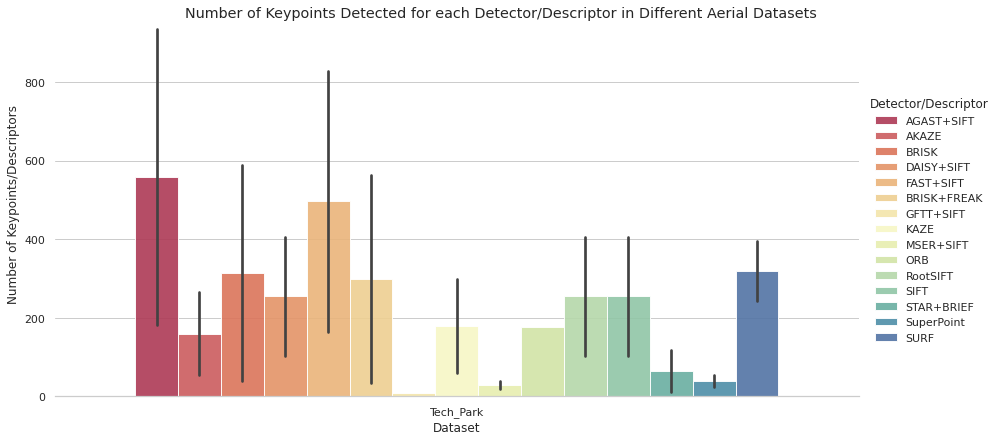

In [273]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_15, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [274]:
g.savefig(f'drive/MyDrive/Num_Kypoints_15_{Dataset}.png')

In [275]:
df_numkey_15.to_csv(f'drive/MyDrive/Num_Kypoints_15_{Dataset}.csv')

In [276]:
print(len(num_matches_agast))

112


**Didn't get good matches with MSER, so initialize a dummy variable for matches:**

In [277]:
num_matches_mser = [0]*len(num_matches_agast)

### **Total Number of Matches Detected for each Detector+Descriptor**

In [279]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf, 'Detector/Descriptor':['AGAST+SIFT']*(len_files-1) + ['AKAZE']*(len_files-1) + ['BRISK']*(len_files-1) + ['DAISY+SIFT']*(len_files-1) + ['FAST+SIFT']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['GFTT+SIFT']*(len_files-1) + ['KAZE']*(len_files-1) + ['MSER+SIFT']*(len_files-1) + ['ORB']*(len_files-1) +['RootSIFT']*(len_files-1) +['SIFT']*(len_files-1) + ['STAR+BRIEF']*(len_files-1) +  ['SuperPoint']*(len_files-1) + ['SURF']*(len_files-1) }
df_match_15 = pd.DataFrame(data=d)
df_match_15['Number of Total Matches'] = df_match_15['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

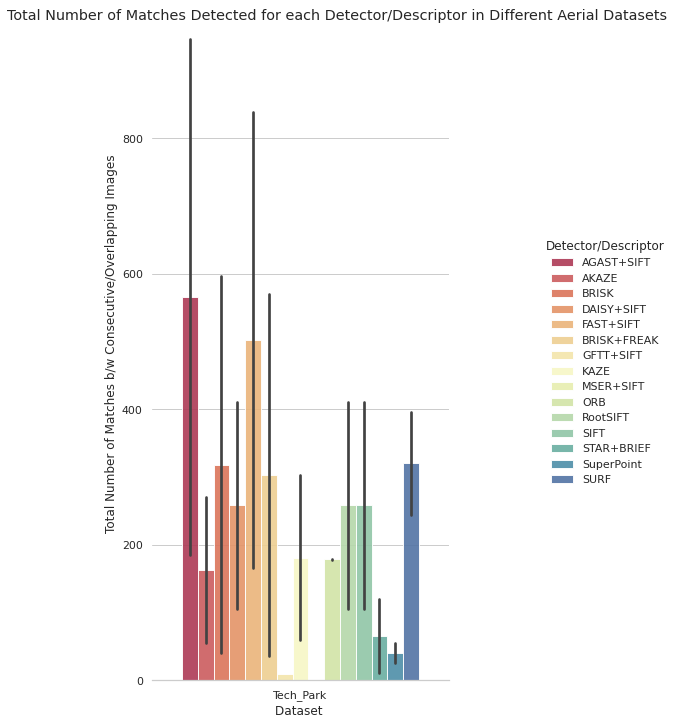

In [280]:
 import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [281]:
g.savefig(f'drive/MyDrive/Num_Matches_15_{Dataset}.png')

In [ ]:
#df_match_15.to_csv('drive/MyDrive/Num_Matches_15_{Dataset}.csv')

In [286]:
print(min(num_good_matches_agast))

5


### **Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor**

**Didn't get good matches with MSER, so initialize a dummy variable for good matches:**

In [282]:
num_good_matches_mser = [0]*len(num_good_matches_agast)

In [283]:
df_match_15['Number of Good Matches'] = num_good_matches_agast + num_good_matches_akaze + num_good_matches_brisk + num_good_matches_daisy + num_good_matches_fast + num_good_matches_freak + num_good_matches_gftt + num_good_matches_kaze + num_good_matches_mser + num_good_matches_orb + num_good_matches_rootsift + num_good_matches_sift + num_good_matches_briefstar + num_good_matches_superpoint+ num_good_matches_surf
df_match_15['Number of Good Matches'] = df_match_15['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

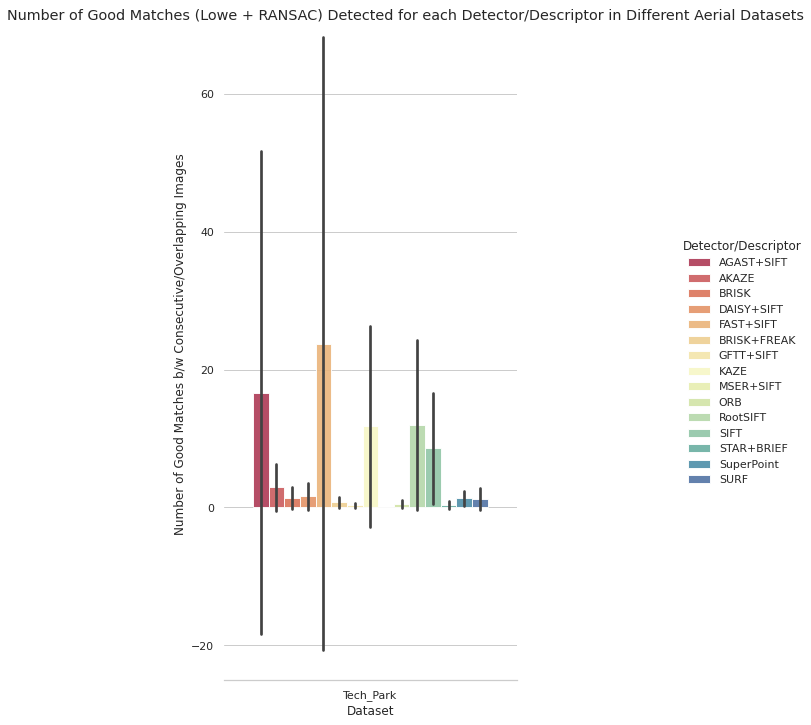

In [284]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [287]:
g.savefig(f'drive/MyDrive/Num_Good_Matches_15_{Dataset}.png')

In [ ]:
#df_match_15.to_csv('drive/MyDrive/Num_Good_Matches_15_{Dataset}.csv')

### **Recall Rate for each Detector+Descriptor**

In [288]:
df_match_15['Recall Rate of Matches'] = df_match_15['Number of Good Matches']/df_match_15['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

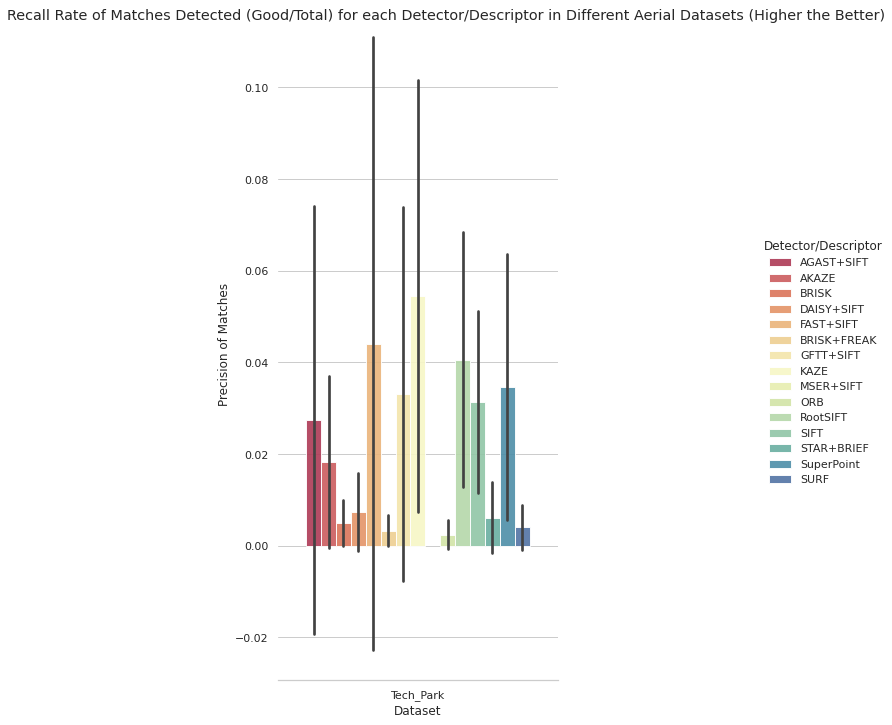

In [289]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [290]:
g.savefig(f'drive/MyDrive/Recall_Rate_Matches_15_{Dataset}.png')

### **1-Precision Rate for each Detector+Descriptor**

In [291]:
df_match_15['1 - Precision Rate of Matches'] = (df_match_15['Number of Total Matches'] - df_match_15['Number of Good Matches'])/df_match_15['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

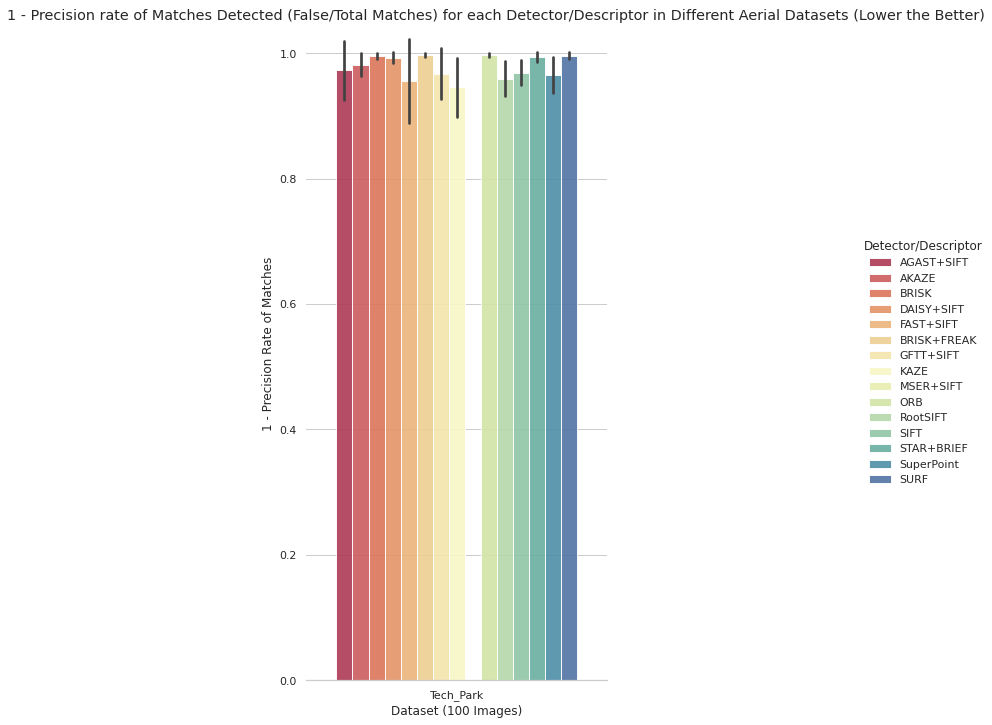

In [292]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (100 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [293]:
g.savefig(f'drive/MyDrive/One_minus_Precision_Rate_Matches_15_{Dataset}.png')

### **F-Score for each Detector+Descriptor**


In [294]:
df_match_15['F-Score'] = (2* (1 - df_match_15['1 - Precision Rate of Matches']) * df_match_15['Recall Rate of Matches'])/((1 - df_match_15['1 - Precision Rate of Matches']) + df_match_15['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

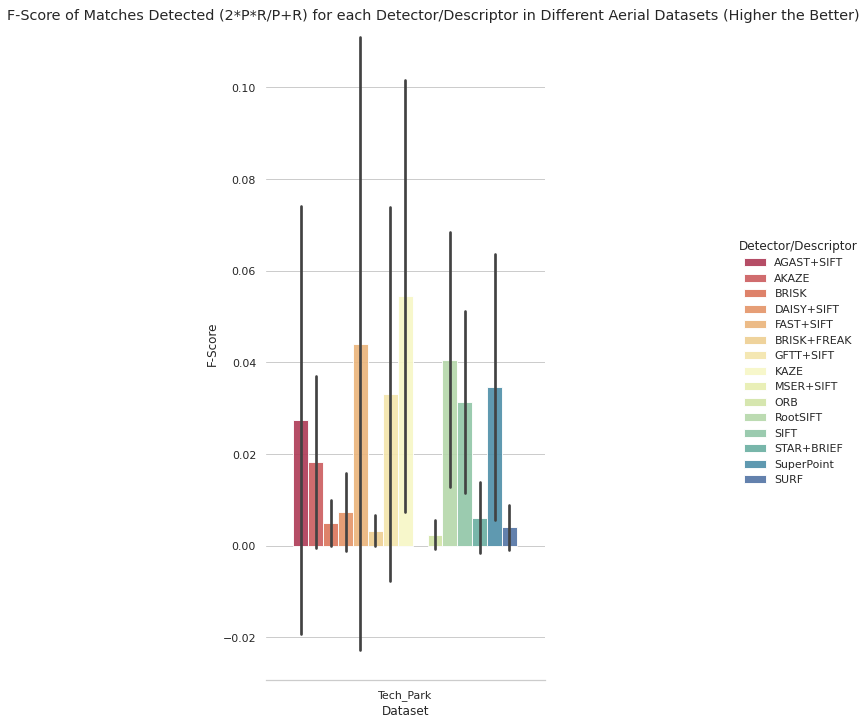

In [295]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [296]:
g.savefig(f'drive/MyDrive/F_Score_Rate_Matches_15_{Dataset}.png')

In [297]:
df_match_15.to_csv(f'drive/MyDrive/All_metrics_15_{Dataset}.csv')

### **Time for each Detector+Descriptor**

In [310]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time':  [time_all[7]] + [time_all[3]] + [time_all[0]] + [time_all[5]] + [time_all[10]] + [time_all[8]] + [time_all[9]] + [time_all[2]] + [time_all[6]] + [time_all[1]] + [time_all[13]] + [time_all[11]] + [time_all[4]] + [time_all[14]] + [time_all[12]] , 'Detector/Descriptor':['AGAST+SIFT'] + ['AKAZE'] + ['BRISK']*(1) + ['DAISY+SIFT']*(1) + ['FAST+SIFT']*(1) + ['BRISK+FREAK']*(1) + ['GFTT+SIFT']*(1) + ['KAZE']*(1) + ['MSER+SIFT']*(1) + ['ORB']*(1) +['RootSIFT']*(1) +['SIFT']*(1) + ['STAR+BRIEF']*(1) +  ['SuperPoint']*(1) + ['SURF']*(1)} 
df_time_15 = pd.DataFrame(data=d)

Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

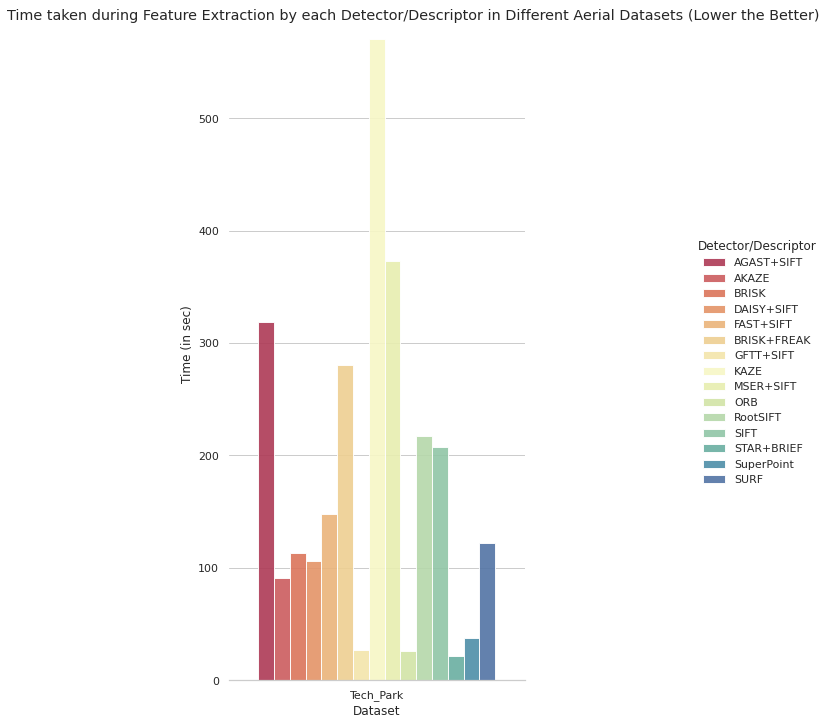

In [311]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_15, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [312]:
g.savefig(f'drive/MyDrive/Time_15_{Dataset}.png')

In [313]:
df_time_15.to_csv(f'drive/MyDrive/Time_15_{Dataset}.csv')